In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import argparse
import itertools
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.metrics import confusion_matrix

In [ ]:
pd.options.display.max_rows = 999

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_confusion_matrix(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    json_gold_pred = "label_set_info (id/gold/pred)"
    json_gold_pred_fine = "id_gold_pred_fine"
    json_cm = 'confusion_matrix'
    if is_fine:
        json_gold_pred = json_gold_pred_fine
        json_cm += '_fine'
    id_gold_preds = []
    binary_confusion_matrix = np.zeros((6,2,2))
    id_gold_preds_folds = []
    for results_dict in results_dicts:
        id_gold_preds_folds.append(results_dict[json_gold_pred])
        binary_confusion_matrix += np.array(results_dict[json_cm])
    
    n_rows = 3
    n_cols = 2
    n_classes = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    row_idx, col_idx = 0, 0
    for idx, cm in enumerate(binary_confusion_matrix):
        ax = axes[row_idx, col_idx]
        ax.set_title(class_labels[idx])
        #ax.set_ylabel('True')
        #ax.set_xlabel('Predicted')
        ax.imshow(cm, interpolation='nearest', cmap='Wistia')
        s = [['TN','FP'], ['FN', 'TP']]
        for i in range(2):
            for j in range(2):
                #ax.text(j,i, str(s[i][j])+"="+str(cm[i][j]))
                ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[0,1],
               yticklabels=[0,1],
               ylabel="True label",
               xlabel="Predicted label")
        ax.grid(False)
        ax.set_ylim((n_classes - 0.5, -0.5))
        #plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        # increment counters
        col_idx += 1
        if col_idx >= n_cols:
            col_idx = 0
            row_idx += 1
    fig.tight_layout()
    plt.show()
    doc_ids = []
    target_labels = []
    predicted_labels = []
    target_coarse_labels=[]
    predicted_coarse_labels=[]
    target_sets = []
    predicted_sets = []
    print(len(id_gold_preds_folds))
    # for id_gold_preds_fold in id_gold_preds_folds:
    for id_gold_pred in id_gold_preds_folds:
        print('id_gold_pred', id_gold_pred)
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        pred_coarse_fold_labels = []
        for doc_id, gold_set, pred_set in id_gold_pred:
            coarse_gold = []
            coarse_pred = []
            if gold_set[0] or gold_set[1]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[2] or gold_set[3]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[4] or gold_set[5]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
                
            if pred_set[0] or pred_set[1]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[2] or pred_set[3]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[4] or pred_set[5]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            target_coarse_fold_labels.append(coarse_gold)
            pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            
            doc_fold_ids.append([doc_id]*len(gold_set))
        target_labels.append(target_fold_labels)
        predicted_labels.append(predicted_fold_labels)
        
        target_coarse_labels.append(target_coarse_fold_labels)
        predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.append(doc_fold_ids)
        
    target_sets = [''.join(map(str, target_label_set)) for target_label_set in target_sets]
    predicted_sets = [''.join(map(str, predicted_label_set)) for predicted_label_set in predicted_sets]
    
    if all_label_sets_ordered is None:
        s = pd.Series(target_sets)
        s.value_counts().plot(kind='bar')
        target_sets_ordered = s.value_counts().index.values
    
        missing_labels = set(predicted_sets).difference(set(target_sets_ordered))
        all_label_sets_ordered = np.append(target_sets_ordered,list(missing_labels))
    cm=confusion_matrix(target_sets, predicted_sets, labels=all_label_sets_ordered)
    
    plot_confusion_matrix(cm, all_label_sets_ordered, normalize=False)
    plt.show()
    return doc_ids, target_labels, predicted_labels, target_coarse_labels, predicted_coarse_labels, all_label_sets_ordered


# base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [ ]:
def get_coarse_confusion_matrix(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    json_gold_pred = "label_set_info (id/gold/pred)"
    # json_gold_pred_fine = "id_gold_pred_fine"
    json_cm = 'confusion_matrix'
    # if is_fine:
    #     json_gold_pred = json_gold_pred_fine
    #     json_cm += '_fine'
    id_gold_preds = []
    binary_confusion_matrix = np.zeros((6,2,2))
    id_gold_preds_folds = []
    for results_dict in results_dicts:
        id_gold_preds_folds.append(results_dict[json_gold_pred])
        binary_confusion_matrix += np.array(results_dict[json_cm])
    
    n_rows = 3
    n_cols = 1
    n_classes = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    row_idx, col_idx = 0, 0
    for idx, cm in enumerate(binary_confusion_matrix):
        ax = axes[row_idx, col_idx]
        ax.set_title(class_labels[idx])
        #ax.set_ylabel('True')
        #ax.set_xlabel('Predicted')
        ax.imshow(cm, interpolation='nearest', cmap='Wistia')
        s = [['TN','FP'], ['FN', 'TP']]
        for i in range(2):
            for j in range(2):
                #ax.text(j,i, str(s[i][j])+"="+str(cm[i][j]))
                ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[0,1],
               yticklabels=[0,1],
               ylabel="True label",
               xlabel="Predicted label")
        ax.grid(False)
        ax.set_ylim((n_classes - 0.5, -0.5))
        #plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        # increment counters
        col_idx += 1
        if col_idx >= n_cols:
            col_idx = 0
            row_idx += 1
    fig.tight_layout()
    plt.show()
    doc_ids = []
    target_labels = []
    predicted_labels = []
    # target_coarse_labels=[]
    # predicted_coarse_labels=[]
    target_sets = []
    predicted_sets = []
    print(len(id_gold_preds_folds))
    # for id_gold_preds_fold in id_gold_preds_folds:
    for id_gold_pred in id_gold_preds_folds:
        print('id_gold_pred', id_gold_pred)
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        # target_coarse_fold_labels = []
        # # pred_coarse_fold_labels = []
        for doc_id, gold_set, pred_set in id_gold_pred:
        #     coarse_gold = []
        #     coarse_pred = []
        #     if gold_set[0] or gold_set[1]:
        #         coarse_gold.append(1)
        #     else:
        #         coarse_gold.append(0)
        #     if gold_set[2] or gold_set[3]:
        #         coarse_gold.append(1)
        #     else:
        #         coarse_gold.append(0)
        #     if gold_set[4] or gold_set[5]:
        #         coarse_gold.append(1)
        #     else:
        #         coarse_gold.append(0)
                
        #     if pred_set[0] or pred_set[1]:
        #         coarse_pred.append(1)
        #     else:
        #         coarse_pred.append(0)
        #     if pred_set[2] or pred_set[3]:
        #         coarse_pred.append(1)
        #     else:
        #         coarse_pred.append(0)
        #     if pred_set[4] or pred_set[5]:
        #         coarse_pred.append(1)
        #     else:
        #         coarse_pred.append(0)
            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            # target_coarse_fold_labels.append(coarse_gold)
            # pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            
            doc_fold_ids.append([doc_id]*len(gold_set))
        target_labels.append(target_fold_labels)
        predicted_labels.append(predicted_fold_labels)
        
        # target_coarse_labels.append(target_coarse_fold_labels)
        # predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.append(doc_fold_ids)
        
    target_sets = [''.join(map(str, target_label_set)) for target_label_set in target_sets]
    predicted_sets = [''.join(map(str, predicted_label_set)) for predicted_label_set in predicted_sets]
    
    if all_label_sets_ordered is None:
        s = pd.Series(target_sets)
        s.value_counts().plot(kind='bar')
        target_sets_ordered = s.value_counts().index.values
    
        missing_labels = set(predicted_sets).difference(set(target_sets_ordered))
        all_label_sets_ordered = np.append(target_sets_ordered,list(missing_labels))
    cm=confusion_matrix(target_sets, predicted_sets, labels=all_label_sets_ordered)
    
    plot_confusion_matrix(cm, all_label_sets_ordered, normalize=False)
    plt.show()
    return doc_ids, target_labels, predicted_labels, all_label_sets_ordered
    # return doc_ids, target_labels, predicted_labels, target_coarse_labels, predicted_coarse_labels, all_label_sets_ordered


# base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_color = "black"
        if i==j:
            text_color = "red"
        elif cm[i, j] > thresh:
            text_color = "white"
                
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

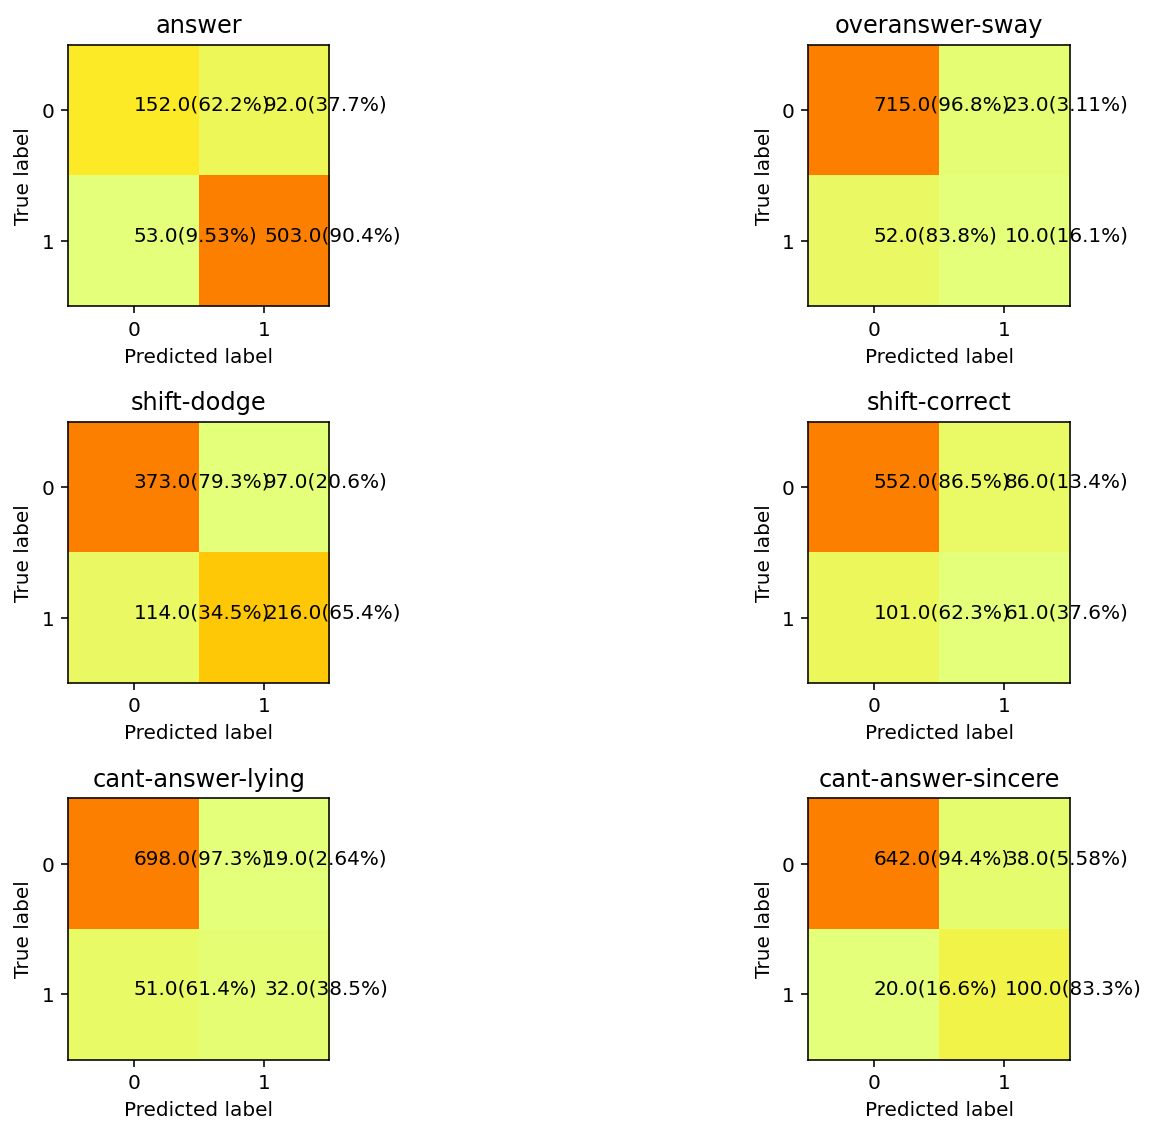

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 0, 0, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

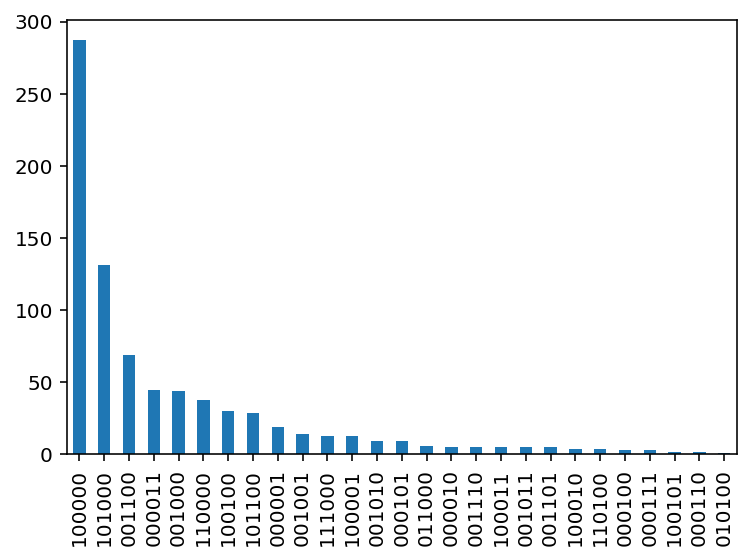

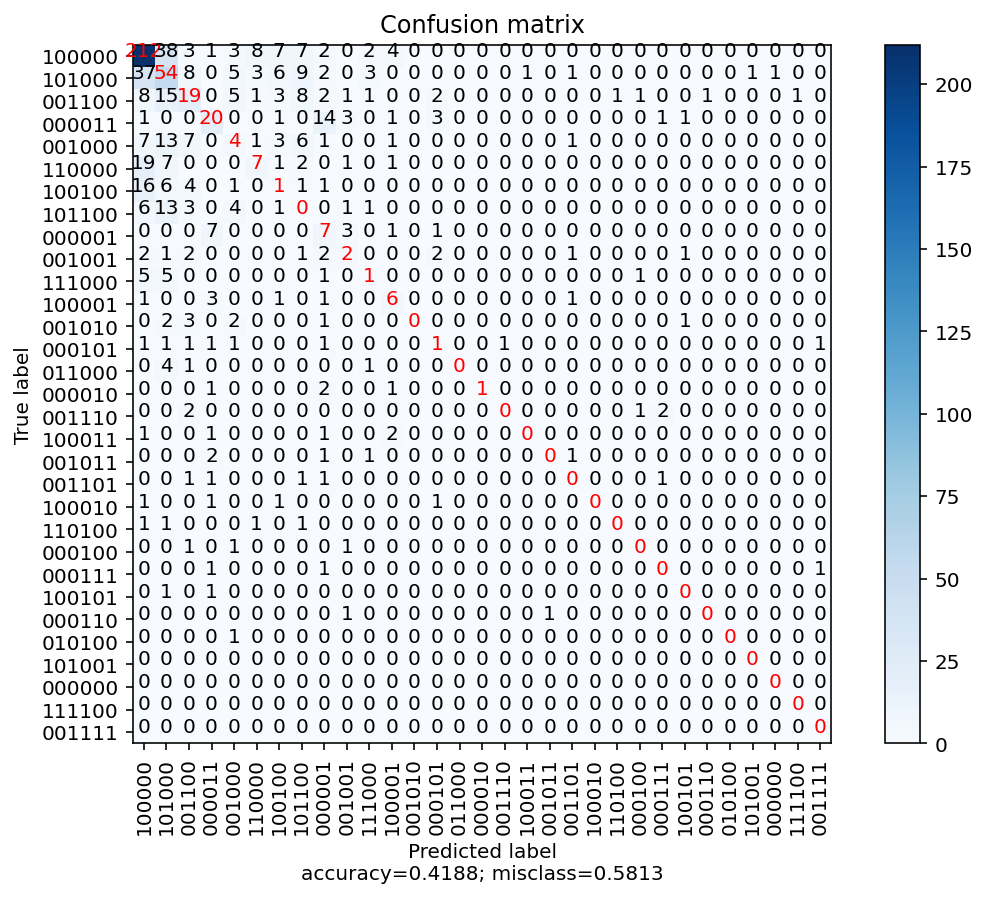

In [ ]:
class_labels = ['answer', 'overanswer-sway', 
                'shift-dodge', 'shift-correct', 
                'cant-answer-lying','cant-answer-sincere'] 
base_files = []
for fold_num in range(4):
    base_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/models/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')

    # base_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/models/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
    # base_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_classification/1_input/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [ ]:
base_coarse_targets

NameError: ignored

In [18]:
# base_ids

In [19]:
all_class_labels = []
all_base_ids = []
all_base_targets = []
all_base_preds = []
for fold in range(len(base_ids)):
    all_class_labels.append(class_labels*(len(base_ids[fold])))
    all_base_ids.append(list(itertools.chain.from_iterable(base_ids[fold])))
    all_base_targets.append(list(itertools.chain.from_iterable(base_targets[fold])))
    all_base_preds.append(list(itertools.chain.from_iterable(base_preds[fold])))
base_dfs=[]
for fold in range(len(base_ids)):
    base_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_base_ids[fold], all_base_targets[fold], all_base_preds[fold]), columns=['label','qa_index','gold','pred']))
    base_dfs[fold]['correct'] = base_dfs[fold]['gold']==base_dfs[fold]['pred']
    base_dfs[fold]['uid'] = base_dfs[fold]['label']+'_'+base_dfs[fold]['qa_index'].astype(str)

In [20]:
incorrect_base_qas=[]
for fold in range(4):
    incorrect_base_qas.extend(base_dfs[fold][base_dfs[fold]['correct']==False]['qa_index'].values)

In [ ]:
f1_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_scores)
np.mean(np.array(f1_scores))

Fold scores [0.5289616005646586, 0.5269240506082612, 0.5260078297033792, 0.6920139332434414]


0.5684768535299352

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.87244018, 0.20263158, 0.66780743, 0.3974359 , 0.49436564,
       0.77618039])

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(base_coarse_targets, base_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.87577628, 0.72944547, 0.80382315])

In [ ]:
# hearing_scores_dict = {}
# hearing_scores = []
# for all_base_ids = []
# all_base_targets = []
# all_base_preds = []
#     #hearing_scores_dict
base_ids = list(itertools.chain.from_iterable(all_base_ids))
base_targets = list(itertools.chain.from_iterable(all_base_targets))
base_preds = list(itertools.chain.from_iterable(all_base_preds))


### Hierarchical

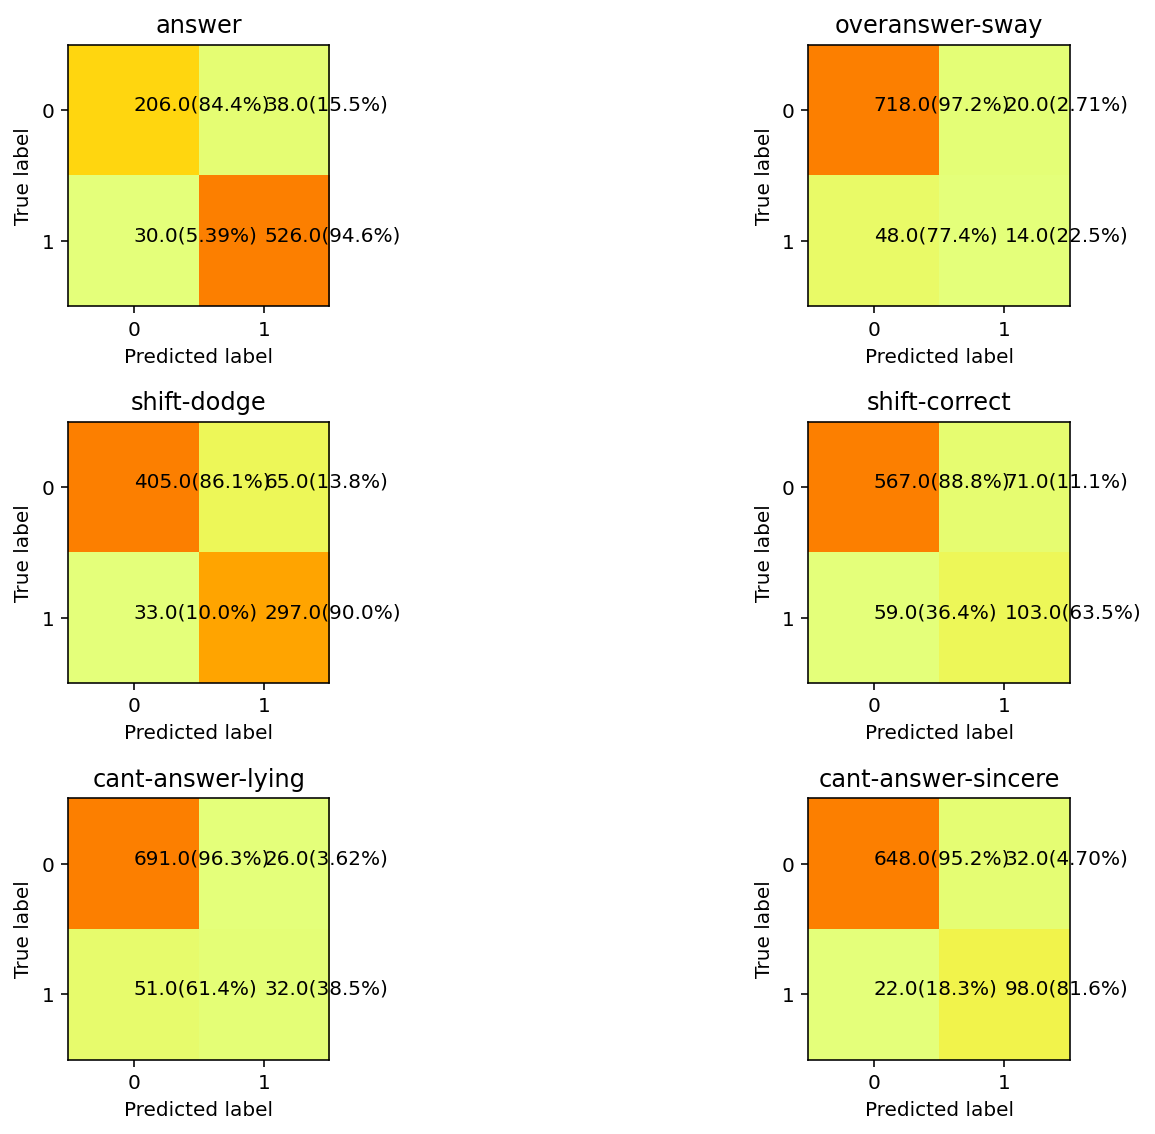

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

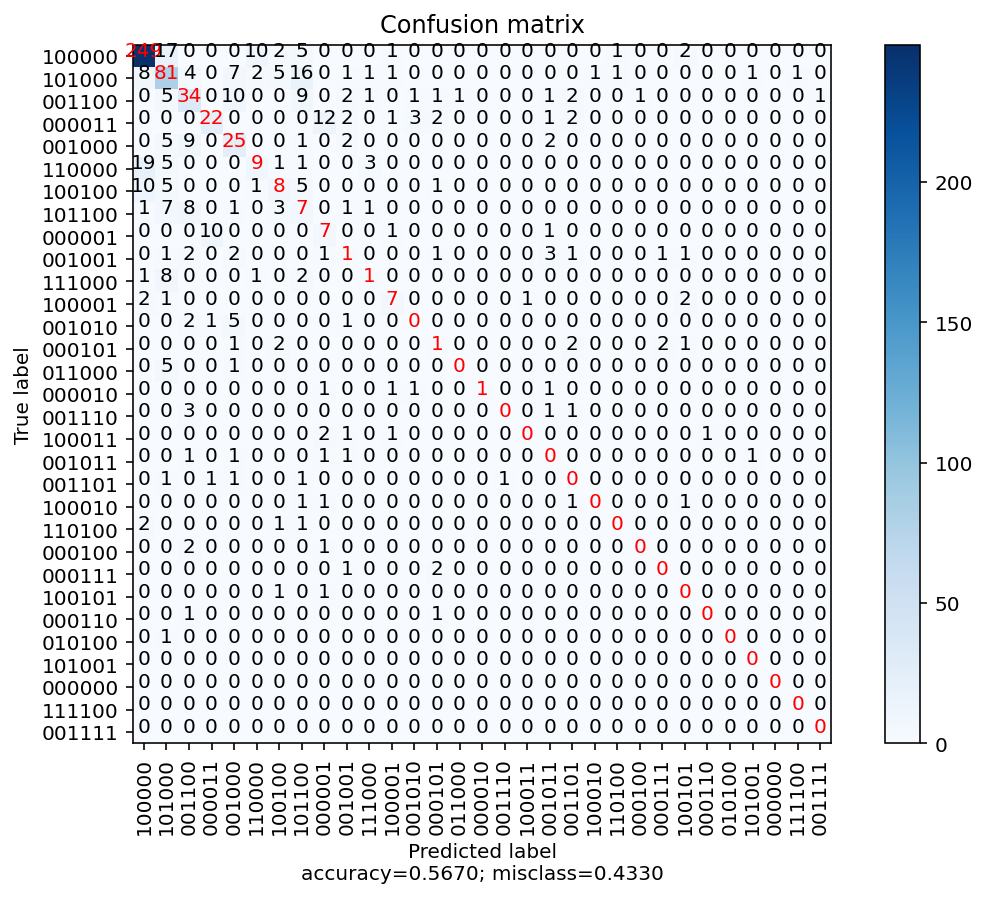

In [21]:
hier_files = []
for fold_num in range(4):
    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_coarse')

    hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
hier_ids, hier_targets, hier_preds, hier_coarse_targets, hier_coarse_preds, _ = get_confusion_matrix(hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(hier_targets, hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.87843418, 0.16090334, 0.67166019, 0.4401085 , 0.4854281 ,
       0.73811433])

In [ ]:
f1_hier_scores = []
for fold_targets, fold_preds in zip(hier_targets, hier_preds):
    f1_hier_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_hier_scores)
np.mean(np.array(f1_hier_scores))

Fold scores [0.5711310092403044, 0.5363872238872239, 0.5251824093592726, 0.6170651102794774]


0.5624414381915696

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.88525011, 0.74156711, 0.78072581])

In [24]:
all_class_labels = []
all_hier_ids = []
all_hier_targets = []
all_hier_preds = []
for fold in range(len(hier_ids)):
    all_class_labels.append(class_labels*(len(hier_ids[fold])))
    all_hier_ids.append(list(itertools.chain.from_iterable(hier_ids[fold])))
    all_hier_targets.append(list(itertools.chain.from_iterable(hier_targets[fold])))
    all_hier_preds.append(list(itertools.chain.from_iterable(hier_preds[fold])))
hier_dfs = []
for fold in range(len(hier_ids)):
    hier_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_hier_ids[fold], all_hier_targets[fold], all_hier_preds[fold]), columns=['label','qa_index','gold','pred']))
    hier_dfs[fold]['correct'] = hier_dfs[fold]['gold']==hier_dfs[fold]['pred']
    hier_dfs[fold]['uid'] = hier_dfs[fold]['label']+'_'+hier_dfs[fold]['qa_index'].astype(str)
merged_hier_dfs = []
for fold in range(len(hier_dfs)):
    merged_hier_dfs.append(base_dfs[fold].merge(hier_dfs[fold], on='uid',suffixes=('_base', '_hier')))

In [25]:
for fold in range(len(merged_hier_dfs)):
    print('Fold', fold)
    merged_hier_dfs[fold]['hearing_id'] = merged_hier_dfs[fold]['qa_index_base'].astype(str).str[:8]
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['hearing_id'].value_counts())
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['label_base'].value_counts())

Fold 0


11636001    53
11531504    33
11422125    26
11637282    19
Name: hearing_id, dtype: int64

shift-dodge            38
answer                 32
shift-correct          32
cant-answer-lying      11
cant-answer-sincere    10
overanswer-sway         8
Name: label_base, dtype: int64

Fold 1


11426003    37
11420722    35
11530242    31
11386195    27
Name: hearing_id, dtype: int64

shift-dodge            44
shift-correct          38
answer                 26
cant-answer-sincere     9
overanswer-sway         8
cant-answer-lying       5
Name: label_base, dtype: int64

Fold 2


11532380    42
11635589    32
11531349    29
11393834    18
Name: hearing_id, dtype: int64

shift-dodge            43
answer                 28
shift-correct          24
cant-answer-sincere    10
overanswer-sway         9
cant-answer-lying       7
Name: label_base, dtype: int64

Fold 3


11495063    27
11497630    24
11530956    23
11635230    19
Name: hearing_id, dtype: int64

shift-dodge            37
shift-correct          23
answer                 19
overanswer-sway         9
cant-answer-sincere     4
cant-answer-lying       1
Name: label_base, dtype: int64

In [ ]:
for fold in range(4):
    print('Fold', fold)
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)])

Fold 0


label_base  qa_index_base  gold_base  pred_base  correct_base  \
9     shift-correct    11531504011          0          1         False   
141   shift-correct    11531504029          0          1         False   
255   shift-correct    11637282128          0          1         False   
261   shift-correct    11636001090          0          1         False   
309   shift-correct    11422125123          1          0         False   
465   shift-correct    11531504017          0          1         False   
591   shift-correct    11422125105          1          0         False   
819   shift-correct    11422125119          0          1         False   
855   shift-correct    11422125022          0          1         False   
861   shift-correct    11531504059          1          0         False   
933   shift-correct    11531504031          0          1         False   
1035  shift-correct    11636001145          1          0         False   
1065  shift-correct    11531504084          0          1         False   
1071  shift-correct    11422125014          0          1         False   
1161  shift-correct    11637282059          0          1         False   

                            uid     label_hier  qa_index_hier  gold_hier  \
9     shift-correct_11531504011  shift-correct    11531504011          0   
141   shift-correct_11531504029  shift-correct    11531504029          0   
255   shift-correct_11637282128  shift-correct    11637282128          0   
261   shift-correct_11636001090  shift-correct    11636001090          0   
309   shift-correct_11422125123  shift-correct    11422125123          1   
465   shift-correct_11531504017  shift-correct    11531504017          0   
591   shift-correct_11422125105  shift-correct    11422125105          1   
819   shift-correct_11422125119  shift-correct    11422125119          0   
855   shift-correct_11422125022  shift-correct    11422125022          0   
861   shift-correct_11531504059  shift-correct    11531504059          1   
933   shift-correct_11531504031  shift-correct    11531504031          0   
1035  shift-correct_11636001145  shift-correct    11636001145          1   
1065  shift-correct_11531504084  shift-correct    11531504084          0   
1071  shift-correct_11422125014  shift-correct    11422125014          0   
1161  shift-correct_11637282059  shift-correct    11637282059          0   

      pred_hier  correct_hier hearing_id  
9             0          True   11531504  
141           0          True   11531504  
255           0          True   11637282  
261           0          True   11636001  
309           1          True   11422125  
465           0          True   11531504  
591           1          True   11422125  
819           0          True   11422125  
855           0          True   11422125  
861           1          True   11531504  
933           0          True   11531504  
1035          1          True   11636001  
1065          0          True   11531504  
1071          0          True   11422125  
1161          0          True   11637282

Fold 1


label_base  qa_index_base  gold_base  pred_base  correct_base  \
63    shift-correct    11386195051          1          0         False   
105   shift-correct    11426003004          0          1         False   
117   shift-correct    11426003091          0          1         False   
273   shift-correct    11426003043          0          1         False   
291   shift-correct    11420722094          1          0         False   
363   shift-correct    11420722033          0          1         False   
429   shift-correct    11386195094          1          0         False   
465   shift-correct    11386195014          1          0         False   
519   shift-correct    11426003039          1          0         False   
525   shift-correct    11386195034          1          0         False   
531   shift-correct    11420722133          1          0         False   
585   shift-correct    11530242093          1          0         False   
633   shift-correct    11420722137          1          0         False   
705   shift-correct    11426003066          0          1         False   
921   shift-correct    11386195000          0          1         False   
957   shift-correct    11426003006          0          1         False   
1089  shift-correct    11420722016          1          0         False   
1137  shift-correct    11420722090          1          0         False   
1161  shift-correct    11386195036          1          0         False   

                            uid     label_hier  qa_index_hier  gold_hier  \
63    shift-correct_11386195051  shift-correct    11386195051          1   
105   shift-correct_11426003004  shift-correct    11426003004          0   
117   shift-correct_11426003091  shift-correct    11426003091          0   
273   shift-correct_11426003043  shift-correct    11426003043          0   
291   shift-correct_11420722094  shift-correct    11420722094          1   
363   shift-correct_11420722033  shift-correct    11420722033          0   
429   shift-correct_11386195094  shift-correct    11386195094          1   
465   shift-correct_11386195014  shift-correct    11386195014          1   
519   shift-correct_11426003039  shift-correct    11426003039          1   
525   shift-correct_11386195034  shift-correct    11386195034          1   
531   shift-correct_11420722133  shift-correct    11420722133          1   
585   shift-correct_11530242093  shift-correct    11530242093          1   
633   shift-correct_11420722137  shift-correct    11420722137          1   
705   shift-correct_11426003066  shift-correct    11426003066          0   
921   shift-correct_11386195000  shift-correct    11386195000          0   
957   shift-correct_11426003006  shift-correct    11426003006          0   
1089  shift-correct_11420722016  shift-correct    11420722016          1   
1137  shift-correct_11420722090  shift-correct    11420722090          1   
1161  shift-correct_11386195036  shift-correct    11386195036          1   

      pred_hier  correct_hier hearing_id  
63            1          True   11386195  
105           0          True   11426003  
117           0          True   11426003  
273           0          True   11426003  
291           1          True   11420722  
363           0          True   11420722  
429           1          True   11386195  
465           1          True   11386195  
519           1          True   11426003  
525           1          True   11386195  
531           1          True   11420722  
585           1          True   11530242  
633           1          True   11420722  
705           0          True   11426003  
921           0          True   11386195  
957           0          True   11426003  
1089          1          True   11420722  
1137          1          True   11420722  
1161          1          True   11386195

Fold 2


label_base  qa_index_base  gold_base  pred_base  correct_base  \
27    shift-correct    11635589072          0          1         False   
33    shift-correct    11531349119          0          1         False   
81    shift-correct    11532380105          1          0         False   
165   shift-correct    11531349091          1          0         False   
261   shift-correct    11531349008          0          1         False   
333   shift-correct    11531349123          0          1         False   
357   shift-correct    11531349027          0          1         False   
453   shift-correct    11635589104          1          0         False   
561   shift-correct    11635589054          1          0         False   
771   shift-correct    11531349126          0          1         False   
831   shift-correct    11635589098          0          1         False   
837   shift-correct    11531349061          1          0         False   
891   shift-correct    11532380027          0          1         False   
927   shift-correct    11635589003          0          1         False   
981   shift-correct    11393834075          1          0         False   
1041  shift-correct    11532380097          0          1         False   
1047  shift-correct    11393834048          0          1         False   

                            uid     label_hier  qa_index_hier  gold_hier  \
27    shift-correct_11635589072  shift-correct    11635589072          0   
33    shift-correct_11531349119  shift-correct    11531349119          0   
81    shift-correct_11532380105  shift-correct    11532380105          1   
165   shift-correct_11531349091  shift-correct    11531349091          1   
261   shift-correct_11531349008  shift-correct    11531349008          0   
333   shift-correct_11531349123  shift-correct    11531349123          0   
357   shift-correct_11531349027  shift-correct    11531349027          0   
453   shift-correct_11635589104  shift-correct    11635589104          1   
561   shift-correct_11635589054  shift-correct    11635589054          1   
771   shift-correct_11531349126  shift-correct    11531349126          0   
831   shift-correct_11635589098  shift-correct    11635589098          0   
837   shift-correct_11531349061  shift-correct    11531349061          1   
891   shift-correct_11532380027  shift-correct    11532380027          0   
927   shift-correct_11635589003  shift-correct    11635589003          0   
981   shift-correct_11393834075  shift-correct    11393834075          1   
1041  shift-correct_11532380097  shift-correct    11532380097          0   
1047  shift-correct_11393834048  shift-correct    11393834048          0   

      pred_hier  correct_hier hearing_id  
27            0          True   11635589  
33            0          True   11531349  
81            1          True   11532380  
165           1          True   11531349  
261           0          True   11531349  
333           0          True   11531349  
357           0          True   11531349  
453           1          True   11635589  
561           1          True   11635589  
771           0          True   11531349  
831           0          True   11635589  
837           1          True   11531349  
891           0          True   11532380  
927           0          True   11635589  
981           1          True   11393834  
1041          0          True   11532380  
1047          0          True   11393834

Fold 3


label_base  qa_index_base  gold_base  pred_base  correct_base  \
9     shift-correct    11635230123          1          0         False   
99    shift-correct    11497630051          1          0         False   
117   shift-correct    11530956079          1          0         False   
285   shift-correct    11495063109          1          0         False   
399   shift-correct    11530956047          1          0         False   
519   shift-correct    11530956065          1          0         False   
651   shift-correct    11530956018          1          0         False   
657   shift-correct    11497630038          1          0         False   
831   shift-correct    11635230129          0          1         False   
957   shift-correct    11495063048          1          0         False   
1071  shift-correct    11530956123          1          0         False   

                            uid     label_hier  qa_index_hier  gold_hier  \
9     shift-correct_11635230123  shift-correct    11635230123          1   
99    shift-correct_11497630051  shift-correct    11497630051          1   
117   shift-correct_11530956079  shift-correct    11530956079          1   
285   shift-correct_11495063109  shift-correct    11495063109          1   
399   shift-correct_11530956047  shift-correct    11530956047          1   
519   shift-correct_11530956065  shift-correct    11530956065          1   
651   shift-correct_11530956018  shift-correct    11530956018          1   
657   shift-correct_11497630038  shift-correct    11497630038          1   
831   shift-correct_11635230129  shift-correct    11635230129          0   
957   shift-correct_11495063048  shift-correct    11495063048          1   
1071  shift-correct_11530956123  shift-correct    11530956123          1   

      pred_hier  correct_hier hearing_id  
9             1          True   11635230  
99            1          True   11497630  
117           1          True   11530956  
285           1          True   11495063  
399           1          True   11530956  
519           1          True   11530956  
651           1          True   11530956  
657           1          True   11497630  
831           0          True   11635230  
957           1          True   11495063  
1071          1          True   11530956

In [ ]:
corrected_hier_qas = []
for fold in range(4):
    corrected_hier_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_base'])

### Deberta - Base

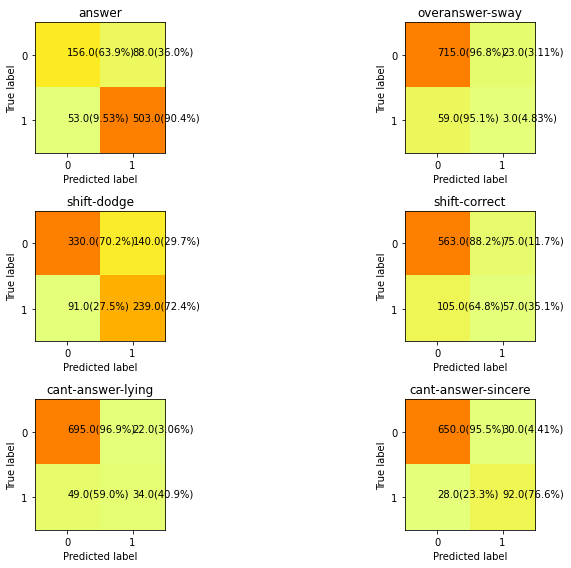

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

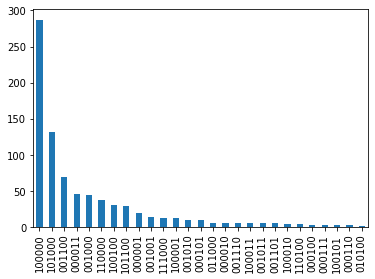

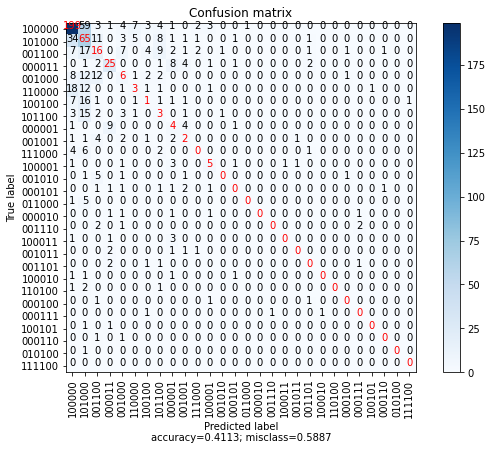

In [ ]:
deberta_base_files = []
for fold_num in range(4):
    deberta_base_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_deberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_coarse')

    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')

deberta_base_ids, deberta_base_targets, deberta_base_preds, deberta_base_coarse_targets, deberta_base_coarse_preds, deberta_base_targets_ordered = get_confusion_matrix(deberta_base_files)
# hier_ids, hier_targets, hier_preds, hier_coarse_targets, hier_coarse_preds, _ = get_confusion_matrix(deberta_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
all_deberta_class_labels = []
all_deberta_base_ids = []
all_deberta_base_targets = []
all_deberta_base_preds = []
for fold in range(len(deberta_base_ids)):
    all_deberta_class_labels.append(class_labels*(len(deberta_base_ids[fold])))
    all_deberta_base_ids.append(list(itertools.chain.from_iterable(deberta_base_ids[fold])))
    all_deberta_base_targets.append(list(itertools.chain.from_iterable(deberta_base_targets[fold])))
    all_deberta_base_preds.append(list(itertools.chain.from_iterable(deberta_base_preds[fold])))
deberta_base_dfs=[]
for fold in range(len(deberta_base_ids)):
    deberta_base_dfs.append(pd.DataFrame(zip(all_deberta_class_labels[fold], all_deberta_base_ids[fold], all_deberta_base_targets[fold], all_deberta_base_preds[fold]), columns=['label','qa_index','gold','pred']))
    deberta_base_dfs[fold]['correct'] = deberta_base_dfs[fold]['gold']==deberta_base_dfs[fold]['pred']
    deberta_base_dfs[fold]['uid'] = deberta_base_dfs[fold]['label']+'_'+deberta_base_dfs[fold]['qa_index'].astype(str)

In [ ]:
incorrect_deberta_base_qas=[]
for fold in range(4):
    incorrect_deberta_base_qas.extend(deberta_base_dfs[fold][deberta_base_dfs[fold]['correct']==False]['qa_index'].values)

In [ ]:
f1_scores = []
for fold_targets, fold_preds in zip(deberta_base_targets, deberta_base_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_scores)
np.mean(np.array(f1_scores))

Fold scores [0.5551146102662512, 0.49281026775844666, 0.52362229371359, 0.6045193364620357]


0.5440166270500809

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(deberta_base_targets, deberta_base_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.87594105, 0.07142857, 0.66818708, 0.38462962, 0.49911898,
       0.76479446])

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(deberta_base_coarse_targets, deberta_base_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.883825  , 0.73702138, 0.76920547])

## DeBERTa - Hier

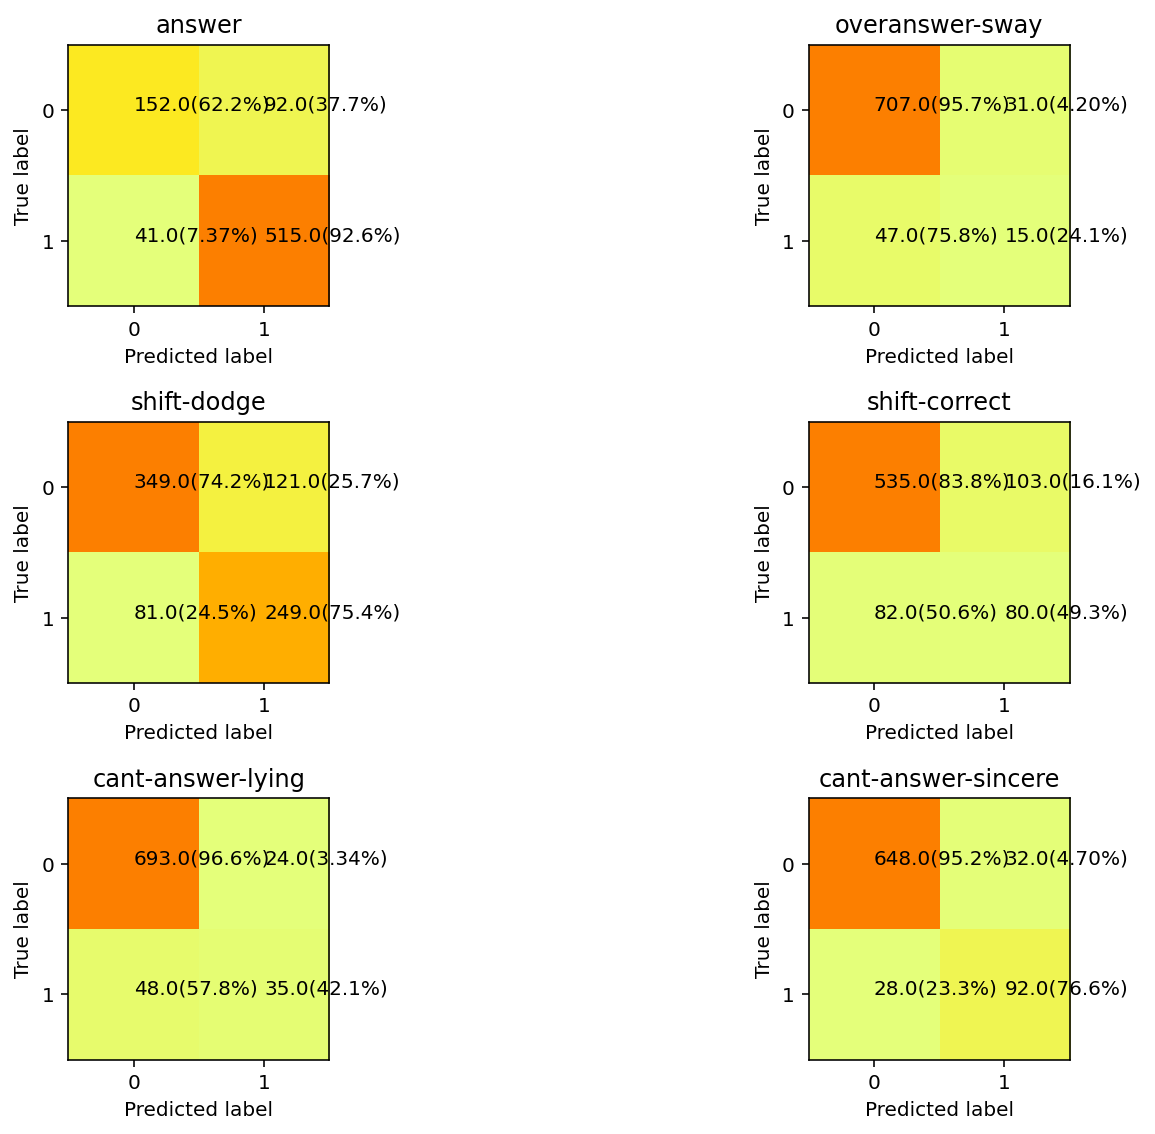

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 1, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 0, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0,

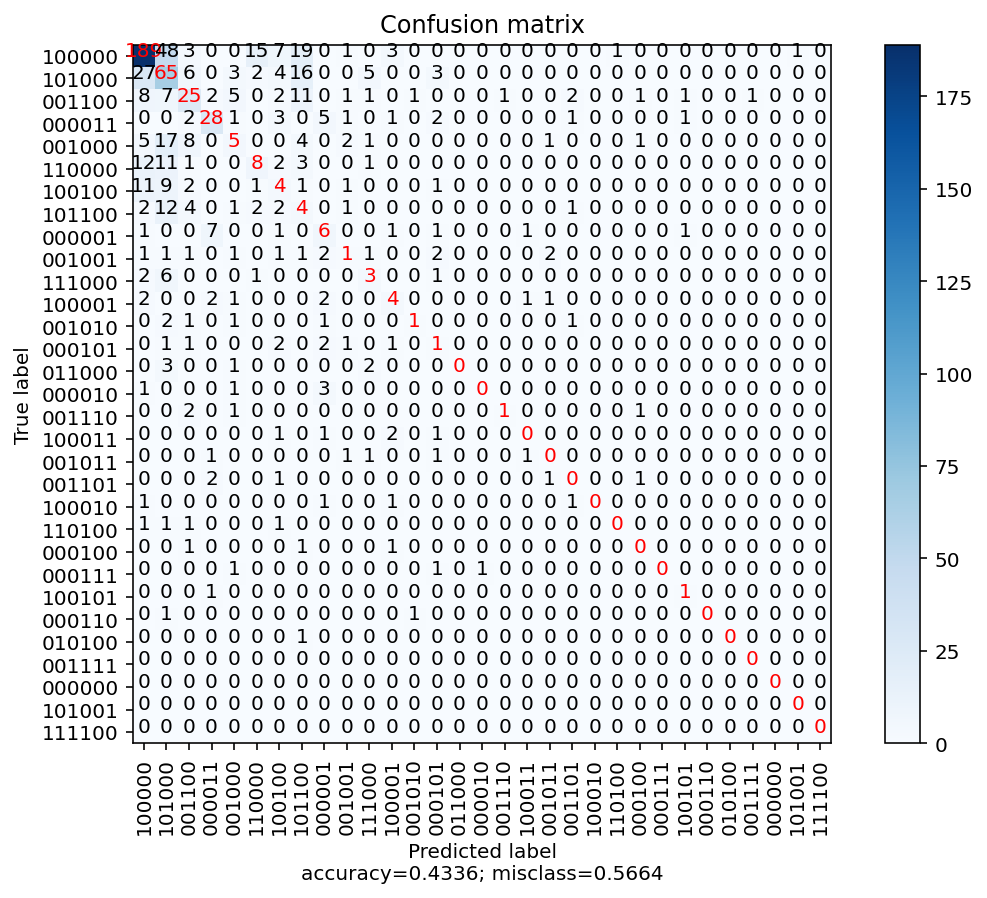

In [ ]:
deberta_hier_files = []
for fold_num in range(4):
    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_coarse')

    deberta_hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_deberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
deberta_hier_ids, deberta_hier_targets, deberta_hier_preds, deberta_hier_coarse_targets, deberta_hier_coarse_preds, _ = get_confusion_matrix(deberta_hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(deberta_hier_targets, deberta_hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.88451352, 0.28232601, 0.70386015, 0.4590741 , 0.50202322,
       0.75881033])

In [ ]:
f1_hier_scores = []
for fold_targets, fold_preds in zip(deberta_hier_targets, deberta_hier_preds):
    f1_hier_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_hier_scores)
np.mean(np.array(f1_hier_scores))

Fold scores [0.5555670446543463, 0.5764199309854671, 0.598119349005425, 0.6636318892132845]


0.5984345534646307

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(deberta_hier_coarse_targets, deberta_hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.88890101, 0.75355172, 0.76932115])

### Explanations Only

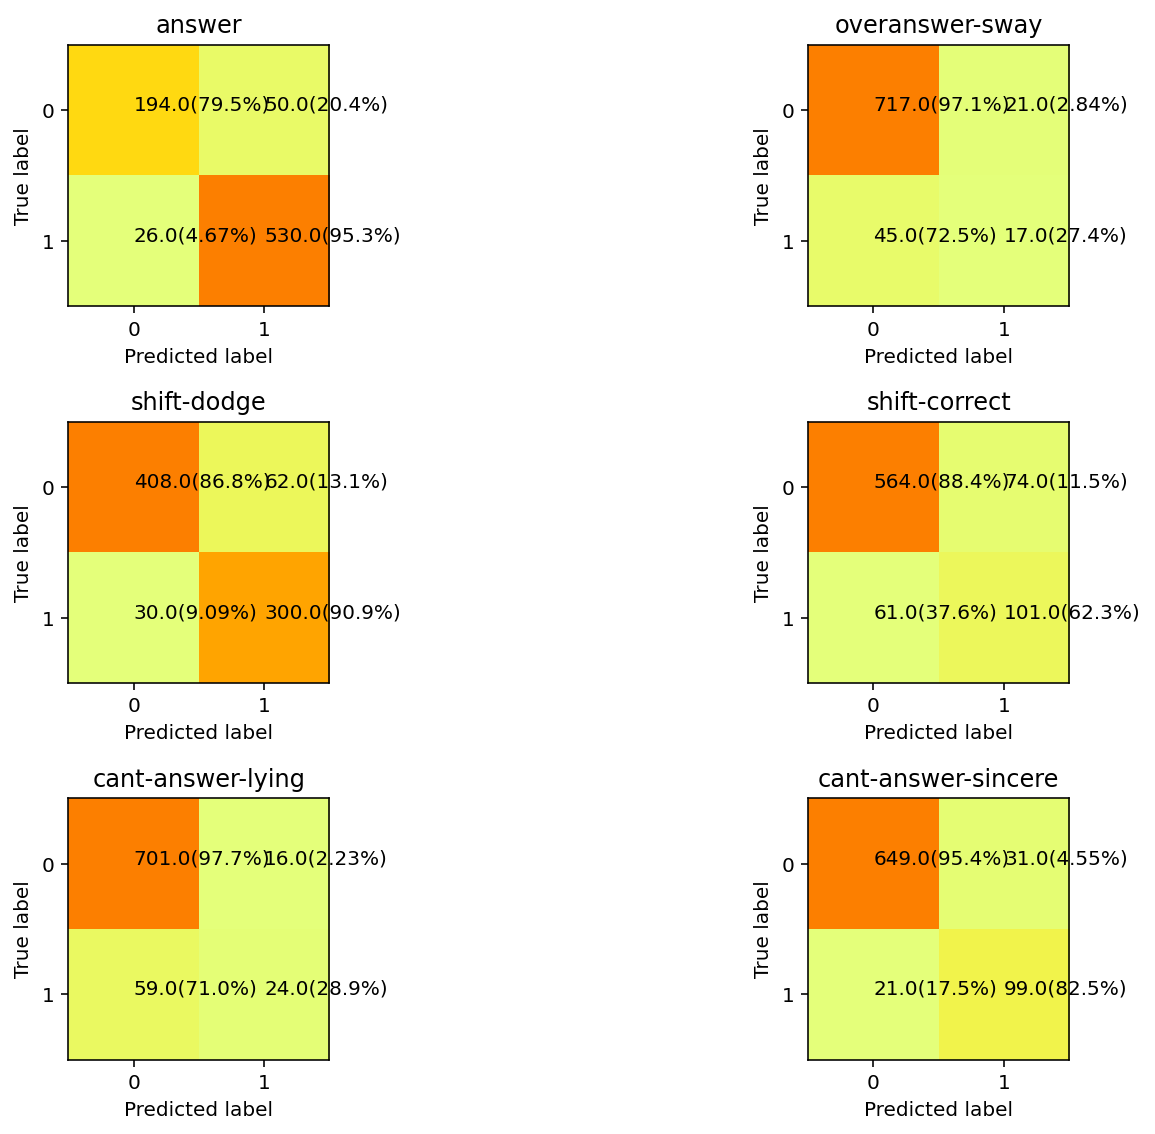

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

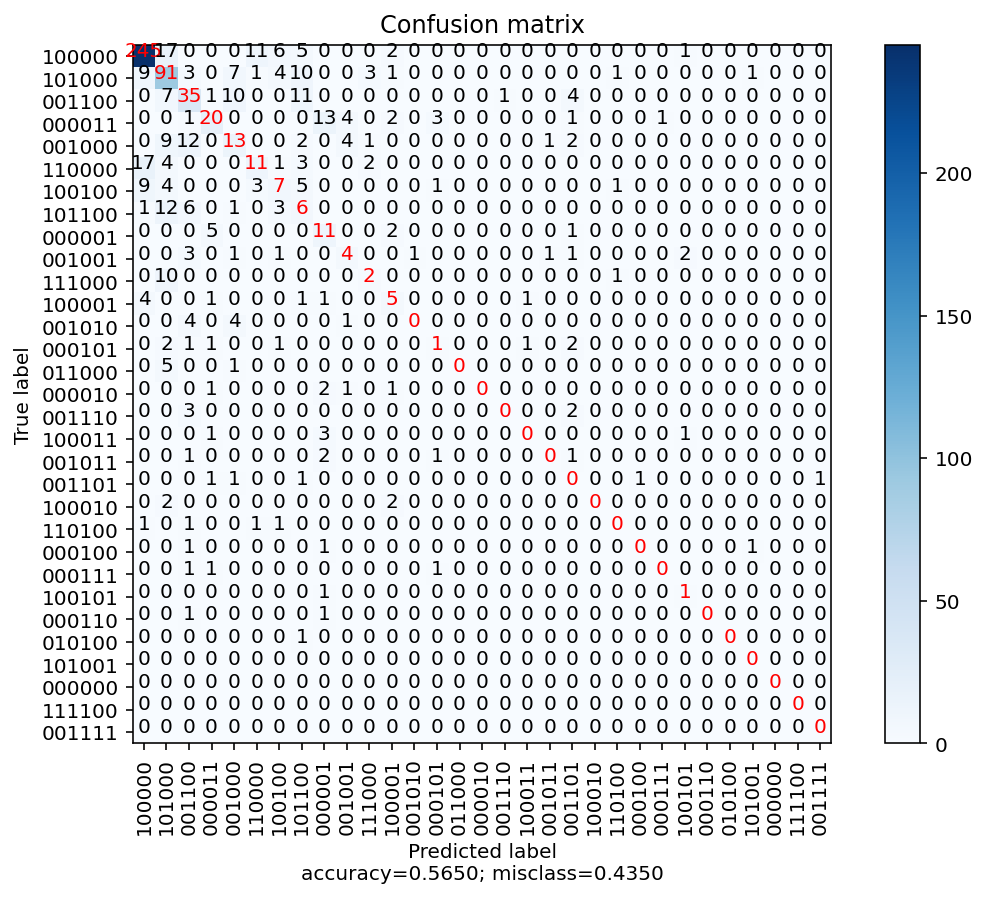

In [ ]:
exp_hier_files = []
for fold_num in range(4):
    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_coarse')
    exp_hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/stats-deberta-hier-explanations/metrics_deberta_hierarchical_explanations_concat_test.json_fold'+str(fold_num)+'_test_fine')
    # exp_hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_explanations_concat_test.json_fold'+str(fold_num)+'_test_fine')
    # hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
exp_hier_ids, exp_hier_targets, exp_hier_preds, exp_hier_coarse_targets, exp_hier_coarse_preds, _ = get_confusion_matrix(exp_hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(exp_hier_targets, exp_hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.93339916, 0.3322675 , 0.86624465, 0.60200813, 0.34514812,
       0.79507295])

In [ ]:
f1_hier_scores = []
for fold_targets, fold_preds in zip(exp_hier_targets, exp_hier_preds):
    f1_hier_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_hier_scores)
np.mean(np.array(f1_hier_scores))

Fold scores [0.6577133462495618, 0.5654329174444116, 0.6993041301733971, 0.6603099469085869]


0.6456900851939893

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(exp_hier_coarse_targets, exp_hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.93825206, 0.88437898, 0.80927014])

In [ ]:

# from itertools import chain 

for fold in [0, 1, 2, 3]:
  preds = set([''.join(map(str, x)) for x in exp_hier_coarse_preds[fold]])
  print(preds)
# len(exp_hier_coarse_preds[3]), len(exp_hier_coarse_targets[3])

# preds

{'110', '111', '011', '010', '001', '101', '100'}
{'100'}
{'110', '011', '010', '100'}
{'100'}


### Question

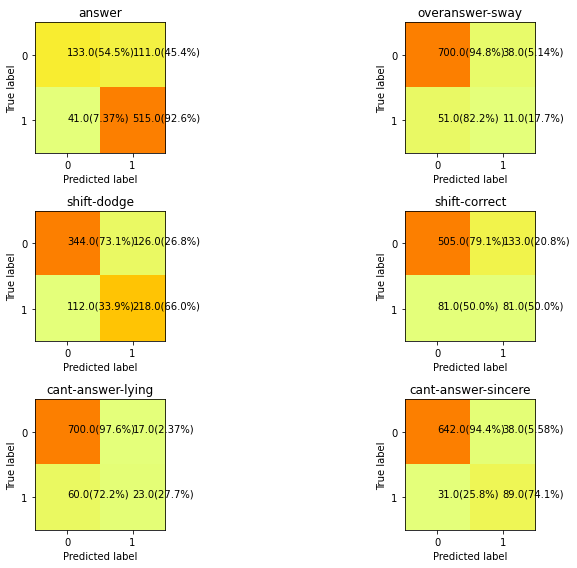

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 1, 1, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [1, 0, 0, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

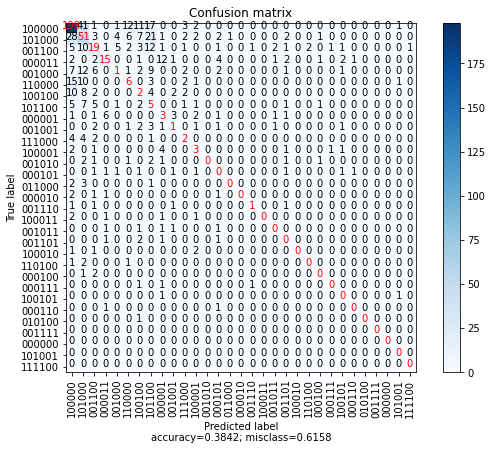

In [ ]:
last_q_files = []
for fold_num in range(4):
  
    last_q_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_q_text_last_question_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # last_q_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/2_input/metrics_roberta_hierarchical_q_text_first_question_and_rest_r_text_test.json_fold'+str(fold_num)+'_test_fine')
last_q_ids, last_q_targets, last_q_preds, last_q_coarse_targets, last_q_coarse_preds, _ = get_confusion_matrix(last_q_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(last_q_targets, last_q_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.87041205, 0.19833333, 0.64418349, 0.4351163 , 0.40106732,
       0.72408964])

In [ ]:
f1_hier_qs_scores = []
for fold_targets, fold_preds in zip(last_q_targets, last_q_preds):
    f1_hier_qs_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_hier_qs_scores)
np.mean(np.array(f1_hier_qs_scores))

Fold scores [0.4729705215419502, 0.5479249901323886, 0.575089123167016, 0.5861501269750874]


0.5455336904541105

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(last_q_coarse_targets, last_q_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.87797169, 0.7304992 , 0.74575595])

In [ ]:
all_class_labels = []
all_last_q_ids = []
all_last_q_targets = []
all_last_q_preds = []
for fold in range(len(last_q_ids)):
    all_class_labels.append(class_labels*(len(last_q_ids[fold])))
    all_last_q_ids.append(list(itertools.chain.from_iterable(last_q_ids[fold])))
    all_last_q_targets.append(list(itertools.chain.from_iterable(last_q_targets[fold])))
    all_last_q_preds.append(list(itertools.chain.from_iterable(last_q_preds[fold])))
last_q_dfs = []
for fold in range(len(last_q_ids)):
    last_q_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_last_q_ids[fold], all_last_q_targets[fold], all_last_q_preds[fold]), columns=['label','qa_index','gold','pred']))
    last_q_dfs[fold]['correct'] = last_q_dfs[fold]['gold']==last_q_dfs[fold]['pred']
    last_q_dfs[fold]['uid'] = last_q_dfs[fold]['label']+'_'+last_q_dfs[fold]['qa_index'].astype(str)
merged_last_q_dfs = []
for fold in range(len(last_q_dfs)):
    merged_last_q_dfs.append(hier_dfs[fold].merge(last_q_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_last_q')))

In [ ]:
incorrect_lastq_cantans_qas = []
for fold in range(len(merged_last_q_dfs)):
    print('Fold', fold)
    merged_last_q_dfs[fold]['hearing_id'] = merged_last_q_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['hearing_id'].value_counts())
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['label_hier_base'].value_counts())
    incorrect_lastq_cantans_qas.extend(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==True) & (merged_last_q_dfs[fold]['label_hier_base'].str.startswith('cant-answer')) & (merged_last_q_dfs[fold]['correct_hier_last_q']==False)]['qa_index_hier_base'])

Fold 0


11636001    26
11422125    13
11531504     8
11637282     5
Name: hearing_id, dtype: int64

shift-correct          15
shift-dodge            13
cant-answer-sincere     8
answer                  8
cant-answer-lying       6
overanswer-sway         2
Name: label_hier_base, dtype: int64

Fold 1


11420722    20
11530242    17
11426003    14
11386195    13
Name: hearing_id, dtype: int64

shift-correct          23
shift-dodge            15
answer                 10
cant-answer-sincere     6
cant-answer-lying       5
overanswer-sway         5
Name: label_hier_base, dtype: int64

Fold 2


11532380    24
11635589    20
11393834     9
11531349     9
Name: hearing_id, dtype: int64

shift-dodge            20
shift-correct          16
overanswer-sway        14
cant-answer-sincere     6
answer                  4
cant-answer-lying       2
Name: label_hier_base, dtype: int64

Fold 3


11495063    17
11497630    15
11530956    10
11635230     9
Name: hearing_id, dtype: int64

shift-dodge            15
shift-correct          14
overanswer-sway        10
answer                  4
cant-answer-lying       4
cant-answer-sincere     4
Name: label_hier_base, dtype: int64

In [22]:
# incorrect_lastq_cantans_qas

## Explanations

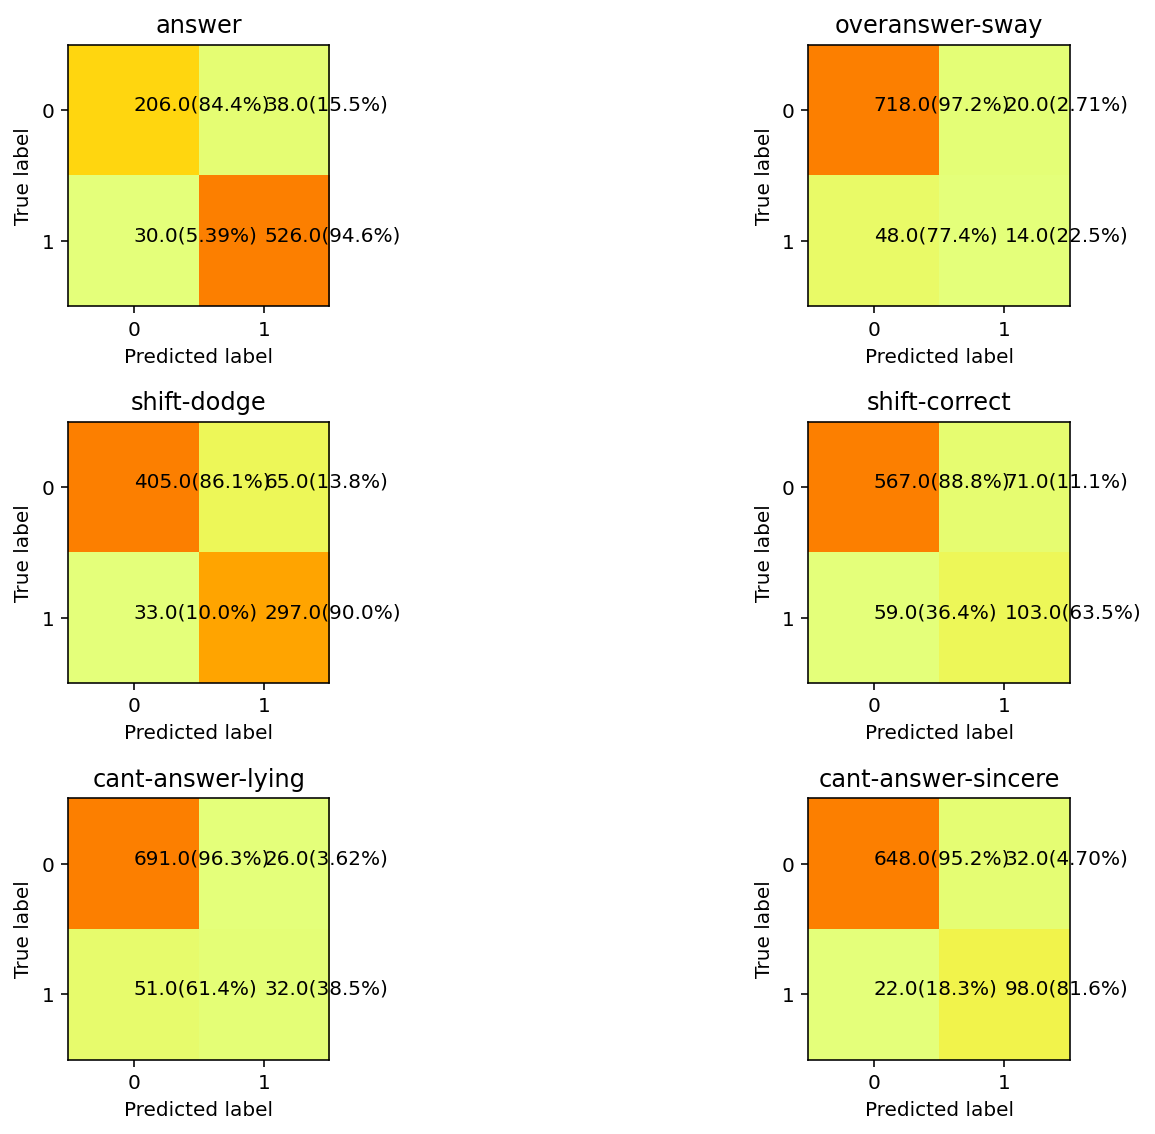

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

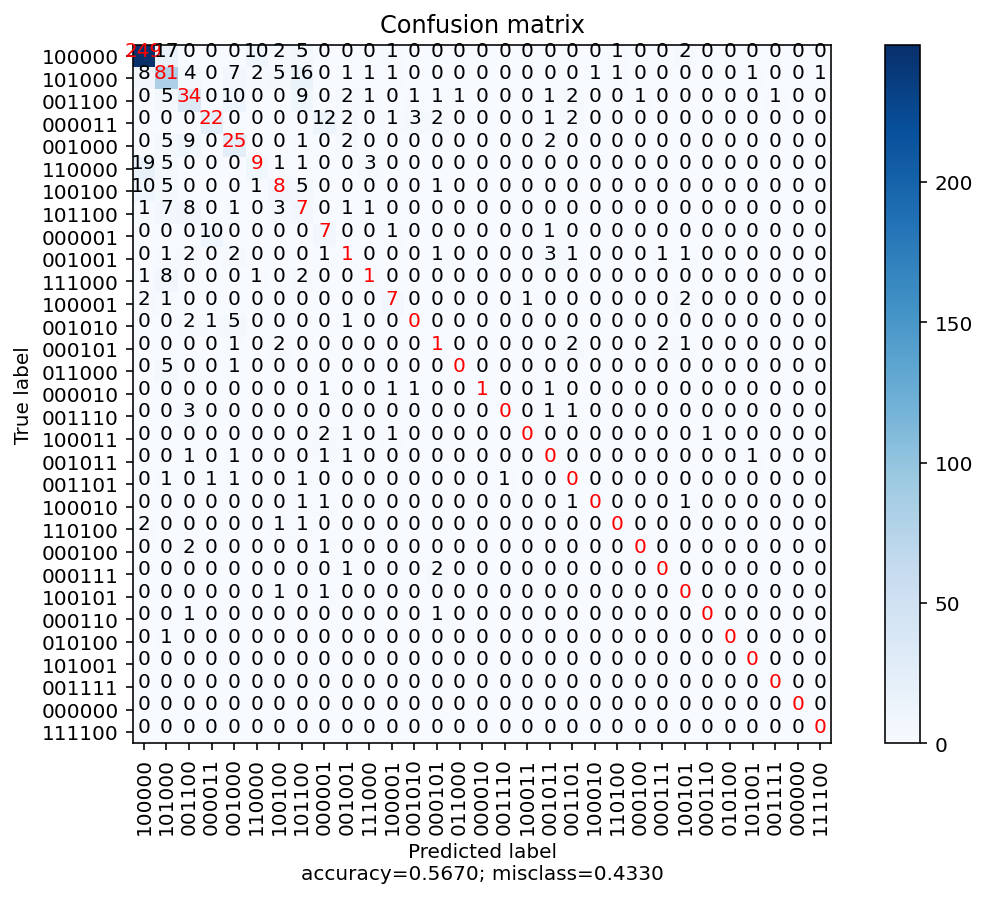

In [ ]:
explanation_hier_files = []
for fold_num in range(4):
    # hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_coarse')
    explanation_hier_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
explanation_hier_ids, explanation_hier_targets, explanation_hier_preds, explanation_hier_coarse_targets, explanation_hier_coarse_preds, _ = get_confusion_matrix(explanation_hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
all_explanation_class_labels = []
all_explanation_hier_ids = []
all_explanation_hier_targets = []
all_explanation_hier_preds = []
for fold in range(len(explanation_hier_ids)):
    all_explanation_class_labels.append(class_labels*(len(explanation_hier_ids[fold])))
    all_explanation_hier_ids.append(list(itertools.chain.from_iterable(explanation_hier_ids[fold])))
    all_explanation_hier_targets.append(list(itertools.chain.from_iterable(explanation_hier_targets[fold])))
    all_explanation_hier_preds.append(list(itertools.chain.from_iterable(explanation_hier_preds[fold])))
explanation_hier_dfs=[]
for fold in range(len(explanation_hier_ids)):
    explanation_hier_dfs.append(pd.DataFrame(zip(all_explanation_class_labels[fold], all_explanation_hier_ids[fold], all_explanation_hier_targets[fold], all_explanation_hier_preds[fold]), columns=['label','qa_index','gold','pred']))
    explanation_hier_dfs[fold]['correct'] = explanation_hier_dfs[fold]['gold']==explanation_hier_dfs[fold]['pred']
    explanation_hier_dfs[fold]['uid'] = explanation_hier_dfs[fold]['label']+'_'+explanation_hier_dfs[fold]['qa_index'].astype(str)

In [ ]:
incorrect_explanation_hier_qas=[]
for fold in range(4):
    incorrect_explanation_hier_qas.extend(explanation_hier_dfs[fold][explanation_hier_dfs[fold]['correct']==False]['qa_index'].values)

In [ ]:
f1_scores = []
for fold_targets, fold_preds in zip(explanation_hier_targets, explanation_hier_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_scores)
np.mean(np.array(f1_scores))

Fold scores [0.665204630377104, 0.5798441467153418, 0.6282661975519118, 0.7361991238360827]


0.65237852462011

In [1]:
analyse_hier('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold')

NameError: ignored

## Sentiment

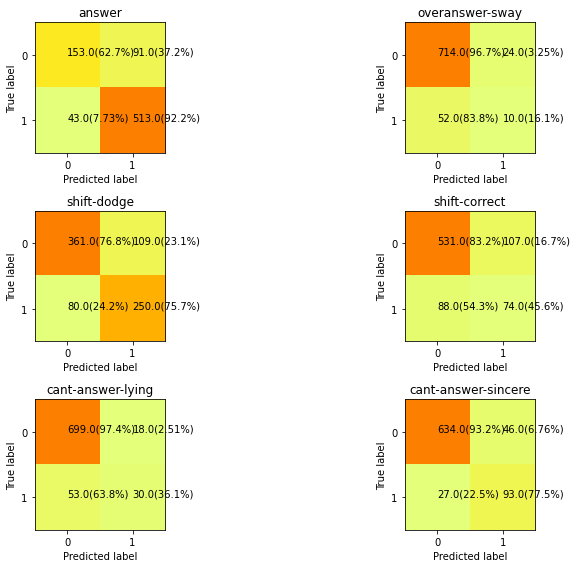

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 1, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 1, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

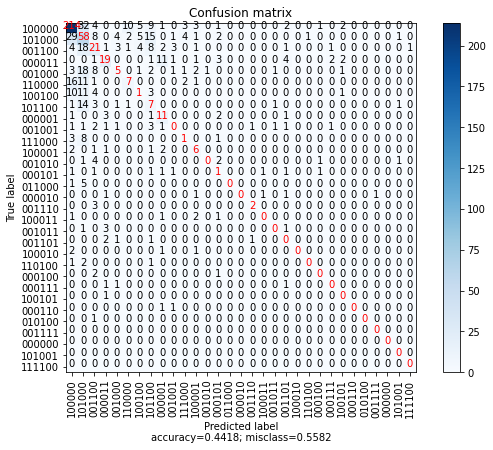

In [ ]:
sent_files = []
for fold_num in range(4):
    sent_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    # sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
sent_course_files = []
for fold_num in range(4):
    sent_course_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_coarse')
    # sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_coarse_confusion_matrix(sent_files, is_fine=False, all_label_sets_ordered=base_targets_ordered)

KeyError: ignored

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.88366731, 0.20872326, 0.72275593, 0.42715594, 0.46970078,
       0.71505546])

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(sent_coarse_targets, sent_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.88869466, 0.77892407, 0.75623092])

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_class_scores)
np.mean(np.array(f1_class_scores))

Fold scores [0.5682845311487488, 0.5341243853180603, 0.5541979416505391, 0.6280989194915015]


0.5711764444022125

In [ ]:
all_class_labels = []
all_sent_ids = []
all_sent_targets = []
all_sent_preds = []
all_sent_coarse_targets = []
all_sent_coarse_preds = []
for fold in range(len(sent_ids)):
    all_class_labels.append(class_labels*(len(sent_ids[fold])))
    all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
    all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
    all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
    all_sent_coarse_targets.append(list(itertools.chain.from_iterable(sent_coarse_targets[fold])))
    all_sent_coarse_preds.append(list(itertools.chain.from_iterable(sent_coarse_preds[fold])))
sent_dfs = []


for fold in range(len(sent_ids)):
    sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold], all_sent_coarse_targets[fold], all_sent_coarse_preds[fold]), columns=['label','qa_index','gold','pred', 'coarse_gold', 'coarse_pred']))
    sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
    sent_dfs[fold]['coarse_correct'] = sent_dfs[fold]['coarse_gold']==sent_dfs[fold]['coarse_pred']
    sent_dfs
    sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
merged_sent_dfs = []
for fold in range(len(sent_dfs)):
    merged_sent_dfs.append(hier_dfs[fold].merge(sent_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent')))

In [ ]:
for fold in range(len(merged_sent_dfs)):
    print('Fold', fold)
    merged_sent_dfs[fold]['hearing_id'] = merged_sent_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['hearing_id'].value_counts())
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['label_hier_base'].value_counts())

Fold 0


11636001    22
11422125    10
11531504     4
11637282     3
Name: hearing_id, dtype: int64

shift-dodge            14
shift-correct          11
cant-answer-sincere     5
answer                  5
cant-answer-lying       4
Name: label_hier_base, dtype: int64

Fold 1


11530242    12
11420722    10
11426003     7
11386195     2
Name: hearing_id, dtype: int64

shift-correct          14
shift-dodge             6
answer                  5
overanswer-sway         3
cant-answer-sincere     2
cant-answer-lying       1
Name: label_hier_base, dtype: int64

Fold 2


11635589    15
11532380    12
11393834     8
11531349     6
Name: hearing_id, dtype: int64

shift-dodge            16
shift-correct          10
overanswer-sway         7
answer                  5
cant-answer-lying       2
cant-answer-sincere     1
Name: label_hier_base, dtype: int64

Fold 3


11497630    9
11635230    5
11530956    5
11495063    4
Name: hearing_id, dtype: int64

shift-dodge            9
shift-correct          5
answer                 3
overanswer-sway        3
cant-answer-lying      2
cant-answer-sincere    1
Name: label_hier_base, dtype: int64

In [ ]:
fold=0
qa_indices = merged_sent_dfs[fold][(merged_sent_dfs[fold]['label_hier_base']=='shift-dodge')&(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['qa_index_hier_base'].values

In [ ]:
fold=0
merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==True) & (merged_sent_dfs[fold]['correct_hier_sent']==False)]['qa_index_hier_base'].shape
# iqa_indices = merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==True) & (merged_sent_dfs[fold]['correct_hier_sent']==False)]['qa_index_hier_base'].values
# merged_sent_dfs[fold][(merged_sent_dfs[fold]['qa_index_hier_base'].isin(iqa_indices))&(merged_sent_dfs[fold]['correct_hier_base']==False)][['label_hier_base','qa_index_hier_base','gold_hier_base','pred_hier_base','gold_hier_sent', 'pred_hier_sent', 'correct_hier_base']]

(31,)

In [ ]:
fold=0
# merged_sent_dfs[fold].shape
# Comparing coarse with fine classifications

merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_sent']==True) & (merged_sent_dfs[fold]['coarse_correct']==True)]['qa_index_hier_base'].shape
merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_sent']==True) & (merged_sent_dfs[fold]['coarse_correct']==False)]['qa_index_hier_base'].shape
merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_dfs[fold]['coarse_correct']==True)]['qa_index_hier_base'].shape
merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_dfs[fold]['coarse_correct']==False)]['qa_index_hier_base'].shape

(13,)

In [ ]:
fold = 0
# hier_base_group = merged_sent_dfs[fold].groupby('qa_index_hier_base').aggregate({'correct_hier_sent': 'sum'}).filter(lambda x: x['correct_hier_sum'] < 6)
# hier_base_group.where(hier_base_group.['correct_hier_sent'] < 6)

merged_sent_dfs[fold]['correct_hier_sent_int'] = merged_sent_dfs[fold]['correct_hier_sent'].astype(int) 

hier_base_group = merged_sent_dfs[fold].groupby('qa_index_hier_base').filter(lambda x: x['correct_hier_sent_int'].sum() < 6)
# aggregate({'correct_hier_sent': 'sum'}).filter(lambda x: x['correct_hier_sum'] < 6)

# hier_base_group.groupby('qa_index_hier_base').aggregate({'correct_hier_sent_int': 'sum'})
merged_sent_dfs[fold].groupby('qa_index_hier_base').aggregate({'correct_hier_sent_int': 'sum'}).value_counts()
# merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base'] == 11422125039] #== 11422125032] #11422125004] # 11422125002]



correct_hier_sent_int
6                        42
5                        29
4                        19
3                         6
2                         4
dtype: int64

In [ ]:
sent_df = pd.concat([merged_sent_dfs[0], merged_sent_dfs[1], merged_sent_dfs[2], merged_sent_dfs[3]], axis=0)
# hier_sent_df = sent_df.groupby('qa_index_hier_base').filter(lambda x: x['correct_hier_sent_int'].sum() < 6)
# aggregate({'correct_hier_sent': 'sum'}).filter(lambda x: x['correct_hier_sum'] < 6)
sent_df['correct_hier_sent_int'] = sent_df['correct_hier_sent'].astype(int)
sent_df['correct_hier_base_int'] = sent_df['correct_hier_base'].astype(int)
# hier_base_group.groupby('qa_index_hier_base').aggregate({'correct_hier_sent_int': 'sum'})
sent_df.groupby('qa_index_hier_base').aggregate({'correct_hier_sent_int': 'sum'}).value_counts()
# merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base'] == 11422125039] #== 11422125032] #11422125004] # 11422125002]
# sent_df.groupby('qa_index_hier_base').filter(lambda x: x['correct_hier_sent_int'].sum() < 6 and x['gold_hier_sent'].sum() > 2)

res = []
res_count = []
res2 = []
for i in range(1, 4):
  curr_res = []
  curr_res2 = []
  curr_res_sum = []
  total = sent_df.groupby('qa_index_hier_base').filter(lambda x: x['gold_hier_sent'].sum() == i ).shape[0]/6
  print(total)
  for j in range(1, 7):
    curr_count = sent_df.groupby('qa_index_hier_base').filter(lambda x: x['gold_hier_sent'].sum() == i and x['correct_hier_sent_int'].sum() == j).shape[0]/6
    curr_count2 = sent_df.groupby('qa_index_hier_base').filter(lambda x: x['gold_hier_sent'].sum() == i and x['correct_hier_base_int'].sum() == j).shape[0]/6
    curr_res.append(curr_count/total)
    curr_res2.append(curr_count2/total)
    curr_res_sum.append(curr_count)
  # print()
  res_count.append(curr_res_sum)
  res2.append(curr_res2)
  res.append(curr_res)
# sent_df.groupby('qa_index_hier_base').filter(lambda x: x['gold_hier_sent'].sum() > 1 and x['correct_hier_sent_int'].sum() < 6)
# sent_df[sent_df['qa_index_hier_base'] == 11636001100]

res2

173.0
194.0
33.0


[[0.0,
  0.005780346820809248,
  0.023121387283236993,
  0.10404624277456648,
  0.2832369942196532,
  0.5838150289017341],
 [0.0,
  0.03608247422680412,
  0.0979381443298969,
  0.2422680412371134,
  0.36082474226804123,
  0.26288659793814434],
 [0.0,
  0.0,
  0.21212121212121213,
  0.36363636363636365,
  0.36363636363636365,
  0.06060606060606061]]

In [ ]:
res

[[0.0,
  0.011560693641618497,
  0.03468208092485549,
  0.057803468208092484,
  0.30057803468208094,
  0.5953757225433526],
 [0.005154639175257732,
  0.03608247422680412,
  0.061855670103092786,
  0.26288659793814434,
  0.32989690721649484,
  0.30412371134020616],
 [0.0,
  0.06060606060606061,
  0.09090909090909091,
  0.24242424242424243,
  0.45454545454545453,
  0.15151515151515152]]

In [ ]:
res_count

[[1.0, 11.0, 21.0, 69.0, 131.0, 167.0],
 [1.0, 9.0, 15.0, 59.0, 79.0, 64.0],
 [0.0, 2.0, 3.0, 8.0, 15.0, 5.0]]

In [ ]:
sent_df['correct_hier_base_int'] = sent_df['correct_hier_base'].astype(int)

sent_df.groupby('qa_index_hier_base').filter(lambda x: x['correct_hier_base_int'].sum() >  x['correct_hier_sent_int'].sum() and x['correct_hier_base_int'].sum() == 6).shape

NameError: ignored

In [ ]:
sent_df.groupby('qa_index_hier_base').filter(lambda x: x['gold_hier_sent'].sum() > 2 and x['correct_hier_sent_int'].sum() < 5)

label_hier_base  qa_index_hier_base  gold_hier_base  pred_hier_base  \
66                answer         11422125138               1               0   
67       overanswer-sway         11422125138               0               0   
68           shift-dodge         11422125138               0               0   
69         shift-correct         11422125138               0               1   
70     cant-answer-lying         11422125138               1               0   
71   cant-answer-sincere         11422125138               1               1   
222               answer         11530242009               1               1   
223      overanswer-sway         11530242009               1               0   
224          shift-dodge         11530242009               1               0   
225        shift-correct         11530242009               0               0   
226    cant-answer-lying         11530242009               0               0   
227  cant-answer-sincere         11530242009               0               0   
288               answer         11420722094               1               0   
289      overanswer-sway         11420722094               0               0   
290          shift-dodge         11420722094               1               1   
291        shift-correct         11420722094               1               1   
292    cant-answer-lying         11420722094               0               0   
293  cant-answer-sincere         11420722094               0               0   
366               answer         11420722153               1               0   
367      overanswer-sway         11420722153               0               0   
368          shift-dodge         11420722153               0               0   
369        shift-correct         11420722153               1               0   
370    cant-answer-lying         11420722153               0               1   
371  cant-answer-sincere         11420722153               1               1   
528               answer         11420722133               1               0   
529      overanswer-sway         11420722133               0               0   
530          shift-dodge         11420722133               1               1   
531        shift-correct         11420722133               1               1   
532    cant-answer-lying         11420722133               0               0   
533  cant-answer-sincere         11420722133               0               1   
552               answer         11426003101               1               1   
553      overanswer-sway         11426003101               1               0   
554          shift-dodge         11426003101               1               0   
555        shift-correct         11426003101               0               0   
556    cant-answer-lying         11426003101               0               0   
557  cant-answer-sincere         11426003101               0               0   
564               answer         11386195158               1               1   
565      overanswer-sway         11386195158               0               0   
566          shift-dodge         11386195158               1               0   
567        shift-correct         11386195158               1               0   
568    cant-answer-lying         11386195158               0               0   
569  cant-answer-sincere         11386195158               0               0   
558               answer         11635589054               0               1   
559      overanswer-sway         11635589054               0               0   
560          shift-dodge         11635589054               0               0   
561        shift-correct         11635589054               1               1   
562    cant-answer-lying         11635589054               1               0   
563  cant-answer-sincere         11635589054               1               0   
564               answer         11635589159               0               1   
565      

In [ ]:
sent_df[sent_df['qa_index_hier_base'] == 11497630130]

label_hier_base  qa_index_hier_base  gold_hier_base  pred_hier_base  \
144               answer         11497630130               1               0   
145      overanswer-sway         11497630130               0               0   
146          shift-dodge         11497630130               1               1   
147        shift-correct         11497630130               1               1   
148    cant-answer-lying         11497630130               0               0   
149  cant-answer-sincere         11497630130               0               0   

     correct_hier_base                              uid      label_hier_sent  \
144              False               answer_11497630130               answer   
145               True      overanswer-sway_11497630130      overanswer-sway   
146               True          shift-dodge_11497630130          shift-dodge   
147               True        shift-correct_11497630130        shift-correct   
148               True    cant-answer-lying_11497630130    cant-answer-lying   
149               True  cant-answer-sincere_11497630130  cant-answer-sincere   

     qa_index_hier_sent  gold_hier_sent  pred_hier_sent  coarse_gold  \
144         11497630130               1               0            1   
145         11497630130               0               0            0   
146         11497630130               1               1            0   
147         11497630130               1               0            1   
148         11497630130               0               0            0   
149         11497630130               0               0            0   

     coarse_pred  correct_hier_sent  coarse_correct hearing_id  \
144            1              False            True   11497630   
145            0               True            True   11497630   
146            0               True            True   11497630   
147            1              False            True   11497630   
148            0               True            True   11497630   
149            0               True            True   11497630   

     correct_hier_sent_int  correct_hier_base_int  
144                      0                      0  
145                      1                      1  
146                      1                      1  
147                      0                      1  
148                      1                      1  
149                      1                      1

In [ ]:
fold = 0
# hier_base_group = merged_sent_dfs[fold].groupby('qa_index_hier_base').aggregate({'correct_hier_sent': 'sum'}).filter(lambda x: x['correct_hier_sum'] < 6)
# hier_base_group.where(hier_base_group.['correct_hier_sent'] < 6)

# merged_sent_dfs[fold]['correct_hier_sent_int'] = merged_sent_dfs[fold]['correct_hier_sent'].astype(int) 

hier_base_group = merged_sent_dfs[fold].groupby('qa_index_hier_sent').filter(lambda x: x['correct_hier_sent_int'].sum() < 6)
# aggregate({'correct_hier_sent': 'sum'}).filter(lambda x: x['correct_hier_sum'] < 6)

# hier_base_group.groupby('qa_index_hier_base').aggregate({'correct_hier_sent_int': 'sum'})
merged_sent_dfs[fold].groupby('qa_index_hier_sent').aggregate({'correct_hier_sent_int': 'sum'}).value_counts()
# merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base'] == 11422125039] #== 11422125032] #11422125004] # 11422125002]

# merged_sent_dfs[fold].shape

(600, 16)

In [ ]:
merged_sent_dfs[fold][(merged_sent_dfs[fold]['qa_index_hier_base'].isin(qa_indices))&(merged_sent_dfs[fold]['correct_hier_base']==False)][['label_hier_base','qa_index_hier_base','gold_hier_base','pred_hier_base','pred_hier_sent']]

label_hier_base  qa_index_hier_base  gold_hier_base  pred_hier_base  \
128           shift-dodge         11636001012               1               0   
130     cant-answer-lying         11636001012               1               0   
134           shift-dodge         11422125012               0               1   
146           shift-dodge         11422125073               0               1   
242           shift-dodge         11636001137               1               0   
245   cant-answer-sincere         11636001137               0               1   
265       overanswer-sway         11636001069               1               0   
266           shift-dodge         11636001069               0               1   
269   cant-answer-sincere         11636001069               0               1   
296           shift-dodge         11637282108               0               1   
314           shift-dodge         11422125144               0               1   
315         shift-correct         11422125144               1               0   
337       overanswer-sway         11422125089               1               0   
338           shift-dodge         11422125089               0               1   
402                answer         11636001073               1               0   
404           shift-dodge         11636001073               0               1   
405         shift-correct         11636001073               0               1   
407   cant-answer-sincere         11636001073               0               1   
426                answer         11636001094               0               1   
428           shift-dodge         11636001094               1               0   
440           shift-dodge         11637282126               0               1   
476           shift-dodge         11422125075               0               1   
530           shift-dodge         11636001075               0               1   
531         shift-correct         11636001075               0               1   
560           shift-dodge         11422125026               0               1   
625       overanswer-sway         11531504043               1               0   
626           shift-dodge         11531504043               0               1   
636                answer         11531504064               0               1   
638           shift-dodge         11531504064               0               1   
640     cant-answer-lying         11531504064               1               0   
641   cant-answer-sincere         11531504064               1               0   
776           shift-dodge         11422125045               0               1   
848           shift-dodge         11422125087               0               1   
974           shift-dodge         11636001121               1               0   
976     cant-answer-lying         11636001121               0               1   
1004          shift-dodge         11637282091               0               1   
1005        shift-correct         11637282091               0               1   
1058          shift-dodge         11636001088               1               0   
1061  cant-answer-sincere         11636001088               0               1   
1070          shift-dodge         11422125014               0               1   
1106          shift-dodge         11422125061               0               1   
1109  cant-answer-sincere         11422125061               0               1   
1111      overanswer-sway         11636001113               1               0   
1112          shift-dodge         11636001113               0               1   
1122               answer         11422125093               1               0   
1124          shift-dodge         11422125093               0               1   
1125        shift-correct         11422125093               0               1   
1126    cant-answer-lying         11422125093               1               0   
1127  cant-answer-sincere         1142212

In [ ]:
fold=3
merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base']==11530956014]

label_hier_base  qa_index_hier_base  gold_hier_base  pred_hier_base  \
462               answer         11530956014               0               0   
463      overanswer-sway         11530956014               0               0   
464          shift-dodge         11530956014               0               0   
465        shift-correct         11530956014               0               1   
466    cant-answer-lying         11530956014               1               0   
467  cant-answer-sincere         11530956014               0               0   

     correct_hier_base                              uid      label_hier_sent  \
462               True               answer_11530956014               answer   
463               True      overanswer-sway_11530956014      overanswer-sway   
464               True          shift-dodge_11530956014          shift-dodge   
465              False        shift-correct_11530956014        shift-correct   
466              False    cant-answer-lying_11530956014    cant-answer-lying   
467               True  cant-answer-sincere_11530956014  cant-answer-sincere   

     qa_index_hier_sent  gold_hier_sent  pred_hier_sent  correct_hier_sent  \
462         11530956014               0               0               True   
463         11530956014               0               0               True   
464         11530956014               0               1              False   
465         11530956014               0               1              False   
466         11530956014               1               0              False   
467         11530956014               0               1              False   

    hearing_id  
462   11530956  
463   11530956  
464   11530956  
465   11530956  
466   11530956  
467   11530956

In [ ]:
f1_qa_hier_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_qa_hier_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_qa_hier_scores)
np.mean(np.array(f1_qa_hier_scores))

Fold scores [0.5682845311487488, 0.5341243853180603, 0.5541979416505391, 0.6280989194915015]


0.5711764444022125

## Curriculum - Disagreement Index

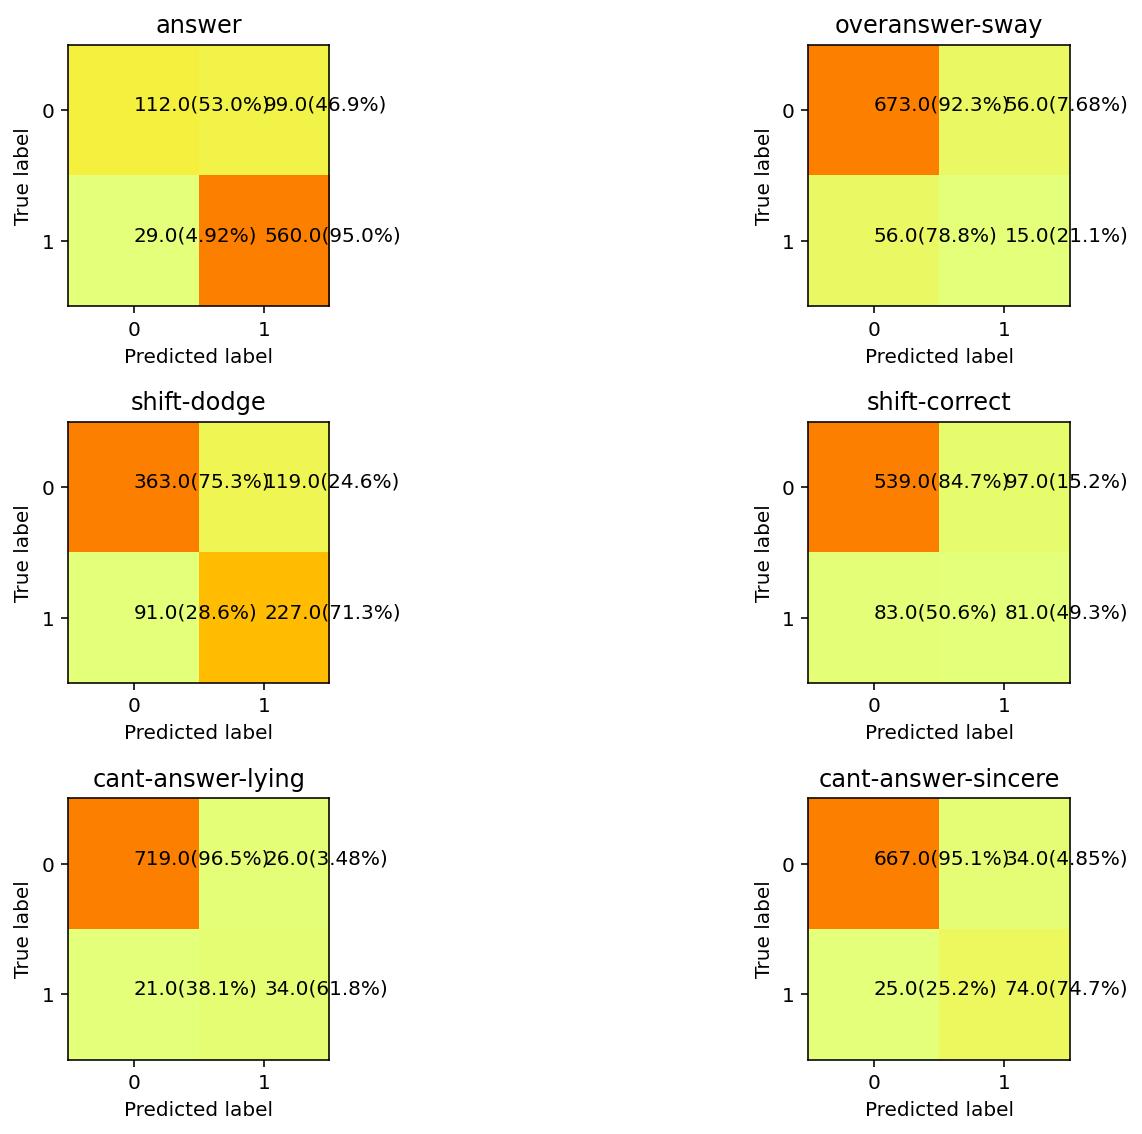

4
id_gold_pred [[11495063129, [1, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11635230123, [0, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11420722113, [1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11389598030, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11393834105, [1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11530956043, [1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349037, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349079, [0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

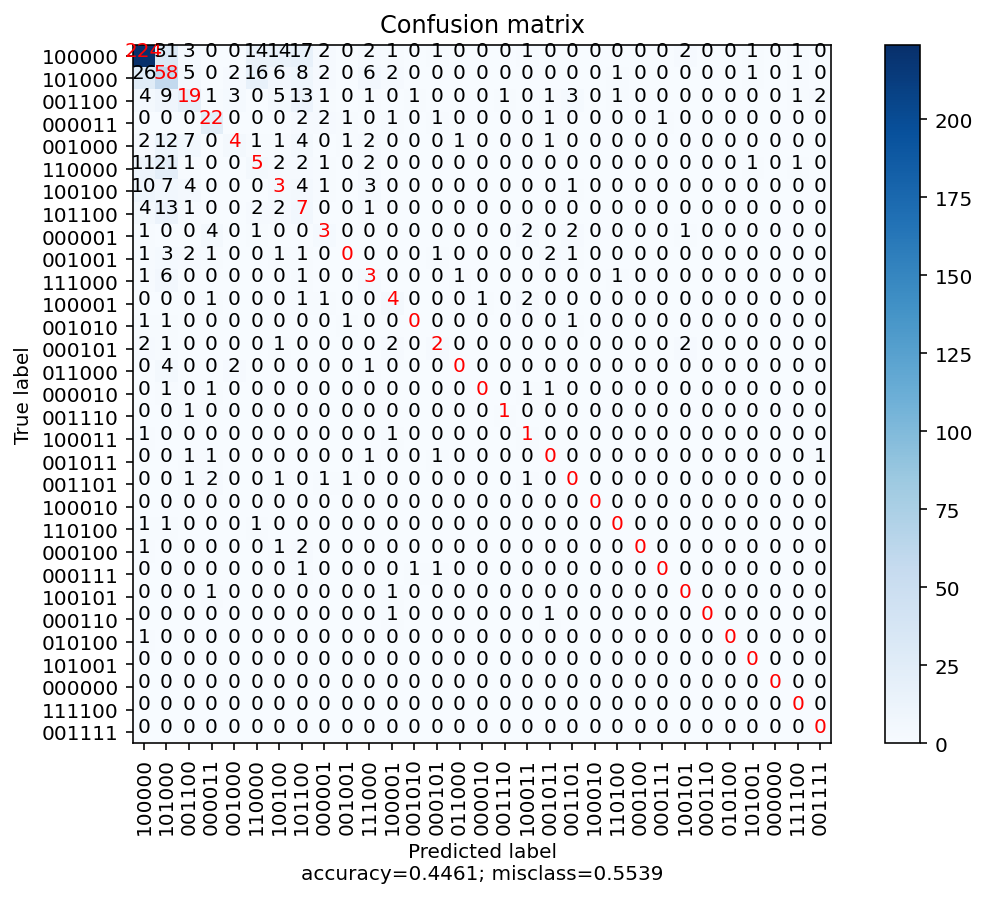

In [13]:
sent_files = []
for fold in range(4):
    # sent_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
    sent_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/curriculum-learning-stage/hard/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test_5_dec.json_fold'+str(fold)+'_test_fine')
    # sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [14]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.89683402, 0.20519472, 0.68263468, 0.47310168, 0.55975643,
       0.71732148])

In [15]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(sent_coarse_targets, sent_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.90085022, 0.73258596, 0.74655435])

In [16]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_class_scores)
np.mean(np.array(f1_class_scores))

Fold scores [0.5822383965701093, 0.6001462657225914, 0.5518204937414721, 0.6223568594104308]


0.5891405038611509

In [58]:
all_class_labels = []
all_sent_ids = []
all_sent_targets = []
all_sent_preds = []
all_sent_coarse_targets = []
all_sent_coarse_preds = []
for fold in range(len(sent_ids)):
    all_class_labels.append(class_labels*(len(sent_ids[fold])))
    all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
    all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
    all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
    # all_sent_coarse_targets.append(list(itertools.chain.from_iterable(sent_coarse_targets[fold])))
    # all_sent_coarse_preds.append(list(itertools.chain.from_iterable(sent_coarse_preds[fold])))
sent_dfs = []


for fold in range(len(sent_ids)):
    sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_dfs[fold]['correct'] = sent_dfs[fold]['gold'] == sent_dfs[fold]['pred']
    # sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
    # sent_dfs[fold]['coarse_correct'] = sent_dfs[fold]['coarse_gold']==sent_dfs[fold]['coarse_pred']
    # sent_dfs
    sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
# merged_sent_dfs = []
# for fold in range(len(sent_dfs)):
#     merged_sent_dfs.append(hier_dfs[fold].merge(sent_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent')))

In [59]:
# for fold in range(len(merged_sent_dfs)):
#     print('Fold', fold)
#     merged_sent_dfs[fold]['hearing_id'] = merged_sent_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
#     display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['hearing_id'].value_counts())
#     display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['label_hier_base'].value_counts())

sent_dfs[0].shape, sent_dfs[1].shape, sent_dfs[2].shape, sent_dfs[3].shape
# len(all_sent_coarse_targets[0])

((1200, 6), (1200, 6), (1200, 6), (1200, 6))

In [64]:
sent_df = pd.concat([sent_dfs[0], sent_dfs[1], sent_dfs[2], sent_dfs[3]], axis=0)
sent_df['correct'] = sent_df['correct'].astype(int)

res = []
for i in range(1, 4):
  curr_res = []
  total = sent_df.groupby('qa_index').filter(lambda x: x['gold'].sum() == i ).shape[0]/6
  print(total)
  for j in range(1, 7):
    curr_count = sent_df.groupby('qa_index').filter(lambda x: x['gold'].sum() == i and x['correct'].sum() == j).shape[0]/6
    curr_res.append(curr_count/total)
  res.append(curr_res)
res  

372.0
360.0
68.0


[[0.0,
  0.0,
  0.024193548387096774,
  0.12096774193548387,
  0.23387096774193547,
  0.6209677419354839],
 [0.005555555555555556,
  0.013888888888888888,
  0.08611111111111111,
  0.28888888888888886,
  0.2916666666666667,
  0.3138888888888889],
 [0.0,
  0.04411764705882353,
  0.14705882352941177,
  0.16176470588235295,
  0.47058823529411764,
  0.17647058823529413]]

In [67]:
def get_disagreement(filename_prefix):
  sent_files = []
  for fold in range(4):
      sent_files.append(filename_prefix+str(fold)+'_test_fine')
  sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)
  all_class_labels = []
  all_sent_ids = []
  all_sent_targets = []
  all_sent_preds = []
  all_sent_coarse_targets = []
  all_sent_coarse_preds = []
  for fold in range(len(sent_ids)):
      all_class_labels.append(class_labels*(len(sent_ids[fold])))
      all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
      all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
      all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
      # all_sent_coarse_targets.append(list(itertools.chain.from_iterable(sent_coarse_targets[fold])))
      # all_sent_coarse_preds.append(list(itertools.chain.from_iterable(sent_coarse_preds[fold])))
  sent_dfs = []


  for fold in range(len(sent_ids)):
      sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold]), columns=['label','qa_index','gold','pred']))
      sent_dfs[fold]['correct'] = sent_dfs[fold]['gold'] == sent_dfs[fold]['pred']
      # sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
      # sent_dfs[fold]['coarse_correct'] = sent_dfs[fold]['coarse_gold']==sent_dfs[fold]['coarse_pred']
      # sent_dfs
      sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
  
  sent_df = pd.concat([sent_dfs[0], sent_dfs[1], sent_dfs[2], sent_dfs[3]], axis=0)
  sent_df['correct'] = sent_df['correct'].astype(int)

  res = []
  for i in range(1, 4):
    curr_res = []
    total = sent_df.groupby('qa_index').filter(lambda x: x['gold'].sum() == i ).shape[0]/6
    print(total)
    for j in range(1, 7):
      curr_count = sent_df.groupby('qa_index').filter(lambda x: x['gold'].sum() == i and x['correct'].sum() == j).shape[0]/6
      curr_res.append(curr_count/total)
    res.append(curr_res)
  return res  

In [69]:
curriculum_files_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/curriculum-learning-stage/hard/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test_5_dec.json_fold'

sentiment_files_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'


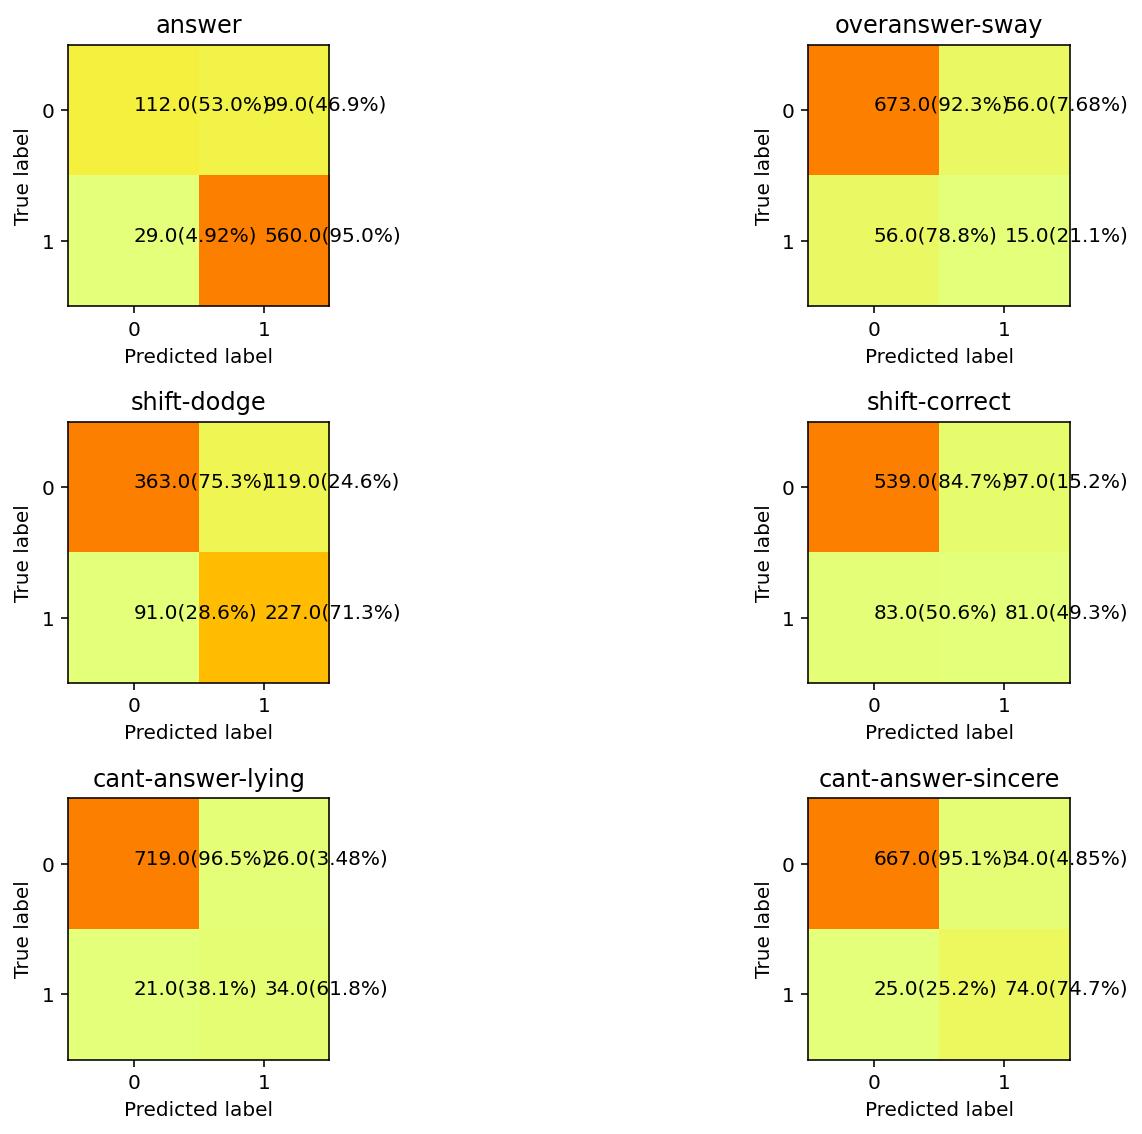

4
id_gold_pred [[11495063129, [1, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11635230123, [0, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11420722113, [1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11389598030, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11393834105, [1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11530956043, [1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349037, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349079, [0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

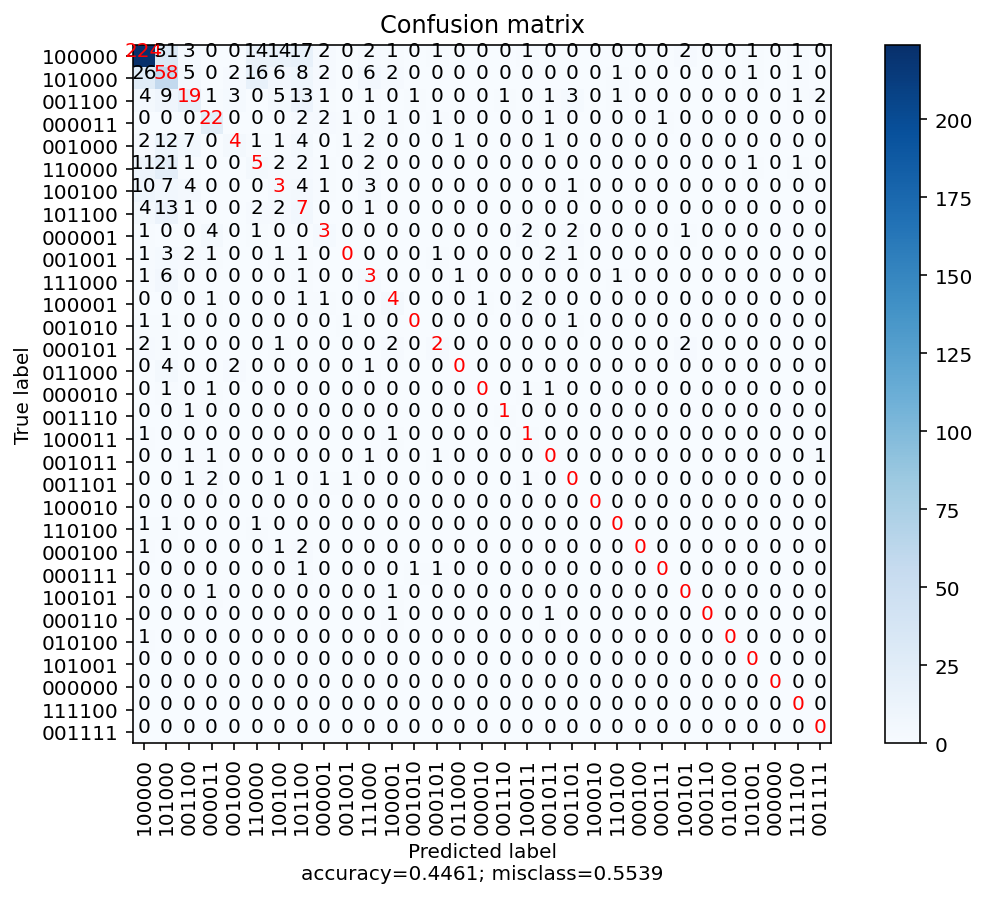

372.0
360.0
68.0


[[0.0,
  0.0,
  0.024193548387096774,
  0.12096774193548387,
  0.23387096774193547,
  0.6209677419354839],
 [0.005555555555555556,
  0.013888888888888888,
  0.08611111111111111,
  0.28888888888888886,
  0.2916666666666667,
  0.3138888888888889],
 [0.0,
  0.04411764705882353,
  0.14705882352941177,
  0.16176470588235295,
  0.47058823529411764,
  0.17647058823529413]]

In [70]:
get_disagreement(curriculum_files_prefix)

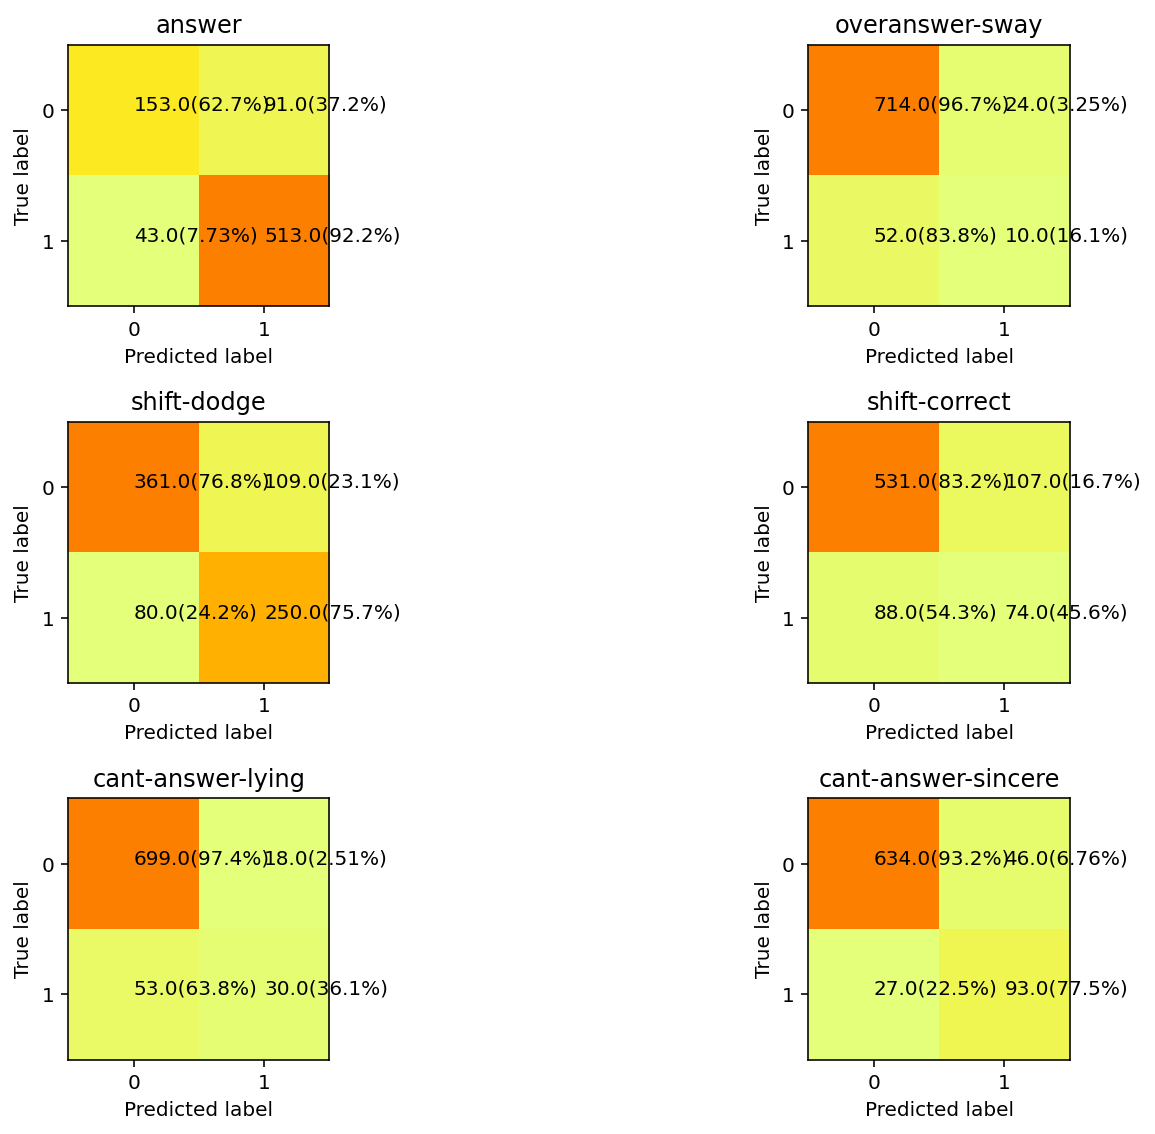

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 1, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 1, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

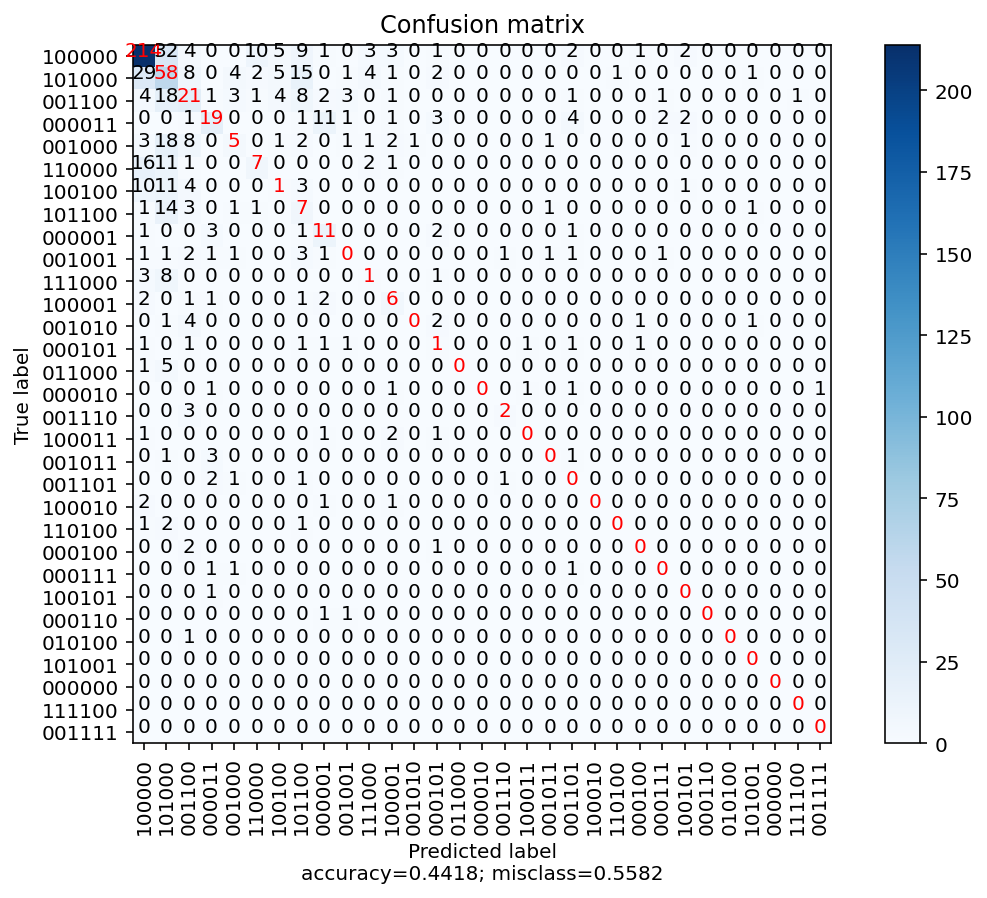

358.0
371.0
71.0


[[0.0,
  0.013966480446927373,
  0.027932960893854747,
  0.07262569832402235,
  0.2430167597765363,
  0.6424581005586593],
 [0.0026954177897574125,
  0.029649595687331536,
  0.07816711590296496,
  0.25336927223719674,
  0.33153638814016173,
  0.3045822102425876],
 [0.014084507042253521,
  0.028169014084507043,
  0.11267605633802817,
  0.2112676056338028,
  0.49295774647887325,
  0.14084507042253522]]

In [71]:
get_disagreement(sentiment_files_prefix)

## Sentiment+Last question

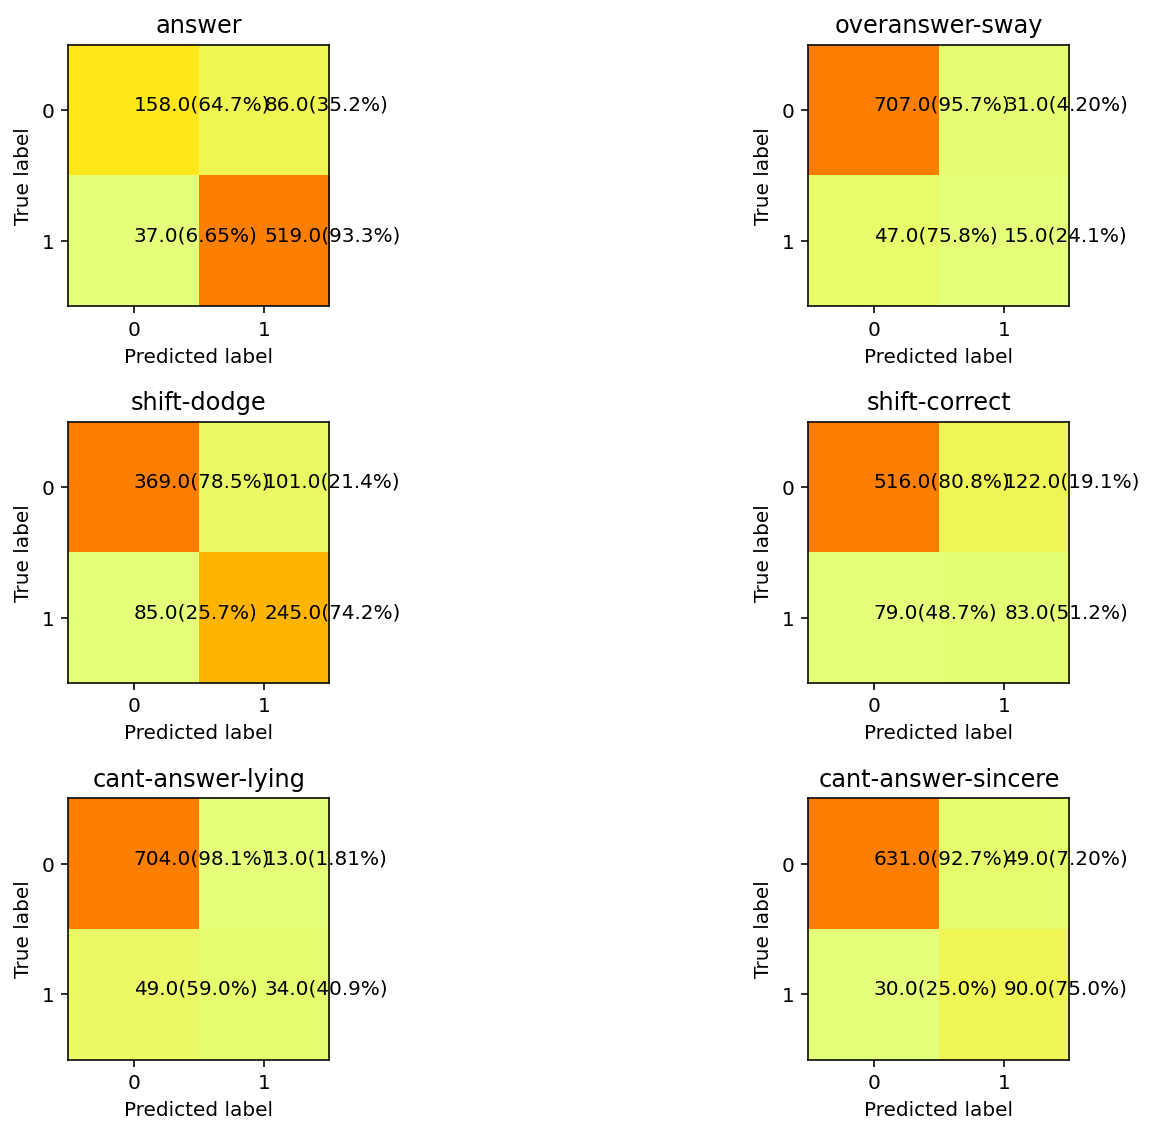

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0,

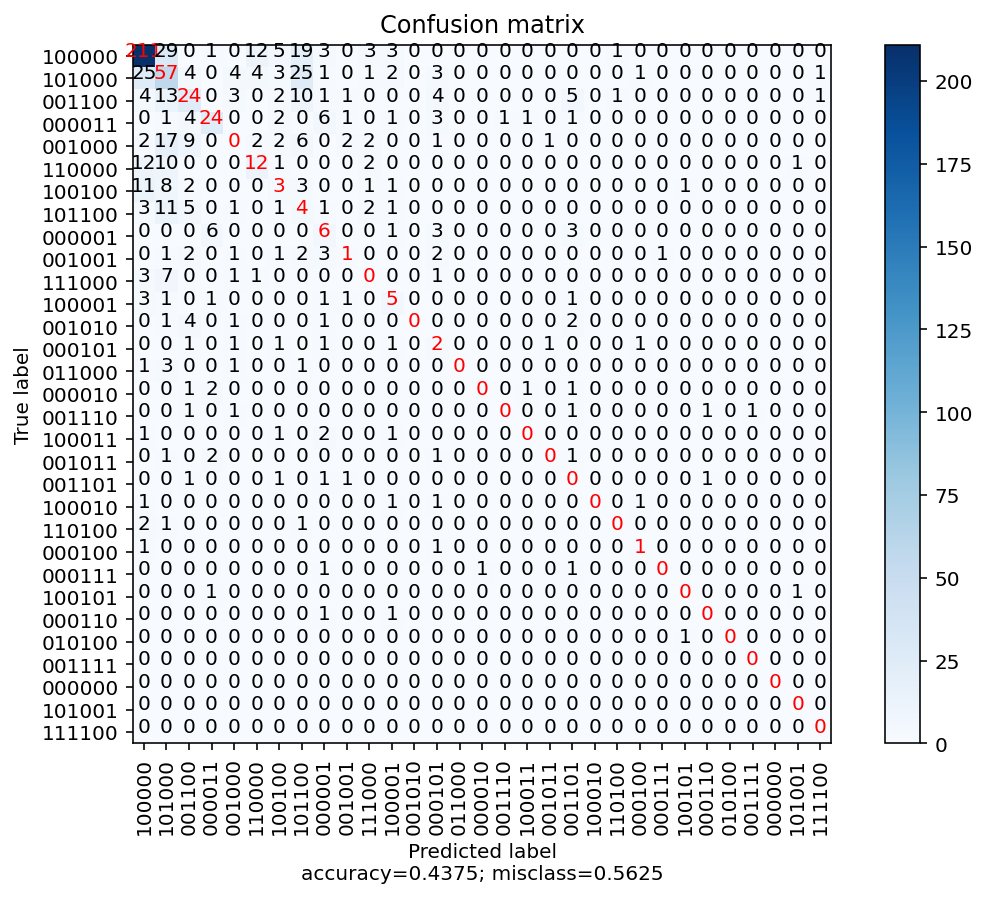

In [ ]:
sent_quest_files = []
for fold_num in range(4):
    sent_quest_files.append('/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/metrics_roberta_hierarchical_r_text_gold_sentiments_coarse_num_q_text_last_question_test.json_fold'+str(fold_num)+'_test_fine')
    # sent_quest_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/3_input/metrics_roberta_hierarchical_r_text_gold_sentiments_coarse_num_q_text_last_question_test.json_fold'+str(fold_num)+'_test_fine')
sent_quest_ids, sent_quest_targets, sent_quest_preds, sent_quest_coarse_targets, sent_quest_coarse_preds, _ = get_confusion_matrix(sent_quest_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
all_class_labels = []
all_sent_quest_ids = []
all_sent_quest_targets = []
all_sent_quest_preds = []
for fold in range(len(sent_quest_ids)):
    all_class_labels.append(class_labels*(len(sent_quest_ids[fold])))
    all_sent_quest_ids.append(list(itertools.chain.from_iterable(sent_quest_ids[fold])))
    all_sent_quest_targets.append(list(itertools.chain.from_iterable(sent_quest_targets[fold])))
    all_sent_quest_preds.append(list(itertools.chain.from_iterable(sent_quest_preds[fold])))
sent_quest_dfs = []
for fold in range(len(sent_quest_ids)):
    sent_quest_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_quest_ids[fold], all_sent_quest_targets[fold], all_sent_quest_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_quest_dfs[fold]['correct'] = sent_quest_dfs[fold]['gold']==sent_quest_dfs[fold]['pred']
    sent_quest_dfs[fold]['uid'] = sent_quest_dfs[fold]['label']+'_'+sent_quest_dfs[fold]['qa_index'].astype(str)
merged_sent_quest_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_dfs.append(hier_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent_quest')))

In [ ]:
for fold in range(len(merged_sent_quest_dfs)):
    print('Fold', fold)
    merged_sent_quest_dfs[fold]['hearing_id'] = merged_sent_quest_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_base'].value_counts())

Fold 0


11422125    20
11636001    20
11531504     8
11637282     7
Name: hearing_id, dtype: int64

shift-dodge            17
shift-correct          16
answer                  8
cant-answer-sincere     7
cant-answer-lying       4
overanswer-sway         3
Name: label_hier_base, dtype: int64

Fold 1


11420722    30
11530242    19
11386195    18
11426003    15
Name: hearing_id, dtype: int64

shift-correct          29
shift-dodge            20
answer                 15
cant-answer-lying       9
overanswer-sway         6
cant-answer-sincere     3
Name: label_hier_base, dtype: int64

Fold 2


11532380    32
11635589    27
11531349    20
11393834    13
Name: hearing_id, dtype: int64

shift-dodge            26
shift-correct          25
answer                 17
overanswer-sway        15
cant-answer-lying       6
cant-answer-sincere     3
Name: label_hier_base, dtype: int64

Fold 3


11497630    20
11495063    18
11530956    17
11635230    13
Name: hearing_id, dtype: int64

shift-dodge            23
shift-correct          13
overanswer-sway        11
cant-answer-lying       9
answer                  7
cant-answer-sincere     5
Name: label_hier_base, dtype: int64

In [ ]:
corrected_sent_quest_qas=[]
all_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_base'].values)
    all_sent_quest_qas.extend(merged_sent_quest_dfs[fold]['qa_index_hier_base'].values)

In [ ]:
corrected_sent_qas=[]
for fold in range(4):
    corrected_sent_qas.extend(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['qa_index_hier_base'].values)

In [ ]:
corrected_hierarchical_qas=[]
for fold in range(4):
    corrected_hierarchical_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_hier'].values)

In [ ]:
f1_qa_sent_scores = []
for fold_targets, fold_preds in zip(sent_quest_targets, sent_quest_preds):
    f1_qa_sent_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_qa_sent_scores)
np.mean(np.array(f1_qa_sent_scores))

Fold scores [0.5497173533462777, 0.5889457909492753, 0.594721396351951, 0.6591328110470566]


0.5981293379236402

### Sent+quest vs Sent only

In [ ]:
merged_sent_quest_sent_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_sent_dfs.append(sent_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_sent', '_hier_sent_quest')))
for fold in range(len(merged_sent_quest_sent_dfs)):
    print('Fold', fold)
    merged_sent_quest_sent_dfs[fold]['hearing_id'] = merged_sent_quest_sent_dfs[fold]['qa_index_hier_sent'].astype(str).str[:8]
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_sent'].value_counts())

Fold 0


11636001    19
11422125    14
11637282    10
11531504     8
Name: hearing_id, dtype: int64

shift-correct          17
shift-dodge            13
answer                  8
overanswer-sway         7
cant-answer-sincere     4
cant-answer-lying       2
Name: label_hier_sent, dtype: int64

Fold 1


11420722    25
11386195    19
11530242    14
11426003     9
Name: hearing_id, dtype: int64

shift-dodge            19
shift-correct          17
answer                 14
cant-answer-lying       9
overanswer-sway         5
cant-answer-sincere     3
Name: label_hier_sent, dtype: int64

Fold 2


11531349    26
11532380    22
11635589    20
11393834    10
Name: hearing_id, dtype: int64

shift-correct          25
shift-dodge            18
answer                 17
cant-answer-sincere     8
overanswer-sway         6
cant-answer-lying       4
Name: label_hier_sent, dtype: int64

Fold 3


11497630    13
11530956    13
11495063    12
11635230    11
Name: hearing_id, dtype: int64

shift-dodge            15
shift-correct          11
overanswer-sway         7
answer                  6
cant-answer-sincere     6
cant-answer-lying       4
Name: label_hier_sent, dtype: int64

In [ ]:
fold=0
shift_correct_df = merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['label_hier_sent']=='shift-correct')&(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)][['label_hier_sent','qa_index_hier_sent','gold_hier_sent','pred_hier_sent','pred_hier_sent_quest','label_hier_sent_quest']]
shift_correct_df

label_hier_sent  qa_index_hier_sent  gold_hier_sent  pred_hier_sent  \
69     shift-correct         11422125138               0               1   
147    shift-correct         11422125073               0               1   
219    shift-correct         11531504049               1               0   
225    shift-correct         11422125047               0               1   
249    shift-correct         11422125039               1               0   
261    shift-correct         11636001090               0               1   
327    shift-correct         11636001006               0               1   
333    shift-correct         11422125065               0               1   
471    shift-correct         11636001026               0               1   
531    shift-correct         11636001075               0               1   
639    shift-correct         11531504064               0               1   
663    shift-correct         11636001038               0               1   
723    shift-correct         11422125109               0               1   
915    shift-correct         11636001028               0               1   
981    shift-correct         11636001092               0               1   
1023   shift-correct         11637282053               0               1   
1047   shift-correct         11531504080               0               1   

      pred_hier_sent_quest label_hier_sent_quest  
69                       0         shift-correct  
147                      0         shift-correct  
219                      1         shift-correct  
225                      0         shift-correct  
249                      1         shift-correct  
261                      0         shift-correct  
327                      0         shift-correct  
333                      0         shift-correct  
471                      0         shift-correct  
531                      0         shift-correct  
639                      0         shift-correct  
663                      0         shift-correct  
723                      0         shift-correct  
915                      0         shift-correct  
981                      0         shift-correct  
1023                     0         shift-correct  
1047                     0         shift-correct

In [ ]:
merged_sent_quest_sent_dfs[0][merged_sent_quest_sent_dfs[0]['qa_index_hier_sent']==11531417008]

Empty DataFrame
Columns: [label_hier_sent, qa_index_hier_sent, gold_hier_sent, pred_hier_sent, correct_hier_sent, uid, label_hier_sent_quest, qa_index_hier_sent_quest, gold_hier_sent_quest, pred_hier_sent_quest, correct_hier_sent_quest, hearing_id]
Index: []

In [ ]:
qa=11426003041#11495063113#11426003004#11525545112
fold=2
merged_sent_quest_sent_dfs[fold][merged_sent_quest_sent_dfs[fold]['qa_index_sent']==qa][['label_sent','qa_index_sent','gold_sent','pred_sent','pred_sent_quest','label_sent_quest']]

KeyError: ignored

In [ ]:
base_dfs[fold][base_dfs[fold]['qa_index']==qa]

Empty DataFrame
Columns: [label, qa_index, gold, pred, correct, uid]
Index: []

In [ ]:
corrected_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_sent'].values)

In [ ]:
(set(corrected_sent_quest_qas).intersection(set(corrected_sent_qas))).intersection(set(corrected_hierarchical_qas))#.intersection(set(incorrect_base_qas))

In [ ]:
set(corrected_hierarchical_qas)

In [ ]:
'11637282132'[-3:]

In [ ]:
def qa_to_index(qa):
    qa = str(qa)
    congr = qa[:3]
    hrg = qa[3:8]
    qnum = qa[-3:]
    index = 'CHRG-'+congr+'hhrg'+hrg+'_'+qnum
    return index

In [ ]:
corr_qas = []
all_qas = []
for qa in corrected_sent_quest_qas:
    corr_qas.append(qa_to_index(qa))
for qa in all_sent_quest_qas:
    all_qas.append(qa_to_index(qa))

In [ ]:
set(corr_qas)

In [ ]:
set(all_qas)

## Data Preprocessing

In [ ]:
import pandas as pd

In [ ]:
with_features_df = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/with_features_annotated_questions_responses_gold.tsv', sep='\t', header=0)

In [ ]:
# new_dev_df = dev_df.copy()
# new_dev_df = new_dev_df.merge(with_features_df[['explanations', 'qa_index_digits']], on='qa_index_digits', how='left')
# new_dev_df['explanations_concat'] = [' '.join(l) for l in new_dev_df['explanations']]
# new_dev_df.to_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev.tsv', sep='\t')

In [ ]:
import ast

def add_explanations(df, with_features_df):
  new_df = df.merge(with_features_df[['explanations', 'qa_index_digits']], on='qa_index_digits', how='left')
  new_df['explanations_concat'] = [' '.join(map(lambda x: x.strip(), ast.literal_eval(l))) for l in new_df['explanations']]
  new_df.drop(columns=['explanations'])
  return new_df

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearing/train.tsv', sep='\t', header=0)
new_train_df = add_explanations(train_df, with_features_df)

new_train_df.to_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/train.tsv', sep='\t')

In [ ]:
dev_df = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearing/dev.tsv', sep='\t', header=0)
new_dev_df = add_explanations(dev_df, with_features_df)
new_dev_df.to_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev.tsv', sep='\t')

In [ ]:
# fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFolds/'
# new_fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/'
# folds = ['fold0/', 'fold1/', 'fold2/', 'fold3/']

# for fold in folds:
#   test_df = pd.read_csv(fold_dir + fold + 'test.tsv', sep='\t', header=0)
#   train_df = pd.read_csv(fold_dir + fold + 'train.tsv', sep='\t', header=0)
#   new_train_df = add_explanations(train_df, with_features_df)
#   new_test_df = add_explanations(test_df, with_features_df)
#   new_train_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}train.tsv', sep='\t')
#   new_test_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}test.tsv', sep='\t')



In [ ]:
# for fold in folds:
#   test_df = pd.read_csv(fold_dir + fold + 'test.tsv', sep='\t', header=0)
#   train_df = pd.read_csv(fold_dir + fold + 'train.tsv', sep='\t', header=0)
#   new_train_df = add_explanations(train_df, with_features_df)
#   new_test_df = add_explanations(test_df, with_features_df)
#   # import pdb; pdb.set_trace()
#   # new_train_df['explanations_concat'] = [' '.join(ast.literal_eval(l)) for l in new_train_df['explanations']]
#   # new_test_df['explanations_concat'] = [' '.join(l) for l in new_test_df['explanations']]
#   new_train_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}train.tsv', sep='\t')
#   new_test_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}test.tsv', sep='\t')


In [ ]:
new_test_df.columns[38]

'explanations_concat'

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearing/dev.tsv', sep='\t', header=0)
new_train_df = add_explanations(train_df, with_features_df)
new_train_df.to_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev.csv', index=False)


train_df = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearing/train.tsv', sep='\t', header=0)
new_train_df = add_explanations(train_df, with_features_df)
new_train_df.to_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/train.csv', index=False)

In [ ]:
# import csv




# with open('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev.csv','r') as csvin, open('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev.tsv', 'w') as tsvout:
#     csvin = csv.reader(csvin)
#     tsvout = csv.writer(tsvout, delimiter='\t')

#     for row in csvin:
#         tsvout.writerow(row)

In [ ]:
import csv
def csv_to_tsv(filename):
  with open(filename+'.csv','r') as csvin, open(filename + '.tsv', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)

In [ ]:
csv_to_tsv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/dev')
csv_to_tsv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanations/train')


In [ ]:
fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFolds/'
new_fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/'
folds = ['fold0/', 'fold1/', 'fold2/', 'fold3/']

for fold in folds:
  test_df = pd.read_csv(fold_dir + fold + 'test.tsv', sep='\t', header=0)
  train_df = pd.read_csv(fold_dir + fold + 'train.tsv', sep='\t', header=0)
  new_train_df = add_explanations(train_df, with_features_df)
  new_test_df = add_explanations(test_df, with_features_df)
  # import pdb; pdb.set_trace()
  # new_train_df['explanations_concat'] = [' '.join(ast.literal_eval(l)) for l in new_train_df['explanations']]
  # new_test_df['explanations_concat'] = [' '.join(l) for l in new_test_df['explanations']]
  new_train_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}train.csv', index=False)
  new_test_df.to_csv(f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}test.csv', index=False)

  train_file = f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}train'
  test_file = f'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/{fold}test'    
  csv_to_tsv(train_file)
  csv_to_tsv(test_file)


In [ ]:
len(new_test_df.columns)

39

In [ ]:
test_df = pd.read_csv(fold_dir + "fold0/" + 'test.tsv', sep='\t', header=0)
new_test_df = test_df.merge(with_features_df[['explanations', 'qa_index_digits']], on='qa_index_digits', how='left')
  # new_traidf['explanations_concat'] = [' '.join(map(lambda x: x.strip(), ast.literal_eval(l))) for l in new_df['explanations']]
  # return new_df

In [ ]:
ast.literal_eval(new_test_df[new_test_df['qa_index_digits'] == 11422125075]['explanations'][79])

["The witness wants to emphasize how much he disagrees with the premise of the question, in order to justify his and his organization's past actions.",
 'In this case, I believe he answered honestly. ',
 'Witness indirectly answers no. ',
 'Witness provided answer to best of his knowledge. ',
 'Although I do not think this is the answer the senator is looking for, the witness does answer the question.',
 "\nMr. Sensenbrenner is hinting toward a reopening of an investigation where Comey doesn't see that happening.",
 'Comey states that he personally has not "seen anything" that would merit this.']

In [ ]:

b = [i.strip() for i in a]


' '.join(b)

'The witness wants to emphasize how much he disagrees with the premise of the question, in order to justify his and his organization\'s past actions. In this case, I believe he answered honestly. Witness indirectly answers no. Witness provided answer to best of his knowledge. Although I do not think this is the answer the senator is looking for, the witness does answer the question. Mr. Sensenbrenner is hinting toward a reopening of an investigation where Comey doesn\'t see that happening. Comey states that he personally has not "seen anything" that would merit this.'

In [ ]:
exp = new_test_df[new_test_df['qa_index_digits'] == 11422125075]['explanations'][79]

'["The witness wants to emphasize how much he disagrees with the premise of the question, in order to justify his and his organization\'s past actions.", \'In this case, I believe he answered honestly. \', \'Witness indirectly answers no. \', \'Witness provided answer to best of his knowledge. \', \'Although I do not think this is the answer the senator is looking for, the witness does answer the question.\', "\\nMr. Sensenbrenner is hinting toward a reopening of an investigation where Comey doesn\'t see that happening.", \'Comey states that he personally has not "seen anything" that would merit this.\']'

In [ ]:
fold_dir + "fold0/" + 'test.tsv'

'/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFolds/fold0/test.tsv'

In [ ]:
fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/'

ab = pd.read_csv(fold_dir + 'fold1/train.tsv', sep='\t')

In [ ]:
ab.head()

qa_index_digits  gold_labels_binary  \
0      11495063129              101000   
1      11635589127                1000   
2      11635230123                 101   
3      11389598207              100000   
4      11637282057              100000   

                                              r_text  \
0  For my definition of a small business, I rely ...   
1  Look, I am proud of what this Administration h...   
2  So let me say that this is a matter that's cur...   
3                                    That's correct.   
4  I have never spoken to Ms. Conway. But the Whi...   

                                              q_text  \
0       What is your definition of a small business?   
1  And we have. And you are the Secretary of Stat...   
2  My question is, given all those connections, i...   
3  Now, I won't ask you to speculate, but I think...   
4  Right. So did you verbally counsel Ms. Conway,...   

                                q_text_last_question  \
0       What is your definition of a small business?   
1  Given these statements by the State Department...   
2  My question is, given all those connections, i...   
3                                   Is that correct?   
4  So did you verbally counsel Ms. Conway, ``Hey,...   

                                     gold_sentiments  \
0  ('neutral', 'neutral', 'somewhatPositive', 'so...   
1  ('veryNegative', 'veryNegative', 'neutral', 'p...   
2  ('veryPositive', 'somewhatPositive', 'negative...   
3  ('positive', 'neutral', 'neutral', 'neutral', ...   
4  ('positive', 'neutral', 'neutral', 'positive',...   

                                   gold_q_sentiments  \
0  ('negative', 'neutral', 'somewhatNegative', 's...   
1  ('negative', 'neutral', 'neutral', 'positive',...   
2  ('somewhatNegative', 'neutral', 'negative', 'n...   
3  ('positive', 'neutral', 'neutral', 'neutral', ...   
4  ('somewhatPositive', 'neutral', 'neutral', 'so...   

                                        gold_workers  \
0  ('worker_41', 'worker_0', 'worker_21', 'worker...   
1  ('worker_6', 'worker_41', 'worker_51', 'worker...   
2  ('worker_62', 'worker_41', 'worker_40', 'worke...   
3  ('worker_9', 'worker_62', 'worker_42', 'worker...   
4  ('worker_20', 'worker_41', 'worker_0', 'worker...   

                                      gold_q_intents  hit_order  ...  \
0  ('neutral', 'attack', 'neutral', 'neutral', 'n...          3  ...   
1  ('neutral', 'neutral', 'neutral', 'neutral', '...          3  ...   
2  ('neutral', 'neutral', 'attack', 'attack', 'at...          1  ...   
3  ('neutral', 'attack', 'neutral', 'attack', 'ne...          5  ...   
4  ('attack', 'neutral', 'attack', 'neutral', 'ne...          5  ...   

  question_type_num                               q_text_all_questions  \
0                 4       What is your definition of a small business?   
1                 4  Given these statements by the State Department...   
2                 3  My question is, given all those connections, i...   
3                 1                                   Is that correct?   
4                 1  So did you verbally counsel Ms. Conway, ``Hey,...   

  gold_label_powerset   gold_label_powerset_binary  \
0                   1  010000000000000000000000000   
1                   5  000001000000000000000000000   
2                  12  000000000000100000000000000   
3                   0  100000000000000000000000000   
4                   0  100000000000000000000000000   

                                 q_text_last_2_sents  \
0       What is your definition of a small business?   
1  Since the re-emergence of ISIS, Iraq used FMF ...   
2  My question is, given all those connections, i...   
3  But when Chairman Camp heard that Chairman Iss...   
4  Right. So did you verbally counsel Ms. Conway,...   

                                 q_text_last_3_sents  \
0       What is your definition of a small business?   
1  That is to Iraq. Since the re-emergence of ISI...   
2  My question is, g

In [ ]:
## Merge dfs into train and test

fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/'
folds = ['fold0/', 'fold1/', 'fold2/', 'fold3/']
train_dfs = []
test_dfs = []

for fold in folds:
  df = pd.read_csv(fold_dir + fold + 'train.tsv', sep='\t')
  # print(df.head())
  train_dfs.append(df)
  df = pd.read_csv(fold_dir + fold + 'test.tsv', sep='\t')
  test_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True, axis=0)
test_df = pd.concat(test_dfs, ignore_index=True, axis=0)

In [ ]:
fold_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFoldsExplanations/'
fold = 'fold0/'

train_df = pd.read_csv(fold_dir + fold + 'train.tsv', sep='\t')
test_df = pd.read_csv(fold_dir + fold + 'test.tsv', sep='\t')

df = pd.concat([train_df, test_df], ignore_index=True, axis=0)

In [ ]:
# Counter(str(train_df['gold_labels_binary'][0]))['1']
def count_opinions(df):
  df['unique_opinions'] = df.apply(lambda row: Counter(str(row['gold_labels_binary']))['1'], axis=1)
  return df


In [ ]:
count_opinions(df)


qa_index_digits  gold_labels_binary  \
0        11495063129              101000   
1        11386195154              100000   
2        11635589127                1000   
3        11635230123                 101   
4        11389598207              100000   
..               ...                 ...   
995      11637282061              100000   
996      11422125008              101000   
997      11637282100                   1   
998      11636001071              100000   
999      11422125067              100000   

                                                r_text  \
0    For my definition of a small business, I rely ...   
1           I understand that is the timing, yes, sir.   
2    Look, I am proud of what this Administration h...   
3    So let me say that this is a matter that's cur...   
4                                      That's correct.   
..                                                 ...   
995  No, we have never issued two reports on the sa...   
996                               Not necessarily, no.   
997                 That he chose her because of that?   
998  Mr. Collins, I share your concern with the pos...   
999  That is not a role for the FBI. Even though I ...   

                                                q_text  \
0         What is your definition of a small business?   
1    The Inspector General determined that Ms. Lern...   
2    And we have. And you are the Secretary of Stat...   
3    My question is, given all those connections, i...   
4    Now, I won't ask you to speculate, but I think...   
..                                                 ...   
995  Have you ever done that before with a White Ho...   
996  Isn't this information evidence of obstruction...   
997  Would you agree that arguably President Trump ...   
998  Well, given your answer even just then, it doe...   
999  Now, Cheryl Mills, you know, also stated that ...   

                                  q_text_last_question  \
0         What is your definition of a small business?   
1                                       Is that right?   
2    Given these statements by the State Department...   
3    My question is, given all those connections, i...   
4                                     Is that correct?   
..                                                 ...   
995  Have you ever done that before with a White Ho...   
996  Isn't this information evidence of obstruction...   
997  Would you agree that arguably President Trump ...   
998  Because this looks like this is something--I a...   
999  And, you know, rather than letting Ms. Mills m...   

                                       gold_sentiments  \
0    ('neutral', 'neutral', 'somewhatPositive', 'so...   
1    ('somewhatNegative', 'positive', 'neutral', 's...   
2    ('veryNegative', 'veryNegative', 'neutral', 'p...   
3    ('veryPositive', 'somewhatPositive', 'negative...   
4    ('positive', 'neutral', 'neutral', 'neutral', ...   
..                                                 ...   
995  ('neutral', 'neutral', 'positive', 'veryPositi...   
996  ('neutral', 'neutral', 'neutral', 'somewhatNeg...   
997  ('somewhatPositive', 'neutral', 'neutral', 'ne...   
998  ('neutral', 'somewhatPositive', 'positive', 'n...   
999  ('somewhatPositive', 'neutral', 'somewhatPosit...   

                                     gold_q_sentiments  \
0    ('negative', 'neutral', 'somewhatNegative', 's...   
1    ('positive', 'positive', 'neutral', 'positive'...   
2    ('negative', 'neutral', 'neutral', 'positive',...   
3    ('somewhatNegative', 'neutral', 'negative', 'n...   
4    ('positive', 'neutral', 'neutral', 'neutral', ...   
..                                                 ...   
995  ('neutral', 'neutral', 'somewhatPositive', 've...   
996  ('neutral', 'neutral', 'neutral', 'neutral', '...   
997  ('neutral', 'neutral', 'neutral', 'neutral', '...   
998  ('neutral', 'somewhatPositive', 'positive', 'n...   
999  ('negative', 'neutral', 'neutral', 'neutral',

In [ ]:
df['unique_opinions'].value_counts()

1    465
2    450
3     85
Name: unique_opinions, dtype: int64

1    1502
2    1429
3     269
Name: unique_opinions, dtype: int64

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [ ]:
train_folds = []
test_folds = []
new_folds_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanationsStratifiedFolds/'
fold = 0
for train_index, test_index in skf.split(df, df['unique_opinions']):
  train_fold = df.loc[train_index]
  test_fold = df.loc[test_index]
  train_fold = train_fold.sort_values(by=['unique_opinions'])
  # test_fold = test_fold.sort_values(by=['unique_opinions'])
  train_fold.to_csv(new_folds_dir + 'fold' + str(fold) + '/train.csv', index=False)
  test_fold.to_csv(new_folds_dir + 'fold' + str(fold) + '/test.csv', index=False)
  csv_to_tsv(new_folds_dir + 'fold' + str(fold) + '/train')
  csv_to_tsv(new_folds_dir + 'fold' + str(fold) + '/test')
  train_folds.append(train_fold)
  test_folds.append(test_fold)
  fold +=1
  # print(len(train_index), len(test_index))

In [ ]:


train_folds[0]['unique_opinions']
# from sklearn.model_selection import train_test_split

# skf = train_test_split(df, test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=df['unique_opinions'])

194    1
649    1
647    1
645    1
641    1
      ..
563    3
913    3
912    3
397    3
599    3
Name: unique_opinions, Length: 800, dtype: int64

In [ ]:
test_folds[2]['unique_opinions'].value_counts()


1    93
2    90
3    17
Name: unique_opinions, dtype: int64

In [ ]:
skf[1]['unique_opinions'].value_counts()


1    93
2    90
3    17
Name: unique_opinions, dtype: int64

In [ ]:
train_folds = []
test_folds = []
new_folds_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingExplanationsStratifiedFolds/'

easy_folds_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/'
med_folds_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingMedFolds/'
hard_folds_dir = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingHardFolds/'


def create_stage_dfs(df_path, df_type, fold):
  df = pd.read_csv(df_path, sep='\t')
  easy_df = df[df['unique_opinions'] == 1]
  med_df = df[df['unique_opinions'] < 3]
  hard_df = df

  print(easy_folds_dir + 'fold' + str(fold) + '/' + df_type + '.csv')
  easy_df.to_csv(easy_folds_dir + 'fold' + str(fold) + '/' + df_type + '.csv', index=False)
  med_df.to_csv(med_folds_dir + 'fold'  + str(fold) + '/' + df_type + '.csv', index=False)
  hard_df.to_csv(hard_folds_dir + 'fold'  + str(fold) + '/' + df_type + '.csv', index=False)
  csv_to_tsv(easy_folds_dir + 'fold' + str(fold) + '/' + df_type)
  csv_to_tsv(med_folds_dir + 'fold' + str(fold) + '/' + df_type)
  csv_to_tsv(hard_folds_dir + 'fold' + str(fold) + '/' + df_type)


for fold in [0, 1, 2, 3]:
  train_df = pd.read_csv(new_folds_dir + 'fold' + str(fold) + '/train.tsv', sep='\t')
  test_df = pd.read_csv(new_folds_dir + 'fold' + str(fold) + '/test.tsv', sep='\t')

  train_path = new_folds_dir + 'fold' + str(fold) + '/train.tsv'
  test_path = new_folds_dir + 'fold' + str(fold) + '/test.tsv'
  create_stage_dfs(train_path, 'train', fold)
  create_stage_dfs(test_path, 'test', fold)
  # easy_train_df = train_df[train_df['unique_opinions'] == 1]
  # med_train_df = train_df[train_df['unique_opinions'] < 3]
  # hard_train_df = train_df[train_df['unique_opinions'] < 3]
  # train_fold.to_csv(new_folds_dir + 'fold' + str(fold) + '/train.csv', index=False)
  # test_fold.to_csv(new_folds_dir + 'fold' + str(fold) + '/test.csv', index=False)
  # csv_to_tsv(new_folds_dir + 'fold' + str(fold) + '/train')
  # csv_to_tsv(new_folds_dir + 'fold' + str(fold) + '/test')
  # train_folds.append(train_fold)


/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold0/train.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold0/test.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold1/train.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold1/test.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold2/train.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold2/test.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold3/train.csv
/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold3/test.csv


In [ ]:
train_df = pd.read_csv(new_folds_dir + 'fold0' + '/train.tsv', sep='\t')
train_df[train_df['unique_opinions'] == ]

1    372
Name: unique_opinions, dtype: int64

In [ ]:
tdf = pd.read_csv('/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingEasyFolds/fold0/train.tsv', sep='\t')

In [ ]:
tdf['unique_opinions'].value_counts()

1    372
Name: unique_opinions, dtype: int64

In [10]:
def analyse_hier(filename_prefix):
  exp_hier_files = []
  for fold_num in range(4):
    exp_hier_files.append(filename_prefix + '.json_fold'+str(fold_num)+'_test_fine')
  exp_hier_ids, exp_hier_targets, exp_hier_preds, exp_hier_coarse_targets, exp_hier_coarse_preds, _ = get_confusion_matrix(exp_hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)
  f1_class_scores = []
  for fold_targets, fold_preds in zip(exp_hier_targets, exp_hier_preds):
      f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
  print('Fine F1-scores', (np.vstack(f1_class_scores)).mean(axis=0))
  f1_hier_scores = []
  for fold_targets, fold_preds in zip(exp_hier_targets, exp_hier_preds):
      f1_hier_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
  print('Fold scores', f1_hier_scores)
  print('F1 Macro', np.mean(np.array(f1_hier_scores)))

  f1_coarse_class_scores = []
  for fold_targets, fold_preds in zip(exp_hier_coarse_targets, exp_hier_coarse_preds):
      f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
  print('Coarse F1-scores', (np.vstack(f1_coarse_class_scores)).mean(axis=0))

<ipython-input-19-697ea9c79299>:34: RuntimeWarning: divide by zero encountered in true_divide
  ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
<ipython-input-19-697ea9c79299>:34: RuntimeWarning: invalid value encountered in true_divide
  ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")


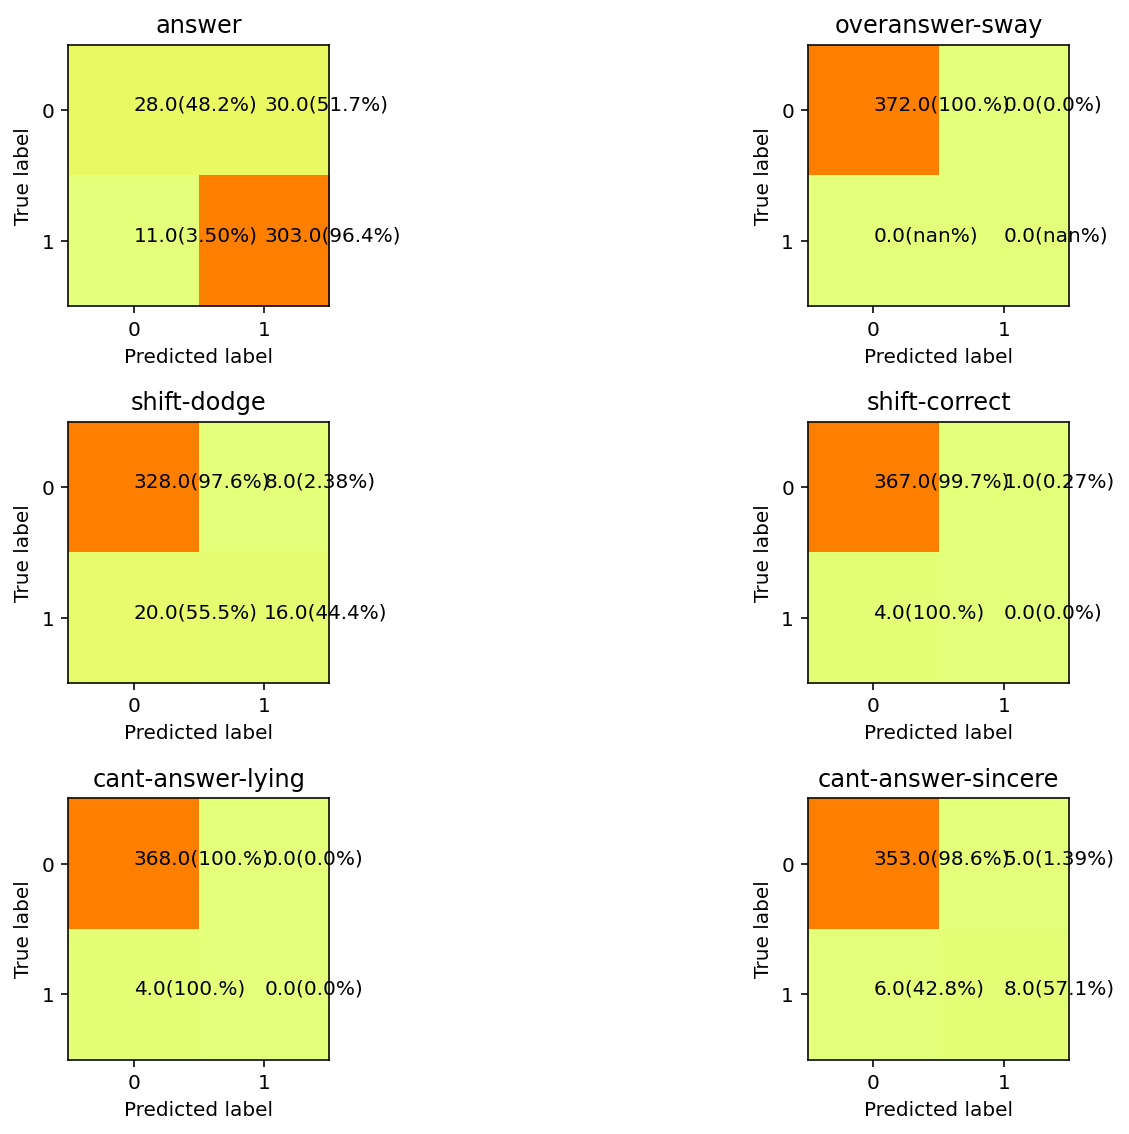

4
id_gold_pred [[11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598203, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349119, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11393834010, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11495063013, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11635230039, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531417073, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531417004, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531417101, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

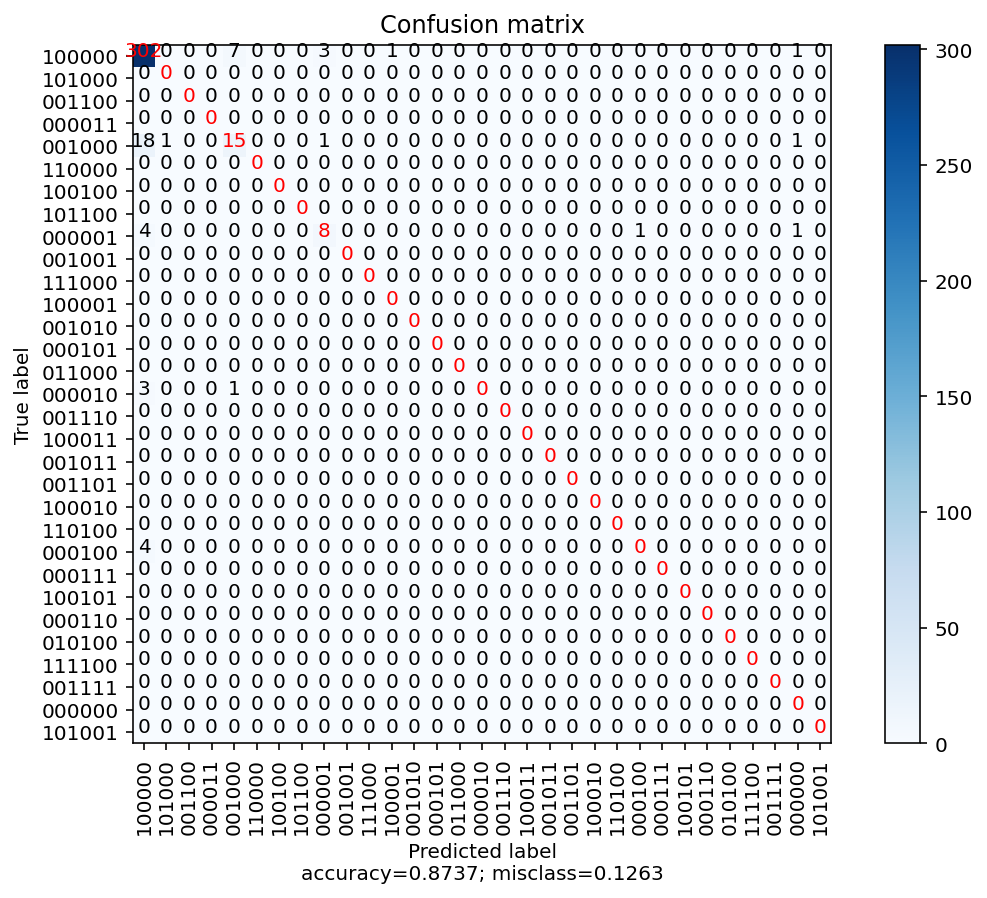

Fine F1-scores [0.93581303 0.         0.56356424 0.         0.         0.58333333]
Fold scores [0.37165637860082307, 0.3213794289645682, 0.2966284074605452, 0.3988095238095237]
F1 Macro 0.34711843470886505
Coarse F1-scores [0.93581303 0.50539216 0.54166667]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/easy-30/metrics_deberta_easy_hierarchical_gold_sentiments_coarse_num_r_text_test'
# filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/hard-30/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test'
analyse_hier(filename_prefix)

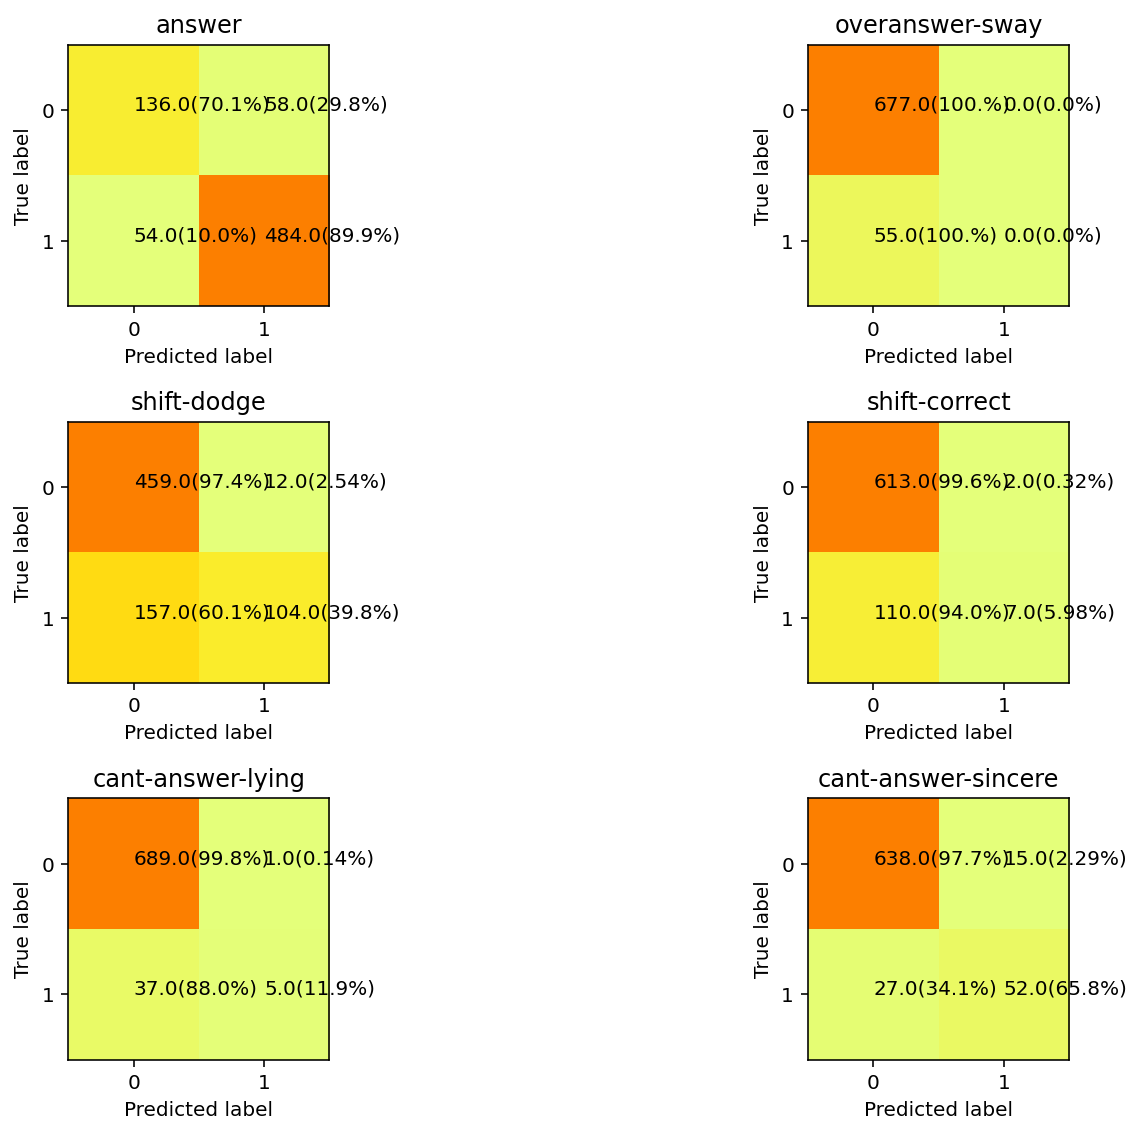

4
id_gold_pred [[11495063129, [1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11635230123, [0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11420722113, [1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598030, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11393834105, [1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349037, [0, 0, 1, 1, 0, 0], [1, 0, 0, 0, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349079, [0, 0, 0, 0, 1, 1], [1, 0, 0, 0, 0, 0]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11635589072, [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0,

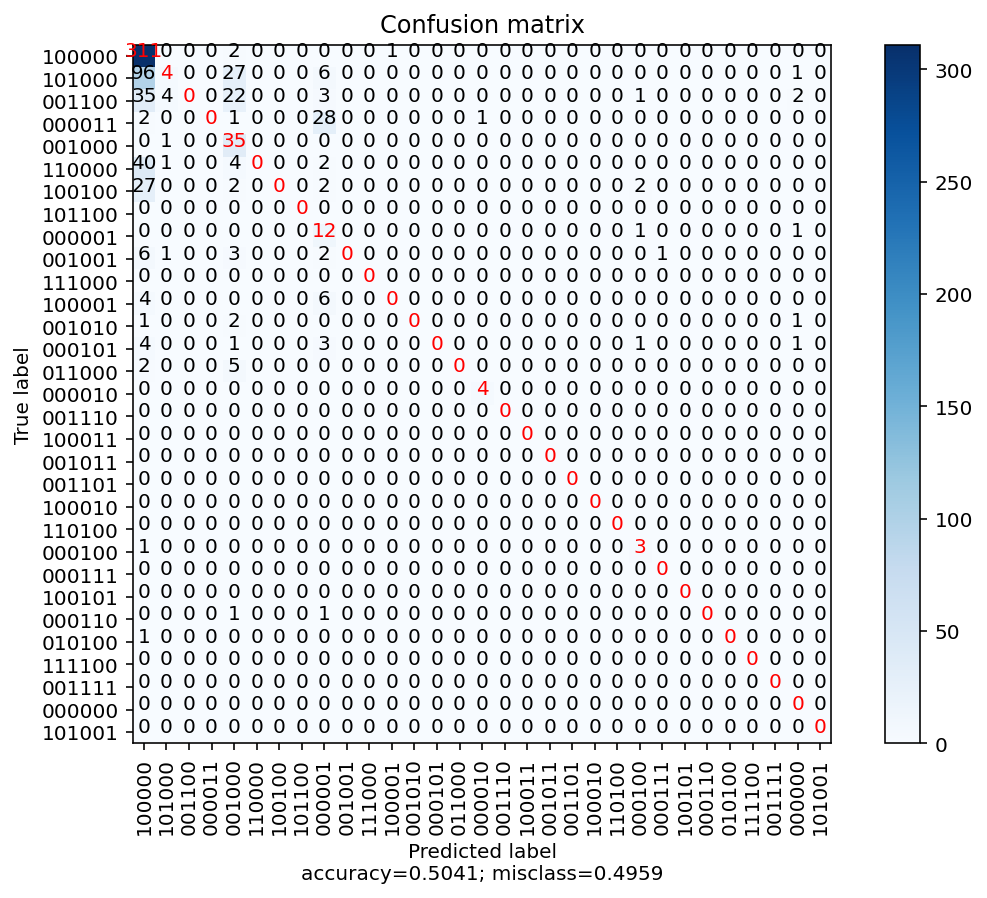

Fine F1-scores [0.89594504 0.         0.55152256 0.11259921 0.10869565 0.70682434]
Fold scores [0.3704618650270824, 0.4796185258632875, 0.3876799370220423, 0.3459642012833502]
F1 Macro 0.39593113229894056
Coarse F1-scores [0.89484001 0.53158502 0.70119048]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [ ]:
filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/med-30/metrics_deberta_med_hierarchical_gold_sentiments_coarse_num_r_text_test'

analyse_hier(filename_prefix)

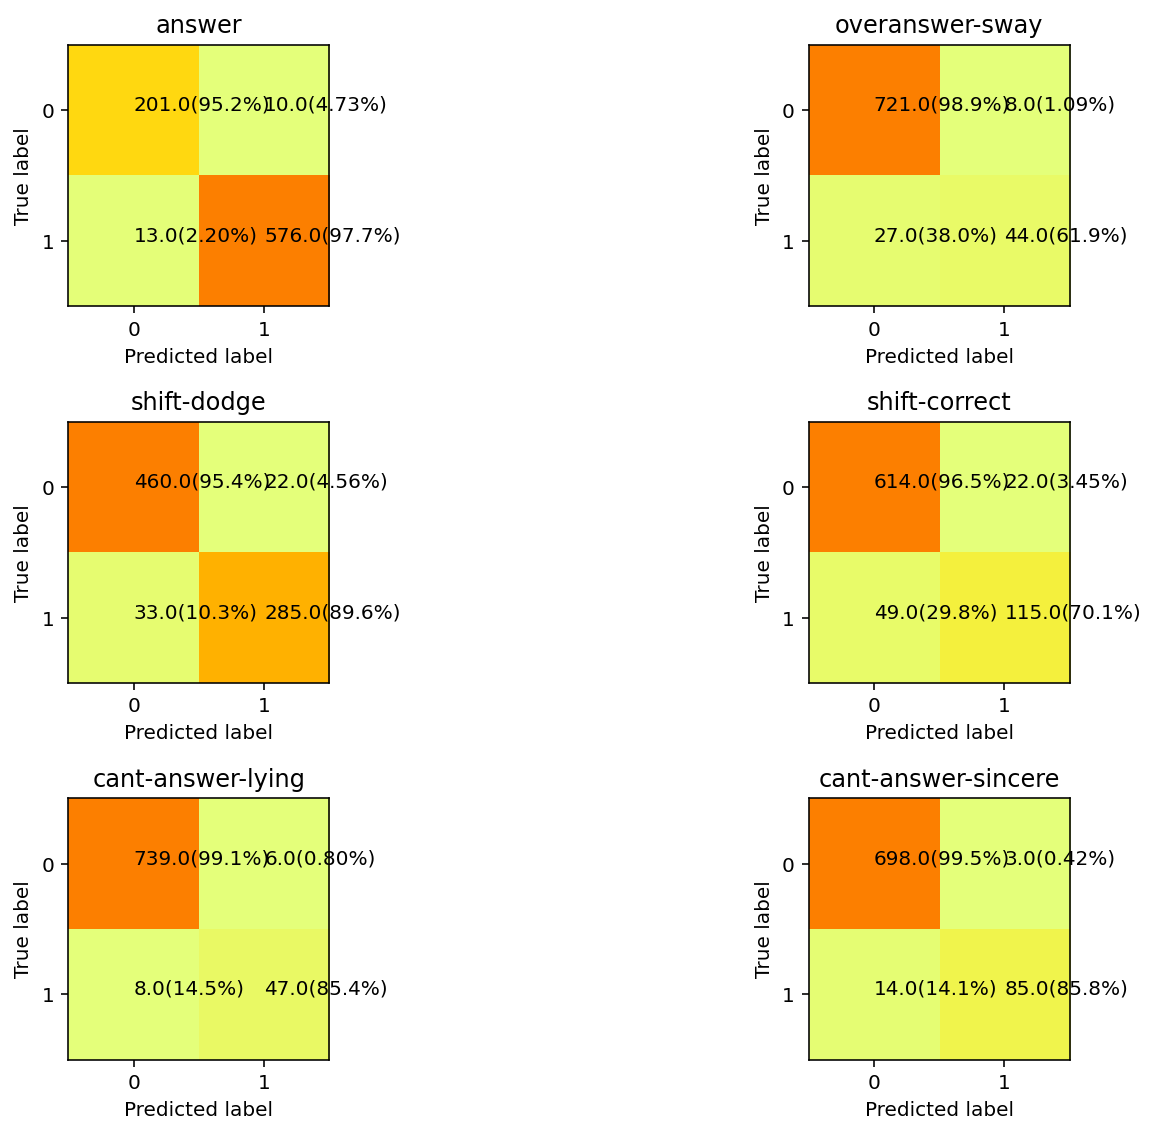

4
id_gold_pred [[11495063129, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11635230123, [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 1]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11420722113, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11389598030, [1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11393834105, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11530956043, [1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349037, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349079, [0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

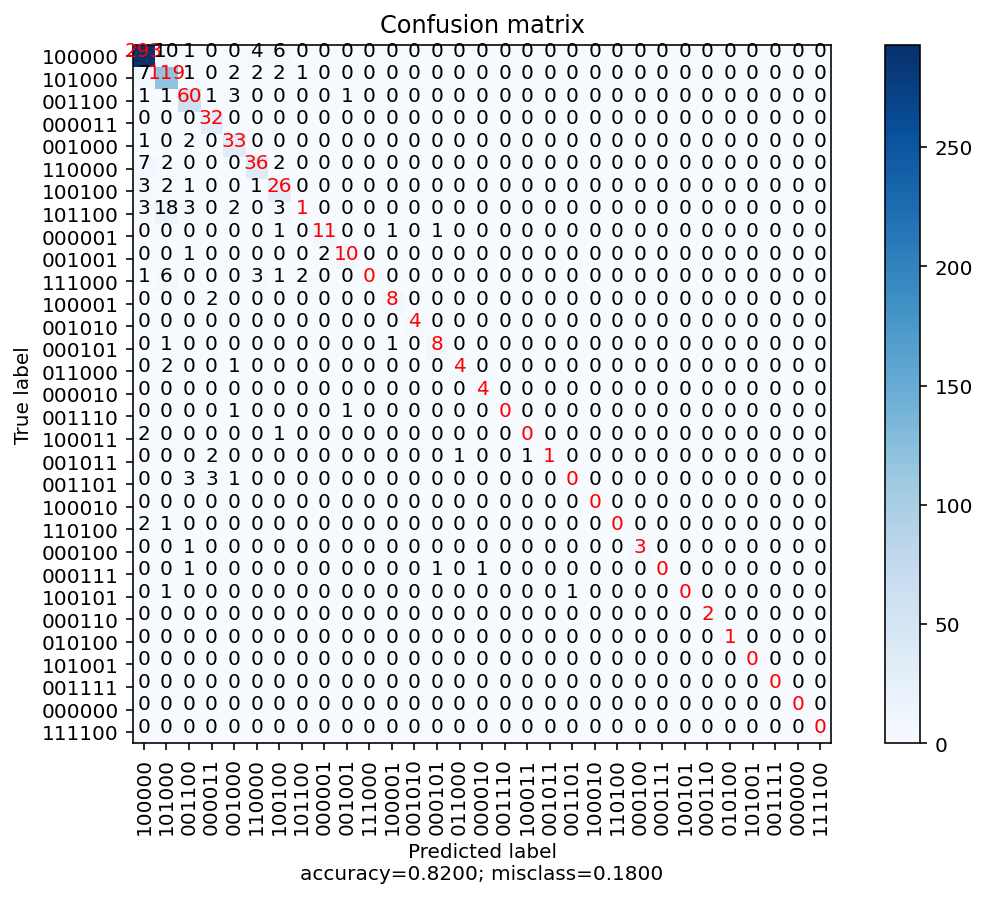

Fine F1-scores [0.98098024 0.68611111 0.91414805 0.76700806 0.8207326  0.90801093]
Fold scores [0.9224072025644205, 0.9438957827378466, 0.930437185152286, 0.5879204914080377]
F1 Macro 0.8461651654656477
Coarse F1-scores [0.98123269 0.92118679 0.91909254]


In [ ]:
filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/hard-30/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test_2'

analyse_hier(filename_prefix)

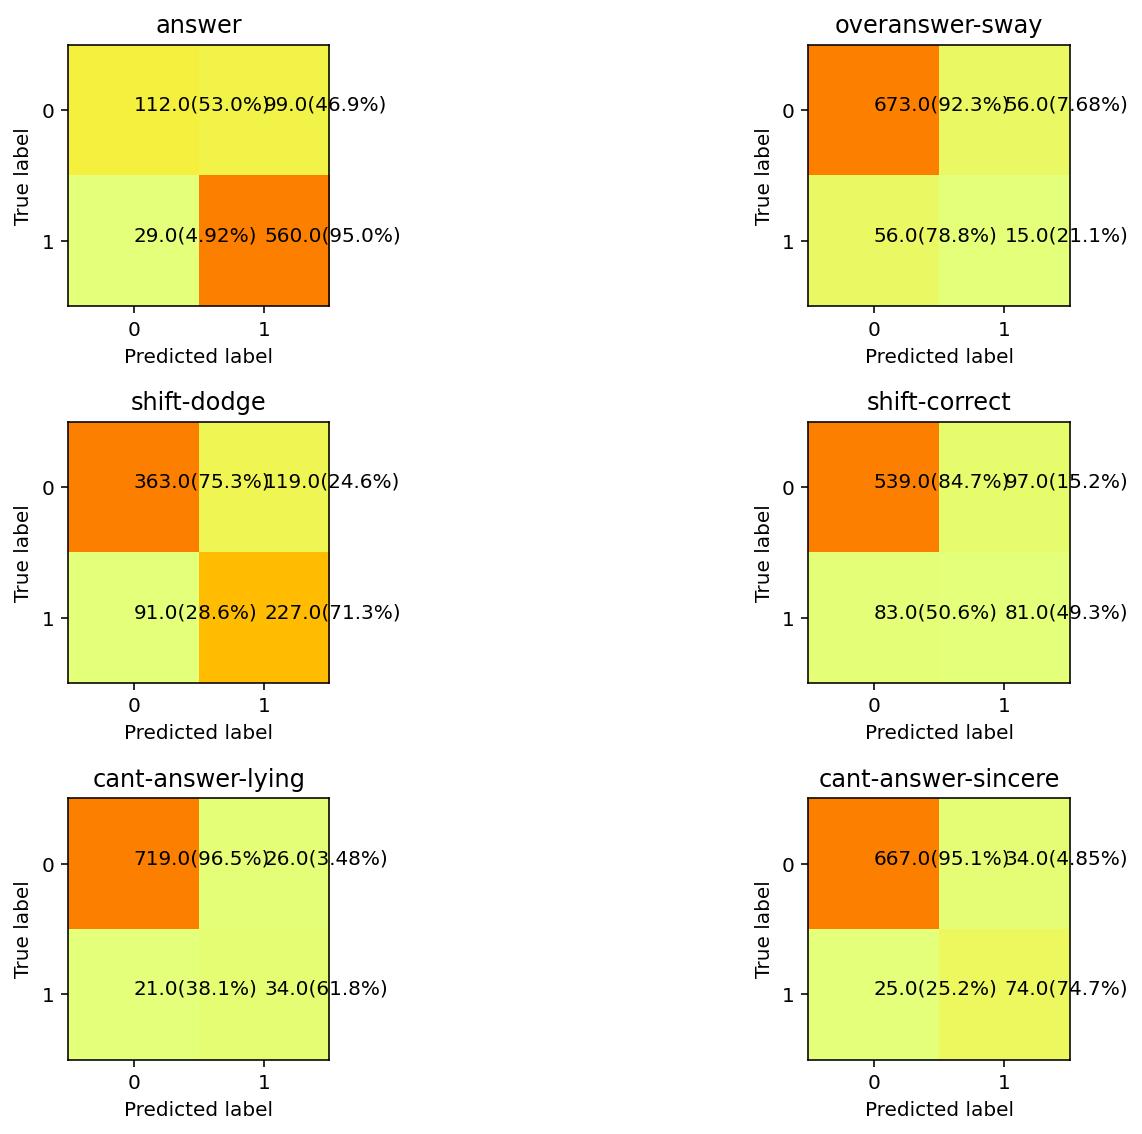

4
id_gold_pred [[11495063129, [1, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195154, [1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11635589127, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11635230123, [0, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1]], [11389598207, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11420722113, [1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11389598030, [1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11393834105, [1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11530956043, [1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11388494044, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11495063127, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11386195146, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11530242123, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349037, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11386195142, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531349079, [0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0]], [11388494035, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11389598061, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

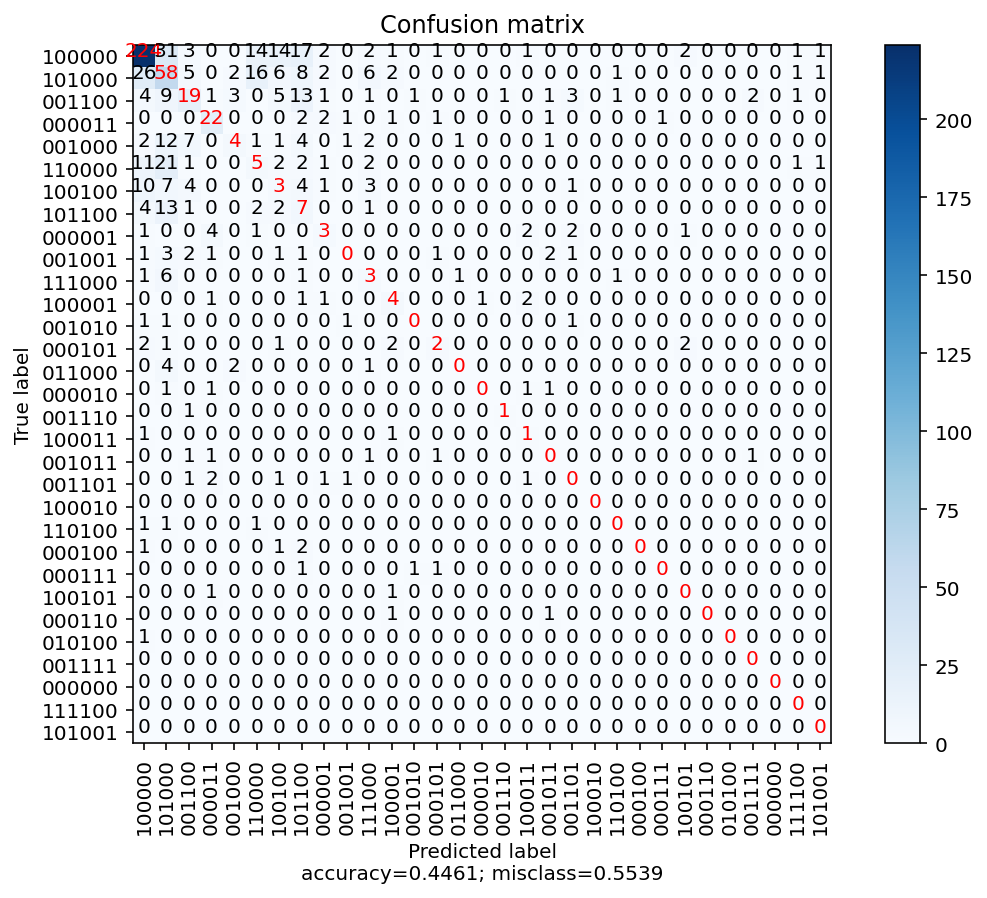

Fine F1-scores [0.89683402 0.20519472 0.68263468 0.47310168 0.55975643 0.71732148]
Fold scores [0.5822383965701093, 0.6001462657225914, 0.5518204937414721, 0.6223568594104308]
F1 Macro 0.5891405038611509
Coarse F1-scores [0.90085022 0.73258596 0.74655435]


In [ ]:
# filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/hard-30/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test_2'

filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/hard-fold-matching/metrics_deberta_hard_hierarchical_gold_sentiments_coarse_num_r_text_test_5_dec'
analyse_hier(filename_prefix)

## Roberta-Explanation






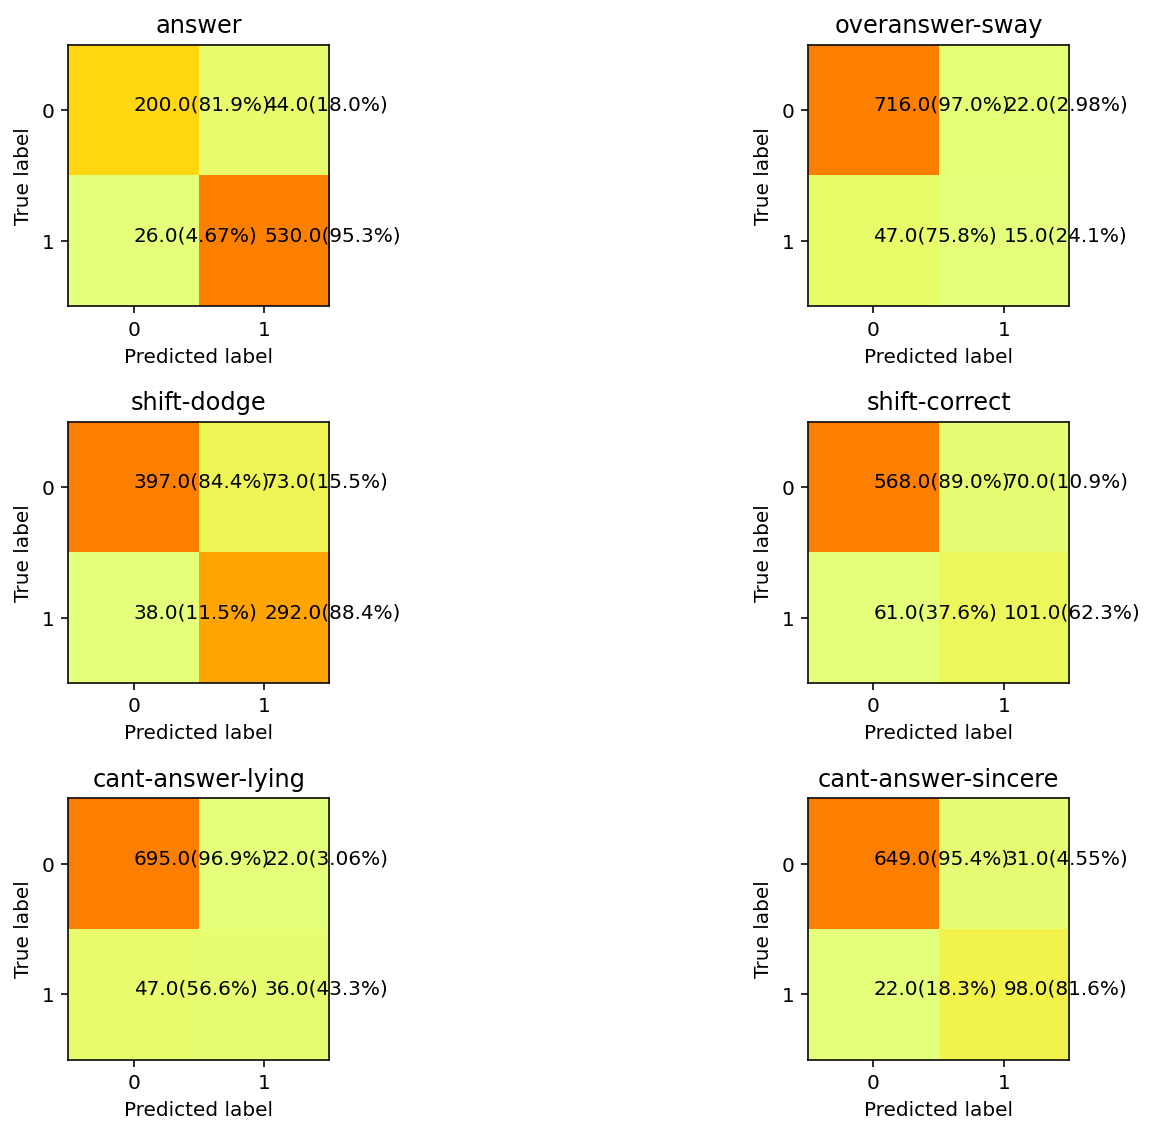

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 1, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 0, 0, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

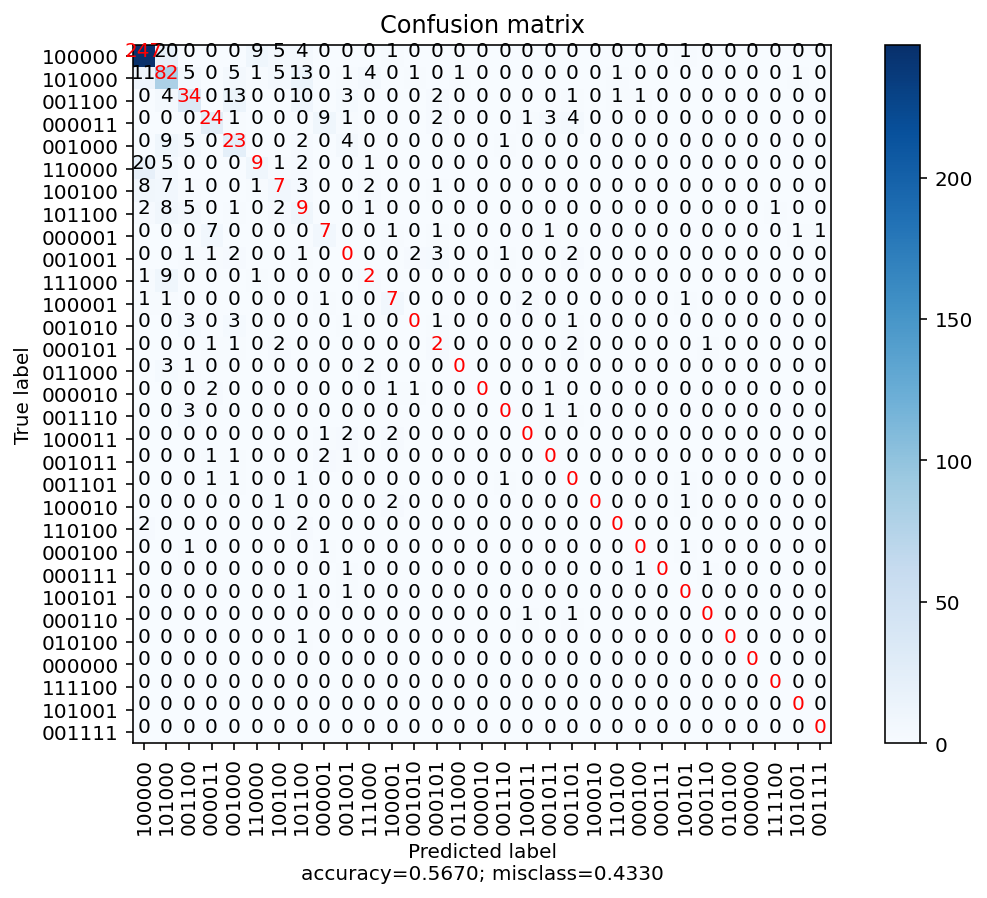

Fine F1-scores [0.93801707 0.30059524 0.84010997 0.61100796 0.50290312 0.78919935]
Fold scores [0.6511141680714103, 0.6043182683488245, 0.6604742285596276, 0.73864847175855]
F1 Macro 0.6636387841846031
Coarse F1-scores [0.94386128 0.87704923 0.85128066]


In [ ]:
filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/robert-explanations-final/metrics_roberta_hierarchical_explanations_concat_final'
analyse_hier(filename_prefix)

## Student Expert

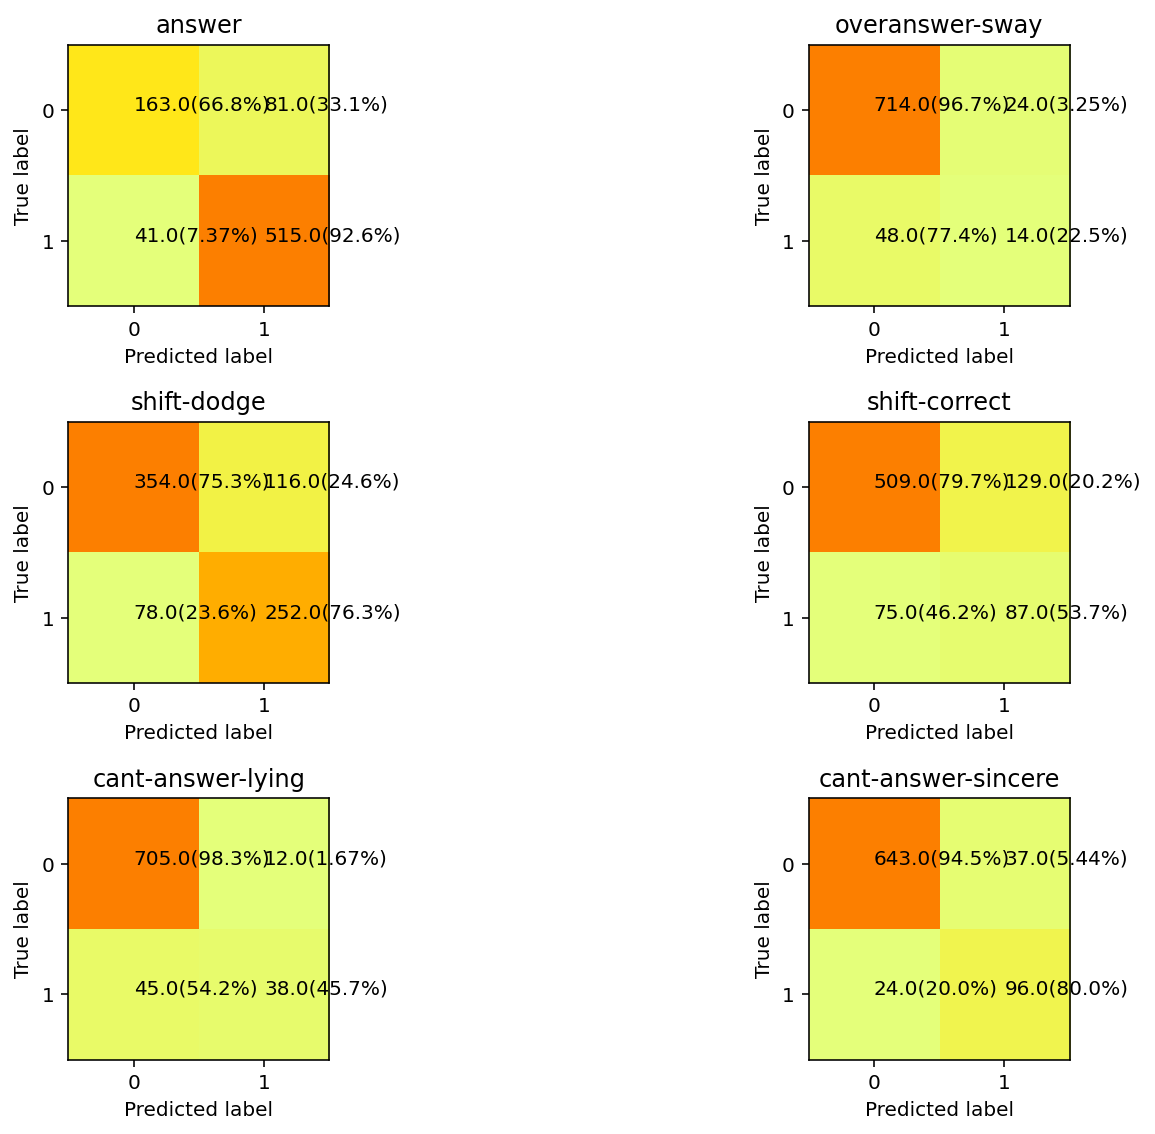

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 1]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0,

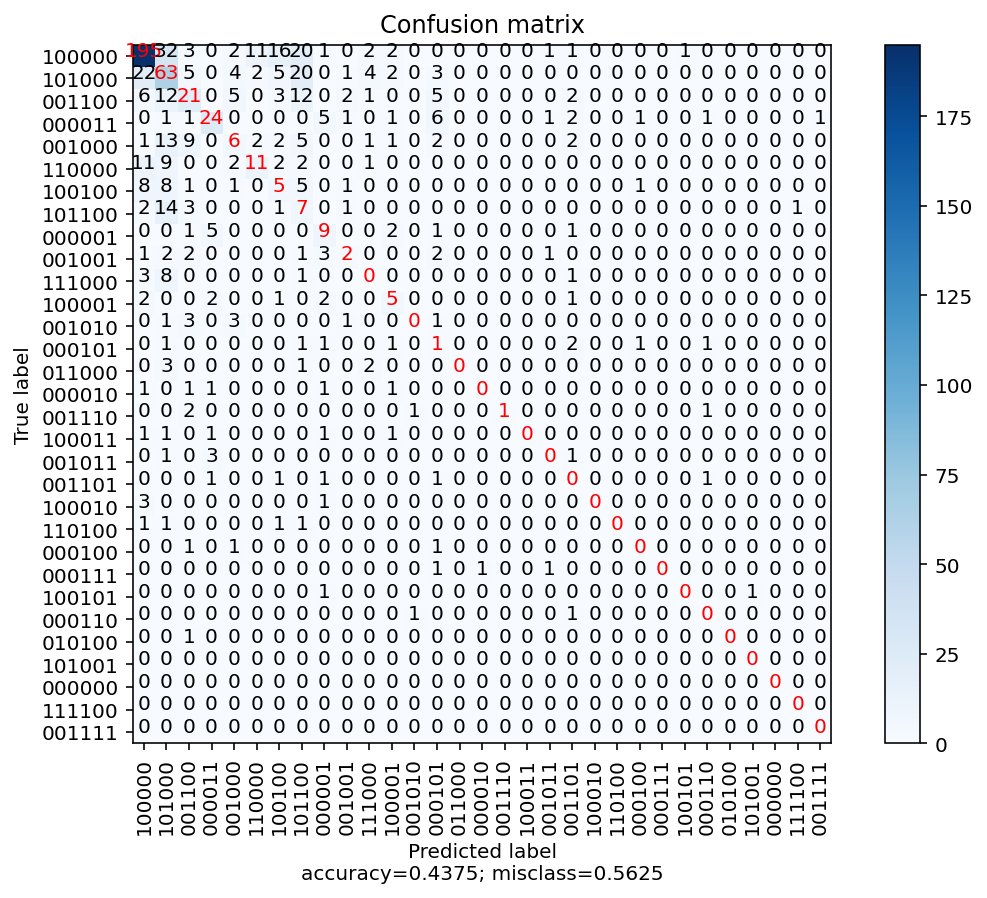

Fine F1-scores [0.89236582 0.28109997 0.71368794 0.4549685  0.58655709 0.76206955]
Fold scores [0.6046230121425232, 0.6223362298953986, 0.5959582051765983, 0.6375817943169269]
F1 Macro 0.6151248103828617
Coarse F1-scores [0.89738417 0.77814425 0.78432624]


In [11]:
# filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/roberta-student-expert-1/metrics_roberta_hierarchical_student_expert_3_concat_test'
filename_prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/roberta-student-expert-colab/metrics_roberta_hierarchical_student_expert_concat_test'
analyse_hier(filename_prefix)

## Loss Logits Analysis

In [ ]:


def get_metric_filenames(prefix, fine_or_coarse='fine', test=True):
  metric_files = []
  for fold in range(0, 4):
    if test:
      filename = prefix+str(fold)+'_test_'+ fine_or_coarse
    else:
      filename = prefix+str(fold)+'_dev_'+ fine_or_coarse
    metric_files.append(filename)
  return metric_files



In [ ]:
def get_metrics_dataframe(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    
    # json_gold_pred = "id/gold/pred"
    json_gold_pred_fine = "id_gold_pred_fine"
    # json_cm = 'confusion_matrix'
    if is_fine:
        json_gold_pred = "id_gold_pred_fine"
    else: 
      json_gold_pred = "id_gold_pred_coarse"
        # json_cm += '_fine'
    id_gold_preds = []
    # binary_confusion_matrix = np.zeros((6,2,2))
    id_gold_preds_folds = []
    for results_dict in results_dicts:
        # print(results_dict.keys())
        id_gold_preds_folds.append(results_dict[json_gold_pred])
        # binary_confusion_matrix += np.array(results_dict[json_cm])
    
    
    doc_ids = []
    target_labels = []
    predicted_labels = []
    # target_coarse_labels=[]
    # predicted_coarse_labels=[]
    losses = []
    # loss_coarse = []
    logits_total = []
    # logits_coarse = []

    target_sets = []
    predicted_sets = []
    # print(len(id_gold_preds_folds))
    # for id_gold_preds_fold in id_gold_preds_folds:
    for id_gold_pred in id_gold_preds_folds:
        # print('id_gold_pred', id_gold_pred)
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        logits_fold = []
        loss_fold = []
        pred_coarse_fold_labels = []
        print(len(id_gold_pred))
        # for doc_id, gold_set, pred_set, loss, logits in id_gold_pred:
        for doc_id, gold_set, pred_set, logits in id_gold_pred:

            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            # target_coarse_fold_labels.append(coarse_gold)
            # pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            # loss_fold.append(loss)
            logits_fold.append(logits)
            
            doc_fold_ids.append(doc_id)
        target_labels.extend(target_fold_labels)
        predicted_labels.extend(predicted_fold_labels)
        
        # target_coarse_labels.append(target_coarse_fold_labels)
        # predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.extend(doc_fold_ids)
        logits_total.extend(logits_fold)
        # losses.extend(loss_fold)

    # data = {'qa_index_digits': doc_ids, 'target': target_labels, 'prediction': predicted_labels, 'logits': logits_total, 'loss': losses}
    data = {'qa_index_digits': doc_ids, 'target': target_labels, 'prediction': predicted_labels, 'logits': logits_total}
    results_df = pd.DataFrame(data=data)    

    return results_df 
    

In [ ]:
prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/deberta-logits/metrics_deberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test_logits_30epoch.json_fold'

metric_files_fine = get_metric_filenames(prefix, 'fine')
metric_files_coarse = get_metric_filenames(prefix, 'coarse')
fine_metrics_df = get_metrics_dataframe(metric_files_fine, is_fine=True)
coarse_metrics_df = get_metrics_dataframe(metric_files_coarse, is_fine=False)

200
200
200
200
200
200
200
200


In [ ]:
[i for i, val in enumerate(coarse_metrics_df['target'][7]) if val == 1]

[0, 1, 2]

In [ ]:
def get_one_indices(vec):
  return [i for i, val in enumerate(vec) if val == 1]


def get_label_match_count(row):
  target = row['target']
  prediction = row['prediction']
  count = 0
  for t, p in zip(target, prediction):
    if t == p:
      count +=1
  return count

def process_metrics_df(df):


  df['logits_target'] = df.apply(lambda row: [row['logits'][i] for i in get_one_indices(row['target'])], axis=1)
  df['target_count'] = df.apply(lambda row: len(row['logits_target']), axis=1)
  df['logits_min'] = df.apply(lambda row: np.min(row['logits_target']), axis=1)
  df['logits_max'] = df.apply(lambda row: np.max(row['logits_target']), axis=1)
  df['logits_mean'] = df.apply(lambda row: np.mean(row['logits_target']), axis=1)
  df['logits_sum'] = df.apply(lambda row: np.sum(row['logits_target']), axis=1)
  df['label_match_count'] = df.apply(lambda row: get_label_match_count(row), axis=1)

  df.sort_values(by='logits_min', ascending=True, inplace=True)
  return df

In [ ]:
coarse_metrics_df = process_metrics_df(coarse_metrics_df)
fine_metrics_df = process_metrics_df(fine_metrics_df)

In [ ]:
fine_metrics_df.shape

(800, 11)

In [ ]:
fine_metrics_df[['target_count', 'logits_min']]

target_count  logits_min
228             2   -6.685827
277             2   -6.239615
708             2   -5.836157
273             2   -5.644195
738             2   -5.631882
424             2   -5.508254
747             2   -5.502084
11              3   -5.482753
504             2   -5.411134
766             2   -5.392193
364             2   -5.162571
703             2   -5.048203
562             3   -5.040389
403             2   -5.029234
238             3   -4.987793
458             2   -4.970015
649             2   -4.905458
299             2   -4.858529
367             2   -4.781600
441             2   -4.751896
730             2   -4.712444
44              2   -4.674938
130             2   -4.531854
343             2   -4.471544
237             3   -4.384690
752             2   -4.360207
175             2   -4.343256
528             2   -4.311691
460             2   -4.283663
759             2   -4.247416
160             2   -4.231517
328             3   -4.191026
521             3   -4.188150
108             3   -4.180808
784             3   -4.179323
563             3   -4.157153
602             3   -4.142003
472             2   -4.113364
724             3   -4.109215
566             3   -4.091048
239             2   -4.089175
227             3   -4.077286
755             3   -4.046771
503             1   -3.966203
702             2   -3.954964
223             2   -3.939684
642             2   -3.920287
554             1   -3.850229
107             3   -3.767578
559             2   -3.727083
48              2   -3.725920
620             2   -3.712731
305             2   -3.704881
539             2   -3.648518
555             2   -3.575916
191             2   -3.570438
638             3   -3.443339
380             3   -3.385234
32              2   -3.328383
164             3   -3.226013
413             2   -3.194546
78              2   -3.120868
26              2   -3.113717
187             2   -3.108969
104             2   -3.054755
448             2   -3.043159
464             2   -3.039294
634             2   -3.011191
261             3   -2.993072
666             3   -2.973361
231             2   -2.929034
186             2   -2.919251
386             2   -2.880998
660             2   -2.879545
575             3   -2.836116
375             2   -2.689837
719             2   -2.678799
271             2   -2.636791
482             3   -2.628849
469             2   -2.624613
621             3   -2.599044
581             1   -2.581421
543             3   -2.545424
74              2   -2.537567
112             3   -2.525407
85              2   -2.523945
165             2   -2.481188
628             2   -2.467729
438             3   -2.418560
381             2   -2.380265
645             2   -2.377443
522             2   -2.373024
344             3   -2.361012
548             2   -2.267327
335             2   -2.233556
741             2   -2.181868
72              2   -2.149634
706             2   -2.100748
210             2   -2.086962
162             3   -2.064656
37              2   -2.015671
113             3   -1.984571
254             3   -1.968780
544             2   -1.958667
264             2   -1.913988
355             2   -1.911803
372             3   -1.904583
92              2   -1.878222
346             2   -1.861072
323             3   -1.833808
40              3   -1.789959
668             2   -1.785189
56              2   -1.753045
30              1   -1.740169
395             3   -1.722174
493             3   -1.714976
318             3   -1.629158
425             2   -1.592129
348             3   -1.568801
412             2   -1.559164
606             3   -1.500320
262             2   -1.427732
117             3   -1.395890
6               2   -1.384078
166             2   -1.381312
333             2   -1.370211
217             2   -1.315753
251             2   -1.302528
216             2   -1.298160
250             2   -1.263334
173             2   -1.251557
391             2   -1.222229
751            

In [ ]:
# prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/deberta-logits/metrics_deberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test_logits_30epoch.json_fold'
# prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/deberta-logits-train/metrics_deberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test_logits_30epoch_train.json_fold'
# prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/epoch-5/metrics_deberta_sentiment_res_epoch_5.json_fold'
prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/epoch-5/metrics_deberta_sentiment_res_train.json_fold'


metric_files_fine = get_metric_filenames(prefix, 'fine', test=False)
metric_files_coarse = get_metric_filenames(prefix, 'coarse', test=False)
fine_metrics_df = get_metrics_dataframe(metric_files_fine, is_fine=True)
coarse_metrics_df = get_metrics_dataframe(metric_files_coarse, is_fine=False)

coarse_metrics_df = process_metrics_df(coarse_metrics_df)
fine_metrics_df = process_metrics_df(fine_metrics_df)

800
800
800
800
800
800
800
800


In [ ]:
fine_metrics_df.groupby('qa_index_digits').agg({'logits_min': np.mean})

logits_min
qa_index_digits            
11386195000        5.722992
11386195002        5.492201
11386195006        7.518943
11386195008        4.470280
11386195014        3.563444
...                     ...
11637282130        4.200323
11637282132        2.764541
11637282134        5.533337
11637282141        5.574745
11637282144        7.639447

[1000 rows x 1 columns]

In [ ]:
def get_metrics_dataframe_by_fold(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    
    json_gold_pred_fine = "id_gold_pred_fine"
    if is_fine:
        json_gold_pred = "id_gold_pred_fine"
    else: 
      json_gold_pred = "id_gold_pred_coarse"

    id_gold_preds = []

    id_gold_preds_folds = []
    for results_dict in results_dicts:

        id_gold_preds_folds.append(results_dict[json_gold_pred])

    
    doc_ids = []
    target_labels = []
    predicted_labels = []
    losses = []

    logits_total = []

    results_dfs = []
    target_sets = []
    predicted_sets = []

    for id_gold_pred in id_gold_preds_folds:

        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        logits_fold = []
        loss_fold = []
        pred_coarse_fold_labels = []
        print(len(id_gold_pred))

        for doc_id, gold_set, pred_set, logits in id_gold_pred:

            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)

            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            logits_fold.append(logits)
            
            doc_fold_ids.append(doc_id)

        data = {'qa_index_digits': doc_fold_ids, 'target': target_fold_labels, 'prediction': predicted_fold_labels, 'logits': logits_fold}
        results_df = pd.DataFrame(data=data)
        results_dfs.append(results_df)    
        
    return results_dfs 
    

def process_metrics_df_by_fold(dfs):
  new_dfs = []
  for df in dfs:
    new_dfs.append(process_metrics_df(df))
  return new_dfs


def save_dfs_by_fold(dfs, path):
  import os
  # suffix = 'sorted_min_logits.csv'
  for fold in range(0, 4):
    # os.remove(path + str(fold) + '/train.csv')
    # os.remove(path + str(fold) + '/train.tsv')
    dfs[fold].to_csv(path + str(fold) + '/logits.csv', index=False)
    csv_to_tsv(path + str(fold) + '/logits')

In [ ]:
# prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/deberta-logits-train/metrics_deberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test_logits_30epoch_train.json_fold'
# prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/deberta-logits-train/metrics_deberta_hierarchical_explanations_concat_gold_sentiments_coarse_num_r_text_test_logits_30epoch_train.json_fold'
prefix = '/content/drive/MyDrive/ANLP/subjective_discourse/code/models/hedwig/epoch-5/metrics_deberta_sentiment_res_train.json_fold'


metric_files_fine = get_metric_filenames(prefix, 'fine', test=False)
metric_files_coarse = get_metric_filenames(prefix, 'coarse', test=False)
fine_metrics_dfs = get_metrics_dataframe_by_fold(metric_files_fine, is_fine=True)
coarse_metrics_dfs = get_metrics_dataframe_by_fold(metric_files_coarse, is_fine=False)

coarse_metrics_dfs = process_metrics_df_by_fold(coarse_metrics_dfs)
fine_metrics_dfs = process_metrics_df_by_fold(fine_metrics_dfs)

NameError: ignored

In [ ]:
path = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingLogitsFold/fold'
save_dfs_by_fold(fine_metrics_dfs, path)


In [ ]:
folds_path = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingFolds/fold'
logits_path = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingLogitsFold/fold'
new_folds_path = '/content/drive/MyDrive/ANLP/subjective_discourse/data/gold/CongressionalHearingLogitsSortedFolds/fold'

import shutil
def get_logit_train_dfs(logits_path, folds_path, new_folds_path):

  logit_dfs = []
  train_dfs = []


  for fold in range(0, 4):
    logit_filename = logits_path + str(fold) + '/logits.tsv'
    train_filename = folds_path + str(fold) + '/train.tsv'
    train_df = pd.read_csv(train_filename, sep='\t')
    logit_df = pd.read_csv(logit_filename, sep='\t')
    new_train_df = pd.merge(train_df, logit_df, on="qa_index_digits", how="left").sort_values(by='logits_min', ascending=False)

    new_train_df.to_csv(new_folds_path + str(fold) + '/train.csv', index=False)
    csv_to_tsv(new_folds_path + str(fold) + '/train')

    test_src = folds_path + str(fold) + '/test.tsv'
    test_dest = new_folds_path + str(fold) + '/test.tsv'
    shutil.copyfile(test_src, test_dest)


get_logit_train_dfs(logits_path, folds_path, new_folds_path)

In [ ]:
logit_dfs[0].columns

Index(['qa_index_digits', 'target', 'prediction', 'logits', 'logits_target',
       'target_count', 'logits_min', 'logits_max', 'logits_mean', 'logits_sum',
       'label_match_count'],
      dtype='object')

In [ ]:


pd.merge(train_dfs[0], logit_dfs[0], on="qa_index_digits", how="left").sort_values(by='logits_min').columns

Index(['qa_index_digits', 'gold_labels_binary', 'r_text', 'q_text',
       'q_text_last_question', 'gold_sentiments', 'gold_q_sentiments',
       'gold_workers', 'gold_q_intents', 'hit_order', 'q_speaker_role',
       'r_speaker_role', 'gold_q_intents_num', 'q_speaker_party',
       'gold_sentiments_num', 'gold_q_sentiments_num',
       'gold_sentiments_coarse_num', 'q_speaker', 'gold_sentiments_binary',
       'gold_q_sentiments_count', 'gold_sentiments_coarse_count',
       'gold_sentiments_coarse_binary', 'gold_q_sentiments_coarse_count',
       'gold_q_sentiments_coarse_num', 'gold_q_sentiments_coarse_binary',
       'entropy', 'entropy_norm', 'entropy_norm_buckets', 'entropy_binarized',
       'question_type_num', 'q_text_all_questions', 'gold_label_powerset',
       'gold_label_powerset_binary', 'q_text_last_2_sents',
       'q_text_last_3_sents', 'q_text_first_question_and_rest',
       'q_text_last_question_and_rest', 'target', 'prediction', 'logits',
       'logits_target', 't

In [ ]:
fine_metrics_dfs[0]

NameError: ignored